In [1]:
!python --version
!pip install -U ultralytics

# Check a single package
#from ultralytics.utils.checks import check_requirements
#check_requirements('ultralytics==8.2.0')

import ultralytics
print("VERSIÓN DE ULTRALYTICS: ", ultralytics.__version__)

Python 3.11.8
VERSIÓN DE ULTRALYTICS:  8.3.21


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [3]:
!pip install pytube --upgrade
#If PyTorch was not already installed on your environment, you might need to reinstall a Pytorch version suitable for your CUDA version.
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(torch.cuda.device_count())
torch._C._cuda_getDeviceCount()
torch.cuda.is_available()

1


True

In [4]:
class CFG_WITH_TAG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    CLASSES = ["Glasses", "Gloves", "Hardhat", "Head", "Person", "Safety-Vest"]
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    #PROPIEDADES DEL ENTRENAMIENTO
    EPOCHS = 3 if DEBUG else 5500 #100
    BATCH_SIZE = -1
    BASE_MODEL = 'yolov8m' #probar con yolov8s o yolov8m
    BASE_MODEL_WEIGTHS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'model_03_06_{BASE_MODEL}_{EPOCHS}_epochs'
    NMS = 0.65

    OPTIMIZER = 'SGD'
    LR = 1e-3
    LR_FACTOR = 0.01
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0005
    WARMUP_EPOCHS = 6
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    CUSTOM_DATASET_DIR = '/home/jovyan/work/Safework/EPI_WITH_TAG-1'
    OUTPUT_DIR = './'

In [6]:
import os

dict_file = {
   'train' : os.path.join(CFG_WITH_TAG.CUSTOM_DATASET_DIR, 'train'),
   'val' : os.path.join(CFG_WITH_TAG.CUSTOM_DATASET_DIR, 'valid'),
   'test' : os.path.join(CFG_WITH_TAG.CUSTOM_DATASET_DIR, 'test'),
   'nc' : CFG_WITH_TAG.NUM_CLASSES_TO_TRAIN,
   'names' : CFG_WITH_TAG.CLASSES
    }

with open(os.path.join(CFG_WITH_TAG.OUTPUT_DIR, 'data_with_tag_04_04.yaml'), 'w+') as file:
   yaml.dump(dict_file, file)

print("Data created")

Data created


In [5]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")


    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')


    print("Terminado")
    plt.show()



In [6]:
example_image_path = 'EPI_WITH_TAG-1/train/images/gettyimages-1171239866-612x612_jpg.rf.622a4fb285cfba07c63d8cbaf609d72e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

FileNotFoundError: [Errno 2] No such file or directory: 'EPI_WITH_TAG-1/train/images/gettyimages-1171239866-612x612_jpg.rf.622a4fb285cfba07c63d8cbaf609d72e.jpg'

In [7]:
def plot_random_Images_from_folder(folder_path , num_images = 20, seed = CFG_WITH_TAG.SEED):

    random.seed(seed)

    #Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    #Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    #Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    #Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1)
    fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 40))

    for i, file_name in enumerate (selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')

    #Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])


    plt.tight_layout()
    plt.show()

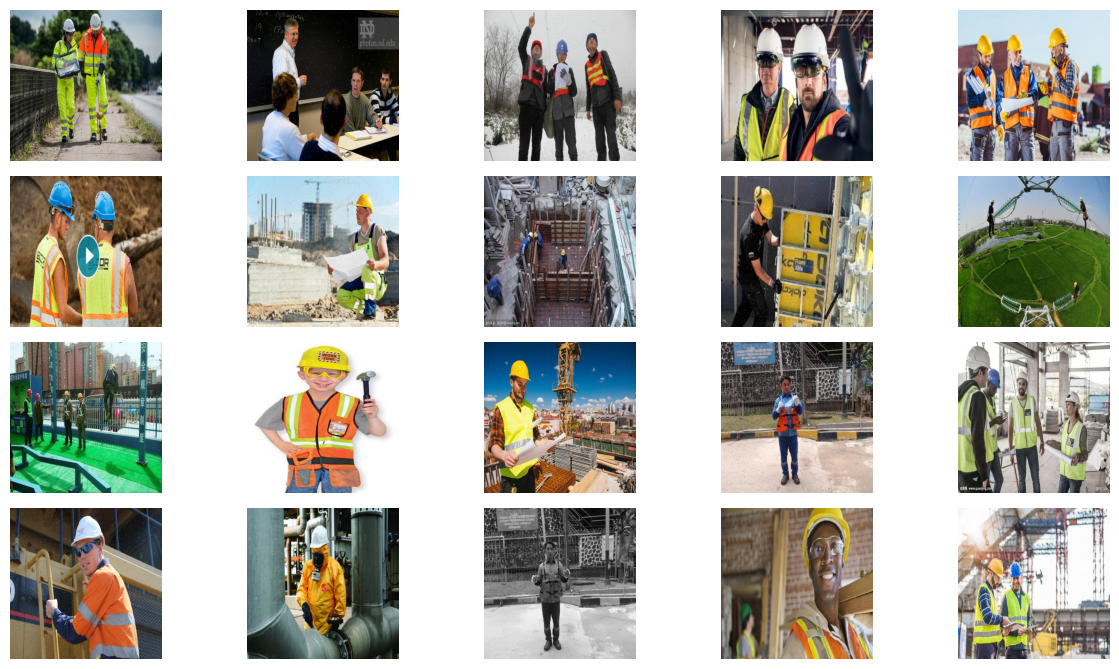

In [8]:
folder_path = CFG_WITH_TAG.CUSTOM_DATASET_DIR + '/train/images/'
plot_random_Images_from_folder(folder_path, num_images = 20, seed = CFG_WITH_TAG.SEED)

In [9]:
def get_image_properties(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError("Could not read image file")

    properties = {
        "width" : img.shape[1],
        "height" : img.shape[0],
        "channels" : img.shape[2] if len(img.shape) == 3 else 1,
        "dtype" : img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [10]:
%%time
class_idx = {str(i) : CFG_WITH_TAG.CLASSES[i] for i in range(CFG_WITH_TAG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG_WITH_TAG.CLASSES[i] : 0 for i in range(CFG_WITH_TAG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG_WITH_TAG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open (os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode' : mode, **class_count, 'Data_ Volume' : data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 8.39 ms, sys: 23 ms, total: 31.4 ms
Wall time: 30.8 ms


Mode  Glasses  Gloves  Hardhat  Head  Person  Safety-Vest  Data_ Volume
0  train      554     540     2096   264    2354         1294          2918
1  valid       63      34      291    52     340          192           374
2   test       45      32      152    15     169           89           202

In [22]:
CFG_WITH_TAG.BASE_MODEL_WEIGTHS
model = YOLO(CFG_WITH_TAG.BASE_MODEL_WEIGTHS)

In [11]:
model = YOLO("/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/best.pt")
results = model.predict(
    source = example_image_path,
    
    conf = 0.25,
    device = [1], # inference with dual GPU, cambiar a [1] cuando haya GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /home/jovyan/work/Safework/EPI_WITH_TAG-1/train/images/gettyimages-1171239866-612x612_jpg.rf.622a4fb285cfba07c63d8cbaf609d72e.jpg: 640x640 4 Glassess, 4 Hardhats, 3 Persons, 3 Safety-Vests, 6.2ms
Speed: 0.6ms preprocess, 6.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
4 labels saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 

Terminado


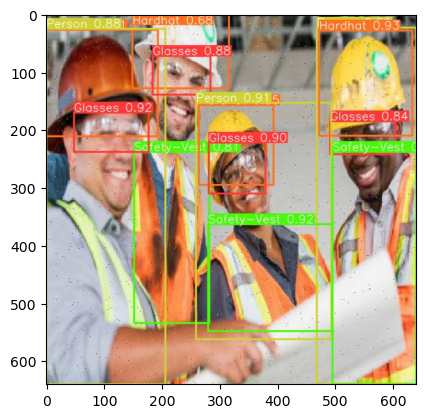

In [12]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [15]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         1.7T  197G  1.4T  13% /
tmpfs            64M     0   64M   0% /dev
shm             9.0G     0  9.0G   0% /dev/shm
/dev/nvme0n1p3  1.7T  197G  1.4T  13% /etc/hosts
tmpfs            32G   12K   32G   1% /proc/driver/nvidia
tmpfs           6.3G  3.0M  6.3G   1% /run/nvidia-persistenced/socket
tmpfs            32G     0   32G   0% /proc/asound
tmpfs            32G     0   32G   0% /proc/acpi
tmpfs            32G     0   32G   0% /proc/scsi
tmpfs            32G     0   32G   0% /sys/firmware
tmpfs            32G     0   32G   0% /sys/devices/virtual/powercap


In [10]:
model = YOLO("/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/last.pt")

model.train(
    epochs = CFG_WITH_TAG.EPOCHS,
    patience = CFG_WITH_TAG.EPOCHS,
    resume = True)

Ultralytics YOLOv8.2.30 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 22706MiB)
engine/trainer: task=detect, mode=train, model=/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/last.pt, data=/home/jovyan/work/Safework/EPI_WITH_TAG-1/data.yaml, epochs=5500, time=None, patience=5500, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=model_03_06_yolov8m_5500_epochs, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.65, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer

train: Scanning /home/jovyan/work/Safework/EPI_WITH_TAG-1/train/labels.cache... 2918 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2918/2918 [00:00<?, ?it/s]
val: Scanning /home/jovyan/work/Safework/EPI_WITH_TAG-1/valid/labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]


Plotting labels to runs/detect/model_03_06_yolov8m_5500_epochs/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


AssertionError: /home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/last.pt training to 5500 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/last.pt'

In [ ]:
%%time
model.train(
    data = '/home/jovyan/work/Safework/EPI_WITH_TAG-1/data.yaml',
    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG_WITH_TAG.EPOCHS,
    batch = CFG_WITH_TAG.BATCH_SIZE,
    optimizer = CFG_WITH_TAG.OPTIMIZER,
    lr0 = CFG_WITH_TAG.LR,
    lrf = CFG_WITH_TAG.LR_FACTOR,
    iou = CFG_WITH_TAG.NMS,
    momentum = CFG_WITH_TAG.MOMENTUM,
    weight_decay = CFG_WITH_TAG.WEIGHT_DECAY,
    warmup_epochs = CFG_WITH_TAG.WARMUP_EPOCHS,
    dropout = CFG_WITH_TAG.DROPOUT,
    fraction = CFG_WITH_TAG.FRACTION,
    patience = CFG_WITH_TAG.EPOCHS,
    profile = CFG_WITH_TAG.PROFILE,
    label_smoothing = CFG_WITH_TAG.LABEL_SMOOTHING,

    name = f'{CFG_WITH_TAG.EXP_NAME}',
    seed = CFG_WITH_TAG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0, #cambiar device = 0, cuando haya gpu
    verbose = False,
)

Ultralytics YOLOv8.2.28 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 22706MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/jovyan/work/Safework/EPI_WITH_TAG-1/data.yaml, epochs=5500, time=None, patience=5500, batch=-1, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=model_03_06_yolov8m_5500_epochs, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.65, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

train: Scanning /home/jovyan/work/Safework/EPI_WITH_TAG-1/train/labels.cache... 2918 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2918/2918 [00:00<?, ?it/s]
val: Scanning /home/jovyan/work/Safework/EPI_WITH_TAG-1/valid/labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]


Plotting labels to runs/detect/model_03_06_yolov8m_5500_epochs/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/model_03_06_yolov8m_5500_epochs
Starting training for 5500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/5500      18.3G      1.588      2.655      1.683         45        640: 100%|██████████| 183/183 [00:31<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.91it/s]

                   all        374       2485      0.406      0.453      0.413      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/5500      18.4G      1.322        1.4      1.454         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.44it/s]

                   all        374       2485       0.65      0.603      0.654      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/5500      18.5G      1.211      1.062      1.346         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]

                   all        374       2485       0.71      0.714      0.749      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/5500      18.4G      1.175     0.9273      1.302         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.63it/s]

                   all        374       2485      0.777       0.78      0.814      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/5500      18.4G       1.13     0.8428      1.268         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.77it/s]

                   all        374       2485      0.844      0.777      0.849      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/5500      18.5G      1.116     0.7868      1.253         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.86it/s]

                   all        374       2485      0.871      0.805      0.882      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/5500      18.5G        1.1     0.7336       1.23         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.88it/s]

                   all        374       2485      0.886      0.798      0.879      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/5500      18.5G      1.079     0.6944      1.214         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.89it/s]

                   all        374       2485      0.906      0.786      0.895      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/5500      18.6G      1.057     0.6666      1.207         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.91it/s]

                   all        374       2485      0.885      0.803      0.897      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/5500      18.4G      1.053     0.6516      1.205         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.83it/s]

                   all        374       2485      0.864      0.819      0.902      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/5500      18.5G      1.036     0.6227      1.186         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.89it/s]

                   all        374       2485      0.894      0.805      0.904      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/5500      18.5G       1.03      0.604      1.182         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.90it/s]

                   all        374       2485      0.842      0.846      0.901      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/5500      18.6G      1.015     0.5984      1.174         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.897      0.821      0.904      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/5500      18.4G      1.016     0.5897      1.169         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.866      0.832        0.9      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/5500      18.5G     0.9853     0.5756      1.157         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.826      0.894      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/5500      18.5G     0.9872      0.569      1.158         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.847       0.86      0.907      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/5500      18.6G     0.9828     0.5595      1.148         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.887      0.842      0.901      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/5500      18.4G      0.977     0.5547      1.149        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.847      0.843      0.902      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/5500      18.5G      0.958     0.5429      1.138         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.869      0.836      0.893       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/5500      18.5G     0.9522     0.5334      1.133         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.889      0.798      0.887      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/5500      18.6G     0.9454     0.5291      1.131         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.864      0.827      0.891      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/5500      18.4G     0.9311     0.5213      1.123         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.846      0.903       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/5500      18.5G      0.932     0.5226      1.118         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.834      0.851      0.897      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/5500      18.5G     0.9214     0.5118       1.11         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.868      0.823      0.898      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/5500      18.6G     0.9155     0.5085       1.11        111        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.886      0.811      0.902      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/5500      18.4G     0.8976     0.5016      1.107         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.881      0.825        0.9      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/5500      18.6G     0.8948     0.4945      1.107         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.839      0.893      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/5500      18.5G      0.894     0.4936      1.105         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.836      0.899      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/5500      18.6G     0.8756     0.4827        1.1         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.897      0.801       0.89      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/5500      18.5G     0.8661     0.4772       1.09         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.833      0.876      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/5500      18.5G     0.8675     0.4745      1.087        122        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.873      0.795      0.892      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/5500      18.5G     0.8635     0.4768       1.09         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.873      0.818      0.896      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/5500      18.6G     0.8513     0.4665      1.086         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.842      0.899      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/5500      18.4G     0.8518     0.4671      1.082         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.841      0.893      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/5500      18.5G     0.8363     0.4588      1.075         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.887      0.817      0.888      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/5500      18.5G     0.8381     0.4586      1.067         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.883      0.819      0.896      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/5500      18.5G     0.8298     0.4558      1.071         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.865       0.83      0.885      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/5500      18.4G     0.8217     0.4538      1.064         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862       0.83      0.892      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/5500      18.5G     0.8243     0.4452      1.058        129        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.849      0.898      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/5500      18.5G     0.8119     0.4417      1.056         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.828       0.85       0.89      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/5500      18.6G     0.8106     0.4431       1.06         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.896      0.823      0.903      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/5500      18.4G     0.8025     0.4448      1.051         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.838      0.884      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/5500      18.5G     0.7971     0.4382      1.052         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.839      0.904      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/5500      18.5G     0.7949     0.4359       1.05         24        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.859      0.839      0.898      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/5500      18.5G     0.7903     0.4361      1.051         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849       0.84      0.894      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/5500      18.4G     0.7827     0.4309      1.046         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.873      0.829      0.892      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/5500      18.5G      0.786     0.4317      1.038         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.819      0.895      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/5500      18.5G     0.7768     0.4296      1.043         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.832      0.851      0.893      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/5500      18.5G     0.7725     0.4251      1.042         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.822      0.886      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/5500      18.5G     0.7692      0.422      1.038         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.875       0.81      0.881      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/5500      18.5G     0.7607       0.42      1.031         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.828      0.888      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/5500      18.5G     0.7593     0.4128      1.023         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.853      0.826      0.878      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/5500      18.6G     0.7449     0.4135      1.022         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.841      0.849      0.888      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/5500      18.4G     0.7488     0.4138       1.03         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.843      0.823      0.872       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/5500      18.5G     0.7456     0.4154      1.029         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.827      0.877      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    56/5500      18.5G     0.7434     0.4148      1.024         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.862      0.835      0.888      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    57/5500      18.5G     0.7372     0.4022       1.02         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.843      0.838      0.882      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    58/5500      18.5G     0.7402     0.4042       1.02         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.855      0.882      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    59/5500      18.6G     0.7268     0.4004      1.021         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.836      0.853      0.885      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    60/5500      18.5G     0.7316     0.4079      1.021         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.898      0.792      0.877      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    61/5500      18.5G     0.7279     0.4027      1.017         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.878      0.795      0.886      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    62/5500      18.5G     0.7184     0.3985      1.017         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.857      0.819      0.888      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    63/5500      18.5G     0.7173     0.3967      1.015         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.887      0.786      0.885      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    64/5500      18.5G     0.7136     0.3956      1.013         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.835      0.837      0.887      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    65/5500      18.5G     0.7115     0.3928      1.008         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.832      0.883       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    66/5500      18.4G     0.7037       0.39      1.005         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.839      0.842      0.875      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    67/5500      18.5G     0.7059     0.3896      1.008        102        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.835      0.888      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    68/5500      18.5G     0.7112     0.3976      1.009         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.828      0.888      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    69/5500      18.5G     0.6983     0.3896      1.005         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.888      0.797      0.892       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    70/5500      18.4G      0.693     0.3854     0.9992         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846       0.82      0.875      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    71/5500      18.5G      0.686      0.379      1.002         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.814      0.888      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    72/5500      18.5G      0.686     0.3791     0.9954         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.862      0.818      0.878      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    73/5500      18.5G     0.6811     0.3803     0.9944         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.889      0.796      0.883      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    74/5500      18.4G     0.6838      0.379     0.9969         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.842      0.886      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    75/5500      18.6G     0.6806     0.3797     0.9947         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.848      0.833      0.878       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    76/5500      18.5G     0.6637     0.3755     0.9882         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844       0.83      0.869      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    77/5500      18.5G     0.6739     0.3773     0.9908         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.813      0.875      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    78/5500      18.4G     0.6636     0.3693     0.9877         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.855       0.81      0.872      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    79/5500      18.5G     0.6623     0.3721     0.9868         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.884      0.791      0.878      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    80/5500      18.6G     0.6622     0.3717      0.989         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.85it/s]

                   all        374       2485      0.855      0.806      0.873      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    81/5500      18.5G      0.659     0.3693     0.9883         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.871      0.805      0.875      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    82/5500      18.5G     0.6666     0.3729     0.9887         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.85      0.823      0.877      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    83/5500      18.6G     0.6533     0.3669       0.98         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.823      0.881      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    84/5500      18.5G     0.6501     0.3644      0.982         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.859      0.828      0.879      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    85/5500      18.5G     0.6492     0.3676     0.9843         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.836      0.835      0.876      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    86/5500      18.4G     0.6431     0.3656      0.981         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.869      0.813      0.881      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    87/5500      18.5G     0.6449     0.3654     0.9831         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.821      0.886      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    88/5500      18.5G     0.6443     0.3612     0.9796         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.843      0.845      0.892      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    89/5500      18.5G     0.6393     0.3606     0.9803         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862       0.83      0.887      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    90/5500      18.4G     0.6321     0.3559      0.977         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.89      0.817      0.895      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    91/5500      18.5G     0.6304     0.3571     0.9759         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.837      0.887      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    92/5500      18.6G     0.6297     0.3581     0.9756         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.839      0.879      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    93/5500      18.5G     0.6321     0.3599     0.9754         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.859      0.812       0.87       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    94/5500      18.4G     0.6362     0.3599     0.9761         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.839      0.886      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    95/5500      18.5G      0.621     0.3544     0.9689         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.881       0.81      0.882      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    96/5500      18.6G     0.6251     0.3547     0.9711         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.823      0.878       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    97/5500      18.6G     0.6199       0.35     0.9664         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.829      0.879      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    98/5500      18.4G     0.6138     0.3513     0.9677        109        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.848      0.837       0.88      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    99/5500      18.6G     0.6198     0.3529     0.9656         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.827      0.885      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   100/5500      18.6G     0.6108     0.3449     0.9619         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.797      0.867      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   101/5500      18.5G     0.6057     0.3425     0.9638         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.818      0.873      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   102/5500      18.4G     0.6112     0.3493      0.962         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.833      0.888      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   103/5500      18.5G     0.6043     0.3446     0.9615         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.826      0.876      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   104/5500      18.6G     0.6043      0.342     0.9616         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.857      0.829      0.888      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   105/5500      18.5G     0.6088     0.3461     0.9612         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.799      0.882      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   106/5500      18.4G     0.5967     0.3416     0.9621         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.825      0.881      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   107/5500      18.5G        0.6     0.3418     0.9587         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.831       0.89      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   108/5500      18.6G     0.5954     0.3409     0.9628         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.831      0.889      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   109/5500      18.5G     0.6032     0.3483     0.9652         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.814      0.886      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   110/5500      18.4G     0.5939     0.3367      0.958         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.837      0.897      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   111/5500      18.5G     0.5899     0.3354      0.955         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.834       0.89      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   112/5500      18.5G     0.5914     0.3379     0.9607         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.832      0.887      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   113/5500      18.6G     0.5906     0.3363     0.9559         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.871      0.809      0.883      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   114/5500      18.4G     0.5891     0.3361      0.955         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.869      0.822      0.883      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   115/5500      18.6G     0.5878     0.3364     0.9566         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.885      0.794      0.881      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   116/5500      18.6G     0.5732      0.329     0.9558         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.862      0.818      0.876      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   117/5500      18.6G     0.5852     0.3362     0.9566         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.819      0.879      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   118/5500      18.4G     0.5817     0.3346     0.9579         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.828      0.883       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   119/5500      18.5G     0.5825     0.3346     0.9549         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.833      0.882      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   120/5500      18.5G     0.5773     0.3324     0.9516         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.837      0.831      0.878       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   121/5500      18.6G     0.5732     0.3293     0.9515         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.826      0.881      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   122/5500      18.4G      0.571     0.3286     0.9558         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.832      0.852      0.878      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   123/5500      18.5G     0.5721     0.3309     0.9534         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.827       0.88      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   124/5500      18.5G     0.5702     0.3289     0.9459         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.839      0.881       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   125/5500      18.6G     0.5682     0.3298     0.9511         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.836      0.839      0.876      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   126/5500      18.5G     0.5671     0.3283     0.9512         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.862      0.818      0.872      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   127/5500      18.5G      0.575     0.3346     0.9543         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.842      0.882      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   128/5500      18.5G     0.5656     0.3284     0.9498         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.841      0.838      0.879      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   129/5500      18.5G     0.5675       0.33       0.95         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.856      0.832      0.884      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   130/5500      18.5G       0.56     0.3298     0.9501         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.827      0.882      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   131/5500      18.6G      0.565     0.3284      0.954         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.854       0.82      0.878      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   132/5500      18.5G     0.5576     0.3242      0.949         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.819      0.879      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   133/5500      18.6G     0.5633     0.3259     0.9473         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.832      0.887      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   134/5500      18.4G      0.554     0.3258     0.9475         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.835      0.881       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   135/5500      18.5G     0.5541     0.3201     0.9397         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.875      0.824       0.88      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   136/5500      18.5G     0.5514     0.3207       0.94         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.831      0.888      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   137/5500      18.5G     0.5482     0.3178     0.9393         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.868      0.827      0.876      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   138/5500      18.4G     0.5495     0.3187     0.9367         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.863      0.828      0.876      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   139/5500      18.6G     0.5449     0.3179      0.939         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.836      0.883      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   140/5500      18.6G     0.5435     0.3156     0.9416         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.846      0.836      0.876      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   141/5500      18.5G     0.5457     0.3183     0.9396         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.838      0.843      0.882      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   142/5500      18.4G     0.5429     0.3138     0.9391         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.836      0.878      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   143/5500      18.6G     0.5488     0.3161     0.9417         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.829      0.878      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   144/5500      18.6G     0.5442     0.3192      0.938         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.838      0.886      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   145/5500      18.6G      0.547     0.3175     0.9356         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.881      0.808      0.885      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   146/5500      18.4G     0.5405     0.3142     0.9389         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.825      0.876      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   147/5500      18.5G     0.5379     0.3155     0.9363         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.882      0.808      0.877      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   148/5500      18.5G     0.5397     0.3128     0.9388         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.826      0.877      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   149/5500      18.6G     0.5373     0.3145     0.9352         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.826      0.875      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   150/5500      18.4G     0.5342     0.3125     0.9355         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.875      0.822      0.876      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   151/5500      18.5G      0.542     0.3164     0.9368         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.828      0.873      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   152/5500      18.5G      0.536     0.3146     0.9323         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]

                   all        374       2485      0.865      0.822      0.868      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   153/5500      18.5G     0.5344     0.3126      0.936         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

                   all        374       2485      0.853      0.831      0.873      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   154/5500      18.4G     0.5284     0.3125     0.9358         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

                   all        374       2485      0.863      0.823      0.874      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   155/5500      18.5G      0.531     0.3113     0.9338         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.827      0.872      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   156/5500      18.5G      0.524      0.307     0.9276         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.888      0.805      0.874      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   157/5500      18.6G      0.531     0.3094     0.9331         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.865       0.82      0.873      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   158/5500      18.5G     0.5238     0.3061     0.9286         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.824      0.872      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   159/5500      18.5G     0.5277      0.311     0.9305         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.881      0.804      0.873      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   160/5500      18.5G     0.5228     0.3083     0.9306         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861       0.82      0.876      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   161/5500      18.6G     0.5291     0.3082     0.9307         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.834       0.85       0.88       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   162/5500      18.4G     0.5228     0.3061     0.9284         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.87      0.818      0.882      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   163/5500      18.6G     0.5177     0.3046     0.9279         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.869      0.818      0.882      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   164/5500      18.5G     0.5216     0.3059     0.9284         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.877      0.806      0.873      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   165/5500      18.5G     0.5183     0.3052     0.9278         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873       0.81      0.874      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   166/5500      18.4G     0.5277     0.3108     0.9322         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.822      0.881      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   167/5500      18.6G     0.5107     0.3012     0.9233         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.823      0.877       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   168/5500      18.5G     0.5201     0.3088     0.9306         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.828      0.877      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   169/5500      18.5G     0.5131     0.3008     0.9252         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.835      0.879      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   170/5500      18.4G     0.5112     0.3032     0.9282         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.839      0.878      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   171/5500      18.5G     0.5108      0.302     0.9257         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.857      0.827      0.879      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   172/5500      18.6G     0.5135     0.3068     0.9271        105        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.832      0.878      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   173/5500      18.5G      0.514     0.3075     0.9255         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.819      0.878      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   174/5500      18.5G     0.5117      0.304     0.9262         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.824      0.841      0.875      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   175/5500      18.5G     0.5088     0.2995     0.9263         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.824      0.877      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   176/5500      18.5G     0.5111      0.304     0.9279         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.834      0.878      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   177/5500      18.6G     0.5088     0.2982     0.9249         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.825      0.874      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   178/5500      18.4G     0.5158     0.3052     0.9311         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.827      0.878      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   179/5500      18.6G     0.5018     0.2976     0.9232         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.856      0.822      0.876      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   180/5500      18.6G     0.5076     0.3019     0.9257         19        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.817      0.875      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   181/5500      18.6G     0.5042     0.2994     0.9197         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85       0.83      0.878      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   182/5500      18.4G        0.5     0.2953     0.9222         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.825      0.856      0.877      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   183/5500      18.5G     0.5034     0.2963     0.9225         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.84      0.833      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   184/5500      18.5G     0.5006     0.2976     0.9236         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.847      0.831      0.875      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   185/5500      18.6G     0.4997     0.3001     0.9238         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.828      0.847      0.873       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   186/5500      18.4G     0.5027     0.2989     0.9205         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.828      0.874      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   187/5500      18.5G     0.4941     0.2908     0.9173         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.84      0.839      0.875      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   188/5500      18.5G     0.4995     0.2982     0.9174         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.839      0.841      0.877      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   189/5500      18.5G     0.4967     0.2959     0.9212         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842       0.84      0.879      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   190/5500      18.4G     0.4926     0.2939     0.9222         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.836      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   191/5500      18.5G      0.496     0.2962     0.9267         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.864      0.825      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   192/5500      18.5G     0.4982     0.2952     0.9218         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.881      0.815      0.879      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   193/5500      18.5G     0.4958     0.2942     0.9206         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867       0.82      0.876      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   194/5500      18.5G     0.4978     0.2953     0.9216         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.862      0.824      0.877      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   195/5500      18.5G     0.4907     0.2934      0.918         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.838      0.875      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   196/5500      18.6G     0.4914     0.2935      0.919         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.836      0.876      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   197/5500      18.5G     0.4948     0.2985      0.917         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.819      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   198/5500      18.4G     0.4929     0.2927     0.9191         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.837      0.875      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   199/5500      18.5G     0.4869     0.2912     0.9167         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.807      0.875      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   200/5500      18.5G     0.4798      0.288     0.9129         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.823      0.874      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   201/5500      18.7G     0.4887     0.2948     0.9195         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866       0.82      0.874      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   202/5500      18.4G     0.4822     0.2896     0.9155         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.868      0.814      0.875      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   203/5500      18.5G     0.4857     0.2896     0.9149         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.877      0.813      0.874      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   204/5500      18.6G     0.4896     0.2936     0.9165         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.877      0.813      0.872      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   205/5500      18.5G      0.484      0.292     0.9182         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.858      0.823      0.873      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   206/5500      18.4G     0.4769     0.2863     0.9133         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.833      0.871      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   207/5500      18.5G     0.4841     0.2869     0.9143         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843       0.84      0.872      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   208/5500      18.5G     0.4769     0.2905     0.9105         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.838      0.841       0.87      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   209/5500      18.6G     0.4807     0.2903     0.9166         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.835      0.847       0.87      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   210/5500      18.4G     0.4807      0.287     0.9174         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845       0.84      0.873      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   211/5500      18.6G     0.4854     0.2915      0.919         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.835      0.848       0.87       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   212/5500      18.5G     0.4802     0.2866     0.9117         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.832       0.85      0.871       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   213/5500      18.6G      0.488     0.2948     0.9158         17        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.824      0.874       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   214/5500      18.4G      0.476     0.2846     0.9088         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.833      0.847      0.877      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   215/5500      18.5G     0.4776     0.2852     0.9105         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.843      0.877      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   216/5500      18.6G     0.4722     0.2805     0.9079         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.845      0.842      0.876      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   217/5500      18.5G     0.4787     0.2857     0.9113         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.833      0.877      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   218/5500      18.4G     0.4711     0.2818     0.9156         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.836      0.874      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   219/5500      18.5G     0.4686      0.284     0.9113         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.826      0.874      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   220/5500      18.5G     0.4737      0.282     0.9084         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844       0.84      0.874      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   221/5500      18.5G       0.47     0.2835     0.9118         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.839      0.872      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   222/5500      18.5G     0.4761     0.2863     0.9118         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.832      0.873      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   223/5500      18.6G     0.4716     0.2844     0.9112         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.837      0.874      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   224/5500      18.6G     0.4649     0.2796     0.9067         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84      0.835      0.873      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   225/5500      18.5G     0.4716     0.2815     0.9052         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.824      0.872      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   226/5500      18.4G      0.474     0.2843     0.9104         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.825      0.873      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   227/5500      18.5G     0.4715     0.2832      0.908         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.828      0.851      0.874      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   228/5500      18.5G     0.4667     0.2819     0.9082         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.843      0.844      0.877      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   229/5500      18.5G     0.4701     0.2815     0.9088         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.832      0.847      0.876      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   230/5500      18.4G       0.47     0.2841     0.9102         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.828      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   231/5500      18.6G     0.4658     0.2841       0.91         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.828      0.854      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   232/5500      18.5G     0.4617     0.2766     0.9051         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.828      0.855      0.878      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   233/5500      18.5G     0.4634     0.2809     0.9063         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.826      0.856      0.877      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   234/5500      18.4G     0.4597     0.2785     0.9068         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.829      0.855      0.877      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   235/5500      18.6G     0.4605     0.2777     0.9051         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.831      0.849       0.88      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   236/5500      18.5G     0.4661     0.2812     0.9104         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.828      0.851      0.878      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   237/5500      18.5G     0.4594     0.2766     0.9084         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.864      0.825      0.877      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   238/5500      18.4G     0.4668     0.2825     0.9121         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.818      0.879      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   239/5500      18.5G      0.462     0.2782     0.9086         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.818      0.877      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   240/5500      18.5G     0.4623     0.2786       0.91         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.862      0.823      0.875      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   241/5500      18.5G     0.4544     0.2766     0.9051         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863       0.82      0.875      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   242/5500      18.4G     0.4619       0.28     0.9063         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.858      0.822      0.875      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   243/5500      18.5G     0.4592     0.2799      0.906         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.822      0.876      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   244/5500      18.5G     0.4584     0.2779     0.9058        106        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.856      0.828      0.876      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   245/5500      18.5G      0.457     0.2784     0.9058         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.858      0.829      0.876      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   246/5500      18.4G     0.4499      0.271     0.9028         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.829      0.876      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   247/5500      18.5G      0.458     0.2772     0.9085         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.826      0.877       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   248/5500      18.5G     0.4531     0.2735     0.9044         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.825      0.877       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   249/5500      18.5G     0.4587     0.2781       0.91         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.825      0.878      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   250/5500      18.4G     0.4578     0.2778     0.9095         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.859      0.825      0.878      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   251/5500      18.6G     0.4557      0.276     0.9043         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.822      0.879      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   252/5500      18.6G     0.4519     0.2759      0.902         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.862      0.817      0.877      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   253/5500      18.5G     0.4555     0.2747     0.9082         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.816      0.877      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   254/5500      18.5G     0.4565     0.2786     0.9077         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.87      0.811      0.876      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   255/5500      18.5G     0.4526     0.2751      0.906         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.816      0.876      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   256/5500      18.5G      0.451     0.2758     0.9032         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.816      0.876      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   257/5500      18.5G     0.4488     0.2726     0.9029         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.813      0.875      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   258/5500      18.6G     0.4496     0.2754     0.9018         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.873      0.812      0.875      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   259/5500      18.5G     0.4467      0.274      0.901         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.879      0.807      0.875      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   260/5500      18.6G       0.45     0.2723     0.9005         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.833      0.872      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   261/5500      18.5G     0.4482     0.2715     0.9016         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.831      0.871      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   262/5500      18.4G     0.4431     0.2683     0.9018         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.851      0.831      0.871      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   263/5500      18.5G     0.4451     0.2728     0.9027         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854       0.83      0.871      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   264/5500      18.6G      0.444     0.2719     0.9049         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.831      0.871      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   265/5500      18.5G     0.4433     0.2694     0.9036         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.835      0.871      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   266/5500      18.4G     0.4474     0.2708     0.9045         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.831      0.871      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   267/5500      18.5G     0.4442     0.2664     0.9021         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.829      0.871      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   268/5500      18.5G     0.4447     0.2712     0.9024         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.818      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   269/5500      18.5G     0.4414      0.271     0.9006         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.818      0.871      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   270/5500      18.4G     0.4427     0.2691     0.8987         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.869      0.817      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   271/5500      18.6G     0.4375     0.2678     0.8971         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.871      0.814      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   272/5500      18.6G     0.4408     0.2692     0.8955         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.879       0.81      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   273/5500      18.5G     0.4428     0.2696        0.9         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.867       0.82      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   274/5500      18.4G     0.4433     0.2727     0.9034         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.882      0.809      0.872      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   275/5500      18.5G     0.4426     0.2699     0.8989         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.882      0.809      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   276/5500      18.6G     0.4395     0.2677     0.8996         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.883      0.809      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   277/5500      18.5G     0.4413     0.2684     0.8991         99        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.864      0.823      0.875      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   278/5500      18.4G     0.4414     0.2683     0.8998         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.825      0.875      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   279/5500      18.5G     0.4379     0.2671     0.8948         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.826      0.874      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   280/5500      18.6G     0.4365     0.2698     0.9007         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.864      0.824      0.874      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   281/5500      18.5G     0.4353     0.2643     0.8986         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.886      0.807      0.874      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   282/5500      18.5G     0.4376     0.2665     0.8992         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.867      0.822      0.874      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   283/5500      18.5G     0.4345     0.2647     0.8966         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871       0.82      0.875      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   284/5500      18.5G      0.433     0.2654     0.8946         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.816      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   285/5500      18.5G     0.4338     0.2638     0.8958         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.99it/s]

                   all        374       2485      0.874      0.815      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   286/5500      18.5G     0.4374     0.2671     0.9033         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.816      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   287/5500      18.6G     0.4379     0.2689     0.8998        126        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.874      0.815      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   288/5500      18.6G     0.4332     0.2652     0.8942         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.816      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   289/5500      18.5G     0.4335      0.265     0.8947         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.814      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   290/5500      18.5G     0.4284      0.262     0.8951         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.814      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   291/5500      18.5G     0.4338     0.2667      0.897         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.815      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   292/5500      18.5G     0.4306     0.2628     0.8923         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.814      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   293/5500      18.5G     0.4358     0.2674     0.8964         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.814      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   294/5500      18.4G     0.4308     0.2633     0.8944         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.814      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   295/5500      18.6G     0.4351      0.268     0.8987         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.882      0.802      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   296/5500      18.6G     0.4301     0.2627     0.8938         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.816      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   297/5500      18.6G     0.4251     0.2596     0.8946         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.95it/s]

                   all        374       2485      0.867      0.816      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   298/5500      18.4G      0.435     0.2675     0.8953         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.815      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   299/5500      18.5G     0.4209     0.2599     0.8944         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.88      0.804      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   300/5500      18.5G     0.4225     0.2606     0.8937         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.96it/s]

                   all        374       2485       0.88      0.804      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   301/5500      18.5G     0.4299     0.2637     0.8969         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.883      0.803      0.871      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   302/5500      18.4G     0.4274     0.2615     0.8955         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.818      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   303/5500      18.5G     0.4282     0.2624     0.8925         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.84      0.836      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   304/5500      18.6G     0.4323     0.2669     0.8983         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.826      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   305/5500      18.5G     0.4242      0.259     0.8929         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.878      0.804      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   306/5500      18.4G     0.4205     0.2594     0.8943         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.84      0.837      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   307/5500      18.5G     0.4253     0.2635     0.8982         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.836      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   308/5500      18.6G     0.4231     0.2592     0.8918         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.875      0.807      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   309/5500      18.5G     0.4254     0.2617     0.8986         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.873      0.808      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   310/5500      18.5G     0.4234     0.2588     0.8975         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.875      0.808      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   311/5500      18.5G     0.4282     0.2676     0.8942         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.809      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   312/5500      18.5G     0.4244     0.2629     0.8971         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.875      0.811      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   313/5500      18.5G     0.4208     0.2563     0.8922         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.869      0.809      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   314/5500      18.5G     0.4288     0.2634     0.8936         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.831      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   315/5500      18.5G     0.4252     0.2633      0.894         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.832      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   316/5500      18.5G     0.4183     0.2588     0.8941         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.832      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   317/5500      18.6G     0.4175     0.2587     0.8876         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.874      0.806      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   318/5500      18.4G     0.4209     0.2607     0.8931         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.875      0.806      0.875      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   319/5500      18.5G     0.4195     0.2621       0.89         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.807      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   320/5500      18.5G     0.4199     0.2582     0.8898        125        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.809      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   321/5500      18.5G     0.4212     0.2606     0.8911         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.818      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   322/5500      18.5G     0.4128      0.258       0.89         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.819      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   323/5500      18.5G     0.4208     0.2613     0.8931         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.861      0.821      0.876      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   324/5500      18.5G     0.4225     0.2617     0.8957         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.822      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   325/5500      18.6G     0.4161      0.258     0.8909         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.822      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   326/5500      18.4G     0.4186     0.2564     0.8903         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.822      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   327/5500      18.5G     0.4157     0.2598     0.8883         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.822      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   328/5500      18.5G     0.4222     0.2601     0.8946         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.822      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   329/5500      18.5G     0.4174     0.2592     0.8904         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.822      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   330/5500      18.4G     0.4111     0.2546      0.889         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.821      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   331/5500      18.5G     0.4177     0.2549     0.8901         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.821      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   332/5500      18.5G     0.4155      0.256     0.8863         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.816      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   333/5500      18.5G     0.4133     0.2574     0.8951         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.818      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   334/5500      18.4G     0.4149      0.255     0.8931         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.862      0.816      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   335/5500      18.5G     0.4174     0.2573     0.8933         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.815      0.875      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   336/5500      18.6G     0.4138     0.2545     0.8917         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.816      0.876      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   337/5500      18.5G     0.4079     0.2529     0.8902         23        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.814      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   338/5500      18.5G     0.4093     0.2556     0.8902         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.814      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   339/5500      18.5G     0.4108     0.2543      0.888         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.816      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   340/5500      18.5G     0.4192     0.2564     0.8919         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.817      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   341/5500      18.5G      0.411     0.2565     0.8921         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.818      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   342/5500      18.5G     0.4047     0.2557     0.8894         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.817      0.875      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   343/5500      18.5G     0.4081     0.2533     0.8883         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.828      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   344/5500      18.5G     0.4069     0.2522     0.8853         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.849      0.828      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   345/5500      18.6G     0.4073     0.2541     0.8896         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.827      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   346/5500      18.5G     0.4114     0.2587     0.8881         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.829      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   347/5500      18.5G     0.4163      0.258     0.8888         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.828      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   348/5500      18.6G     0.4058     0.2514      0.888         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.826      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   349/5500      18.5G     0.4072     0.2511     0.8864         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.851      0.825      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   350/5500      18.5G     0.4103     0.2552     0.8867         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.824      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   351/5500      18.6G     0.4053     0.2514      0.889         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.826      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   352/5500      18.5G     0.4071      0.254     0.8875         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.803      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   353/5500      18.5G     0.4051     0.2542     0.8857         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.876      0.803      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   354/5500      18.5G     0.4093     0.2559     0.8867         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.803      0.874      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   355/5500      18.5G     0.4067     0.2508     0.8885         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.831      0.845      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   356/5500      18.6G     0.4088     0.2522     0.8867         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.831      0.843      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   357/5500      18.6G     0.4108     0.2556      0.888         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.831      0.843      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   358/5500      18.4G      0.405     0.2517     0.8901         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.831      0.843      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   359/5500      18.6G     0.4012     0.2512     0.8868         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.83      0.844      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   360/5500      18.5G     0.4067     0.2524     0.8869         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.829      0.845      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   361/5500      18.5G      0.404     0.2509      0.889         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.829      0.845      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   362/5500      18.5G     0.4019     0.2503     0.8892         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.875      0.805      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   363/5500      18.5G     0.4094     0.2532     0.8877         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.804      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   364/5500      18.5G     0.4081     0.2536     0.8896         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.827      0.844      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   365/5500      18.6G     0.3992     0.2488     0.8854         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.87      0.804      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   366/5500      18.4G     0.4033     0.2489     0.8853         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.87      0.804      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   367/5500      18.5G     0.4005     0.2479     0.8886         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.804      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   368/5500      18.6G     0.4006     0.2507     0.8861         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.869      0.804      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   369/5500      18.5G      0.397     0.2461      0.888         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.806      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   370/5500      18.4G      0.406     0.2538     0.8856         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.871      0.807      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   371/5500      18.6G     0.4004     0.2513     0.8854         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.871      0.807      0.872      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   372/5500      18.6G      0.402     0.2507     0.8859         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.87      0.808      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   373/5500      18.5G     0.4024       0.25     0.8882         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.87      0.808      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   374/5500      18.5G     0.3996     0.2528     0.8883         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   375/5500      18.5G      0.397     0.2462     0.8828         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   376/5500      18.5G     0.3964     0.2492     0.8857         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.869      0.807      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   377/5500      18.5G     0.3978     0.2457     0.8857         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   378/5500      18.5G     0.4001     0.2507     0.8863         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   379/5500      18.5G     0.4014     0.2526     0.8864         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   380/5500      18.5G     0.3983     0.2495     0.8843         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.809      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   381/5500      18.5G     0.3976     0.2468     0.8853         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.872      0.808      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   382/5500      18.5G      0.398     0.2483     0.8827         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.807      0.872      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   383/5500      18.5G     0.3961     0.2507     0.8852         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.874      0.806      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   384/5500      18.5G     0.3977     0.2483     0.8854         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   385/5500      18.5G     0.3977     0.2486     0.8842        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.874      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   386/5500      18.5G     0.3959     0.2467     0.8831         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   387/5500      18.5G     0.3964     0.2474     0.8848         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   388/5500      18.5G     0.3955     0.2472     0.8868         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   389/5500      18.5G     0.3942     0.2469     0.8817         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   390/5500      18.4G      0.397     0.2488     0.8845         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.873      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   391/5500      18.5G     0.3949     0.2478     0.8827         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.873      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   392/5500      18.5G     0.3993      0.249     0.8826         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   393/5500      18.6G     0.3988     0.2486      0.885         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.876      0.803      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   394/5500      18.4G     0.3918     0.2453     0.8833         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.875      0.804      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   395/5500      18.5G     0.3955     0.2488      0.883         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.875      0.804      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   396/5500      18.5G     0.3923     0.2469     0.8826         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876      0.804      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   397/5500      18.7G     0.3917      0.245     0.8818         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.805      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   398/5500      18.4G     0.3905     0.2441     0.8814         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   399/5500      18.5G     0.3907     0.2469     0.8838         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.873      0.805      0.874       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   400/5500      18.5G     0.3948     0.2488     0.8854         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.874      0.805      0.874      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   401/5500      18.6G     0.3925     0.2478     0.8824         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.93it/s]

                   all        374       2485      0.873      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   402/5500      18.4G     0.3966     0.2474     0.8864         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   403/5500      18.6G      0.399     0.2509      0.886         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.875      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   404/5500      18.6G     0.3965     0.2491     0.8838         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   405/5500      18.5G     0.3862     0.2434     0.8808         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.874      0.806      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   406/5500      18.5G     0.3924      0.249     0.8811         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.875      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   407/5500      18.5G     0.3896     0.2426     0.8838         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.875      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   408/5500      18.5G     0.3872      0.242     0.8785        107        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.875      0.805      0.873      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   409/5500      18.5G     0.3912     0.2478     0.8824         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   410/5500      18.4G     0.3866     0.2426     0.8801         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   411/5500      18.5G     0.3912      0.245     0.8795         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.876      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   412/5500      18.5G       0.39     0.2439     0.8819         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   413/5500      18.5G     0.3873     0.2425     0.8789         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876      0.806      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   414/5500      18.5G     0.3892     0.2436     0.8824         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.805      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   415/5500      18.6G     0.3902     0.2432     0.8816         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.876      0.805      0.872      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   416/5500      18.6G     0.3797       0.24     0.8802         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   417/5500      18.5G     0.3915     0.2471     0.8808         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.805      0.872      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   418/5500      18.5G     0.3878      0.242      0.882         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   419/5500      18.5G     0.3824      0.242     0.8827         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.97it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   420/5500      18.5G     0.3924     0.2467     0.8833         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   421/5500      18.5G     0.3888     0.2433     0.8812         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   422/5500      18.4G     0.3858     0.2426     0.8796         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   423/5500      18.5G     0.3866     0.2429     0.8797         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.876      0.805      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   424/5500      18.6G     0.3872     0.2413      0.881         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.822      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   425/5500      18.5G      0.385      0.241     0.8842         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.856      0.822      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   426/5500      18.4G     0.3876     0.2428     0.8798         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   427/5500      18.6G     0.3903     0.2449     0.8827         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   428/5500      18.5G     0.3849     0.2434     0.8825         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   429/5500      18.6G     0.3794      0.239     0.8774         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.822      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   430/5500      18.4G     0.3863     0.2433     0.8804         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.823      0.872       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   431/5500      18.5G     0.3843     0.2423     0.8786         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   432/5500      18.5G     0.3846     0.2438     0.8811         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   433/5500      18.6G     0.3802     0.2368     0.8784         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.824      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   434/5500      18.5G      0.382     0.2405     0.8766         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   435/5500      18.5G     0.3795     0.2396     0.8818         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.824      0.872       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   436/5500      18.5G     0.3866     0.2438     0.8807         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.855      0.824      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   437/5500      18.5G     0.3834     0.2414     0.8793         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   438/5500      18.5G     0.3799     0.2399     0.8803         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.823      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   439/5500      18.5G     0.3801     0.2416     0.8786         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.874      0.806      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   440/5500      18.6G     0.3828     0.2408     0.8796         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.875      0.806      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   441/5500      18.5G     0.3816     0.2415     0.8772         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.875      0.806      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   442/5500      18.4G     0.3788     0.2382     0.8783         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876      0.807      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   443/5500      18.6G     0.3849     0.2439     0.8813         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.876      0.807      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   444/5500      18.6G       0.38       0.24     0.8781         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.807      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   445/5500      18.5G     0.3782     0.2373     0.8777         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.876      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   446/5500      18.4G     0.3825     0.2402     0.8791         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.875      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   447/5500      18.5G     0.3796     0.2402      0.878         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.876      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   448/5500      18.5G     0.3778     0.2393     0.8798         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   449/5500      18.5G     0.3825     0.2397     0.8753         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.876      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   450/5500      18.5G     0.3819     0.2422     0.8774         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.877      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   451/5500      18.5G       0.38     0.2405      0.876         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.877      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   452/5500      18.5G     0.3739      0.235     0.8753         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.877      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   453/5500      18.5G     0.3807     0.2402     0.8783        106        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.877      0.808      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   454/5500      18.4G     0.3789     0.2407     0.8778         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.877      0.808      0.873       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   455/5500      18.5G     0.3777     0.2375     0.8801         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.876      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   456/5500      18.5G     0.3787     0.2393     0.8787         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.876      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   457/5500      18.5G     0.3773     0.2372     0.8767         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   458/5500      18.5G     0.3753     0.2404     0.8789         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.876       0.81      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   459/5500      18.5G     0.3791     0.2409     0.8763         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.876      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   460/5500      18.5G     0.3763     0.2376     0.8737         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.876      0.809      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   461/5500      18.6G     0.3766     0.2395     0.8765         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.809      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   462/5500      18.4G     0.3778     0.2395     0.8797         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.874       0.81      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   463/5500      18.5G     0.3741     0.2367     0.8754         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872       0.81      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   464/5500      18.5G     0.3746      0.238     0.8758         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873       0.81      0.871      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   465/5500      18.5G     0.3777     0.2388     0.8757         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872       0.81      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   466/5500      18.4G     0.3701     0.2351     0.8728         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.811      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   467/5500      18.5G     0.3708     0.2347     0.8768         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.872      0.811      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   468/5500      18.5G     0.3719     0.2353     0.8749         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.813      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   469/5500      18.5G     0.3722     0.2359     0.8734         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.87      0.813      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   470/5500      18.4G     0.3739     0.2352     0.8727         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.871      0.812      0.871      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   471/5500      18.5G     0.3723     0.2362     0.8754         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.812      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   472/5500      18.5G     0.3708      0.236      0.877         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.872      0.812      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   473/5500      18.5G     0.3755     0.2365     0.8765         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.811      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   474/5500      18.5G     0.3745     0.2371     0.8774         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.808      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   475/5500      18.5G     0.3703     0.2357     0.8744         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.809      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   476/5500      18.5G     0.3722     0.2349     0.8773         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.809      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   477/5500      18.6G     0.3769     0.2399     0.8761        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.809      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   478/5500      18.4G     0.3693     0.2368     0.8775         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.873      0.807      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   479/5500      18.5G     0.3696     0.2344     0.8748         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.874      0.808      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   480/5500      18.6G     0.3683     0.2345     0.8711         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.807      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   481/5500      18.5G       0.37     0.2354     0.8755        144        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.807       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   482/5500      18.4G     0.3705     0.2342     0.8742         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.807       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   483/5500      18.5G     0.3726     0.2361     0.8732         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.807      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   484/5500      18.5G     0.3692     0.2358     0.8724         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.873      0.806      0.871       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   485/5500      18.6G     0.3706     0.2353      0.875         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.806      0.871       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   486/5500      18.5G     0.3704     0.2349     0.8729         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   487/5500      18.5G       0.37     0.2344     0.8749         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.874      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   488/5500      18.6G      0.375     0.2372      0.877         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   489/5500      18.5G     0.3661     0.2326     0.8729         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   490/5500      18.4G     0.3729     0.2386     0.8789         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   491/5500      18.5G     0.3741     0.2381     0.8785         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   492/5500      18.5G      0.369     0.2348     0.8725         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   493/5500      18.6G     0.3678     0.2354     0.8724         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   494/5500      18.4G     0.3687      0.234     0.8765         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   495/5500      18.6G     0.3691     0.2352     0.8751         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.806      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   496/5500      18.5G     0.3732     0.2375     0.8758         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   497/5500      18.6G      0.368     0.2348     0.8744         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   498/5500      18.4G     0.3644     0.2315     0.8746         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   499/5500      18.5G     0.3691     0.2345     0.8727         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   500/5500      18.5G     0.3676     0.2349     0.8734         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.806       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   501/5500      18.5G     0.3722       0.24     0.8747         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.872      0.806      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   502/5500      18.5G     0.3653     0.2316     0.8718         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.806      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   503/5500      18.6G     0.3672     0.2318     0.8731         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.806      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   504/5500      18.5G     0.3683     0.2343     0.8769         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.806      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   505/5500      18.6G      0.367     0.2332     0.8736         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   506/5500      18.4G      0.365     0.2342     0.8728         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.99it/s]

                   all        374       2485      0.872      0.806       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   507/5500      18.5G      0.367     0.2332     0.8706         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   508/5500      18.5G     0.3606     0.2334     0.8715         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   509/5500      18.5G      0.366     0.2311     0.8737         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   510/5500      18.5G     0.3623     0.2336     0.8729         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   511/5500      18.5G     0.3675     0.2366     0.8764         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   512/5500      18.6G     0.3631     0.2322      0.875         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   513/5500      18.5G     0.3662     0.2345     0.8747         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   514/5500      18.5G     0.3646     0.2302     0.8732         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.804       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   515/5500      18.5G      0.363     0.2328     0.8742         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   516/5500      18.5G      0.361     0.2325      0.874         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   517/5500      18.5G     0.3628     0.2329     0.8719         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   518/5500      18.5G     0.3671     0.2355      0.875         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   519/5500      18.5G     0.3674     0.2329     0.8728         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.804       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   520/5500      18.5G       0.36     0.2281     0.8711         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.836      0.831       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   521/5500      18.6G     0.3677     0.2346     0.8753         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]

                   all        374       2485      0.838      0.829       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   522/5500      18.5G     0.3647     0.2349     0.8697         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.838      0.829       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   523/5500      18.6G     0.3596     0.2277     0.8713         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.839      0.829       0.87       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   524/5500      18.6G      0.364     0.2322     0.8727         98        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.839      0.829       0.87      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   525/5500      18.5G     0.3629     0.2301     0.8724        125        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84      0.829      0.869      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   526/5500      18.5G     0.3616     0.2301     0.8723         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.839      0.829      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   527/5500      18.6G     0.3626     0.2319     0.8727         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.841      0.828      0.869      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   528/5500      18.5G     0.3634     0.2349     0.8702         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   529/5500      18.5G       0.36     0.2316     0.8737         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.85      0.825      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   530/5500      18.4G     0.3623     0.2323     0.8717         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   531/5500      18.5G     0.3614     0.2315     0.8707         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.853      0.825      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   532/5500      18.5G     0.3622     0.2323     0.8716         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.825      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   533/5500      18.6G     0.3599     0.2299     0.8707         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   534/5500      18.4G     0.3544      0.229     0.8709         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.824      0.868      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   535/5500      18.5G     0.3642     0.2342     0.8749         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.826      0.868      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   536/5500      18.5G     0.3604     0.2298     0.8731         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.826      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   537/5500      18.5G     0.3662     0.2329     0.8702         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   538/5500      18.5G     0.3601     0.2288      0.869         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.826      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   539/5500      18.6G      0.356     0.2318     0.8739         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.854      0.826      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   540/5500      18.6G     0.3586     0.2283      0.871         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.853      0.825      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   541/5500      18.6G     0.3595     0.2321     0.8703         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   542/5500      18.4G     0.3641     0.2327     0.8711         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   543/5500      18.6G      0.359      0.231     0.8705         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.828      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   544/5500      18.5G     0.3566     0.2279     0.8698         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   545/5500      18.5G     0.3561     0.2302     0.8678         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   546/5500      18.5G     0.3559      0.229     0.8702         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.827      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   547/5500      18.5G     0.3565     0.2287      0.871         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.834      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   548/5500      18.5G     0.3615     0.2312     0.8724         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.829      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   549/5500      18.6G     0.3556     0.2279     0.8707         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   550/5500      18.4G     0.3602      0.229     0.8707         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.847      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   551/5500      18.5G     0.3531     0.2258     0.8687         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   552/5500      18.5G     0.3602     0.2286     0.8709         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   553/5500      18.6G     0.3568     0.2277     0.8717         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   554/5500      18.4G     0.3551     0.2272     0.8712         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.828      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   555/5500      18.5G     0.3534     0.2263     0.8682         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   556/5500      18.5G     0.3495     0.2261     0.8695         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.829      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   557/5500      18.5G     0.3549     0.2278     0.8706         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849       0.83      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   558/5500      18.5G     0.3548     0.2301     0.8703         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.85      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   559/5500      18.5G     0.3514     0.2257     0.8677         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   560/5500      18.5G     0.3532     0.2261      0.867         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   561/5500      18.5G     0.3514     0.2265     0.8709         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.831      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   562/5500      18.4G     0.3577     0.2282     0.8701         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.831      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   563/5500      18.6G     0.3542     0.2294     0.8718         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851       0.83      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   564/5500      18.5G     0.3589     0.2313       0.87         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   565/5500      18.5G     0.3528     0.2264     0.8705         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.851       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   566/5500      18.4G     0.3527     0.2277     0.8715         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.97it/s]

                   all        374       2485      0.851       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   567/5500      18.5G     0.3517     0.2251     0.8666         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   568/5500      18.5G     0.3547     0.2284     0.8695         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   569/5500      18.5G     0.3495     0.2261     0.8701         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.831      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   570/5500      18.5G     0.3549     0.2302     0.8721         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.85      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   571/5500      18.5G      0.353     0.2286     0.8667         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   572/5500      18.6G     0.3513     0.2253     0.8683         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   573/5500      18.6G     0.3514      0.227     0.8688         99        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]

                   all        374       2485       0.85      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   574/5500      18.5G     0.3497     0.2269      0.869         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   575/5500      18.5G     0.3517     0.2275     0.8713         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.833      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   576/5500      18.5G     0.3525      0.228     0.8693         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   577/5500      18.5G     0.3531     0.2272     0.8693         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.831      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   578/5500      18.4G     0.3488     0.2255     0.8675         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.831      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   579/5500      18.5G     0.3488     0.2241     0.8654        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   580/5500      18.6G     0.3488     0.2267     0.8677         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.832      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   581/5500      18.5G     0.3522     0.2267     0.8678         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   582/5500      18.4G     0.3502     0.2251     0.8675         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   583/5500      18.5G     0.3528     0.2272     0.8729         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   584/5500      18.5G     0.3497     0.2251     0.8671         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   585/5500      18.5G     0.3489      0.227     0.8664         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.829      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   586/5500      18.4G     0.3455      0.225     0.8653         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   587/5500      18.6G     0.3445     0.2228     0.8655         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   588/5500      18.5G     0.3479     0.2253     0.8673        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   589/5500      18.6G     0.3507     0.2256     0.8686         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   590/5500      18.5G     0.3489      0.226     0.8662         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   591/5500      18.6G     0.3483     0.2236     0.8665         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   592/5500      18.5G     0.3446      0.223     0.8659         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   593/5500      18.5G     0.3476      0.225     0.8669         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.841       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   594/5500      18.4G      0.347     0.2223     0.8667        100        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.841       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   595/5500      18.5G     0.3487     0.2258     0.8675         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.841       0.83      0.867      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   596/5500      18.5G     0.3451     0.2236     0.8673         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843       0.83      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   597/5500      18.6G      0.344     0.2243     0.8685        114        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.829      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   598/5500      18.4G     0.3476     0.2244     0.8672         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.829      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   599/5500      18.5G     0.3516     0.2289     0.8687         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.829      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   600/5500      18.6G     0.3498     0.2248     0.8694         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.828      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   601/5500      18.5G      0.345     0.2218     0.8676         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.827      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   602/5500      18.5G      0.348     0.2261      0.867         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.826      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   603/5500      18.6G     0.3499     0.2266     0.8677         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.826      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   604/5500      18.5G     0.3503     0.2264     0.8689         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.826      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   605/5500      18.5G     0.3457     0.2219     0.8706         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.821      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   606/5500      18.4G     0.3497     0.2269     0.8683         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.821      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   607/5500      18.6G     0.3497     0.2252     0.8688         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.821      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   608/5500      18.6G     0.3502     0.2279     0.8698         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.853      0.821      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   609/5500      18.5G     0.3418     0.2236     0.8674         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.821      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   610/5500      18.4G     0.3458     0.2221     0.8683         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.821      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   611/5500      18.5G     0.3488     0.2249     0.8711         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.853      0.821      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   612/5500      18.5G     0.3444     0.2239     0.8677         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.821      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   613/5500      18.5G     0.3463     0.2238     0.8695         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.822      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   614/5500      18.5G     0.3484      0.225     0.8676         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.853      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   615/5500      18.6G     0.3426     0.2235     0.8676         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   616/5500      18.6G     0.3452      0.221     0.8653         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   617/5500      18.5G     0.3442     0.2235     0.8672         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.825      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   618/5500      18.4G     0.3484     0.2255     0.8675         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   619/5500      18.5G     0.3456      0.225     0.8665         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.825      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   620/5500      18.6G     0.3441     0.2224     0.8661         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   621/5500      18.6G     0.3432      0.223     0.8673         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   622/5500      18.4G      0.344     0.2221     0.8669         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   623/5500      18.6G     0.3424     0.2229     0.8703         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   624/5500      18.6G     0.3444     0.2252     0.8668         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   625/5500      18.6G     0.3459     0.2248     0.8683         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.848      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   626/5500      18.4G      0.342       0.22     0.8643         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   627/5500      18.6G     0.3445     0.2236     0.8667         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.848      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   628/5500      18.5G     0.3442     0.2219     0.8641         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   629/5500      18.5G     0.3435     0.2254     0.8655         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.849      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   630/5500      18.4G     0.3424     0.2215     0.8639         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   631/5500      18.6G     0.3419     0.2218     0.8651         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   632/5500      18.5G     0.3469     0.2234     0.8666         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   633/5500      18.5G     0.3401     0.2211     0.8634         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   634/5500      18.5G     0.3443     0.2239     0.8625         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   635/5500      18.6G     0.3391      0.222     0.8656         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   636/5500      18.5G     0.3416     0.2199     0.8638         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.827      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   637/5500      18.5G     0.3401     0.2213     0.8695        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   638/5500      18.4G     0.3393     0.2222      0.866         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.823      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   639/5500      18.5G     0.3408     0.2206     0.8642         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   640/5500      18.5G     0.3384     0.2198      0.866         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   641/5500      18.5G     0.3349     0.2187     0.8633         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.824      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   642/5500      18.4G     0.3402     0.2228     0.8667         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.85      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   643/5500      18.6G     0.3416     0.2202      0.867         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.85      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   644/5500      18.5G     0.3379     0.2212     0.8672         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.824      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   645/5500      18.5G     0.3399     0.2209     0.8652         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.823      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   646/5500      18.4G     0.3429     0.2236     0.8666         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.823      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   647/5500      18.5G     0.3378      0.219     0.8672         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   648/5500      18.5G     0.3409     0.2229      0.864         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   649/5500      18.5G     0.3387     0.2207     0.8635         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.847      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   650/5500      18.4G     0.3376     0.2195     0.8667         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   651/5500      18.5G     0.3393     0.2198     0.8659         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   652/5500      18.5G     0.3386     0.2185     0.8649         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   653/5500      18.5G     0.3426     0.2236     0.8663         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.824      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   654/5500      18.4G     0.3355     0.2172     0.8626         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.824      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   655/5500      18.6G     0.3365     0.2197      0.862         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   656/5500      18.5G     0.3354     0.2212     0.8626         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.846      0.827      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   657/5500      18.6G      0.338     0.2201     0.8664         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.847      0.827      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   658/5500      18.4G     0.3339      0.218     0.8627         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.824      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   659/5500      18.5G     0.3389     0.2212     0.8662         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   660/5500      18.5G     0.3401     0.2217     0.8671         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.831      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   661/5500      18.5G     0.3369     0.2194     0.8634        102        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.831      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   662/5500      18.4G     0.3366     0.2191     0.8616         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842       0.83      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   663/5500      18.6G     0.3348     0.2174       0.86         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842       0.83      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   664/5500      18.5G     0.3335     0.2163     0.8633         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842       0.83      0.867      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   665/5500      18.5G     0.3362     0.2187      0.863         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.831      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   666/5500      18.4G     0.3351     0.2163     0.8633         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842       0.83      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   667/5500      18.6G     0.3398     0.2208     0.8671         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842       0.83      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   668/5500      18.5G     0.3312      0.214     0.8636         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.828      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   669/5500      18.6G     0.3345     0.2178     0.8657         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.823      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   670/5500      18.4G     0.3381      0.219     0.8663        114        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   671/5500      18.5G     0.3345     0.2177     0.8651         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   672/5500      18.5G     0.3371     0.2187     0.8637         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   673/5500      18.6G      0.336     0.2171     0.8656         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.851      0.824      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   674/5500      18.5G       0.34     0.2228     0.8647        139        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.95it/s]

                   all        374       2485      0.851      0.823      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   675/5500      18.5G     0.3391     0.2211     0.8626         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.824      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   676/5500      18.5G     0.3391      0.221     0.8639         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.824      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   677/5500      18.5G     0.3349     0.2204     0.8646         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.824      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   678/5500      18.4G      0.331     0.2148     0.8636         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.824      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   679/5500      18.5G     0.3354       0.22      0.863         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.823      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   680/5500      18.6G     0.3343     0.2195     0.8651         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.851      0.823      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   681/5500      18.5G     0.3329     0.2169     0.8651         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.824      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   682/5500      18.4G     0.3362     0.2186     0.8639         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.823      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   683/5500      18.6G     0.3351     0.2158     0.8637         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.823      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   684/5500      18.5G     0.3324     0.2159     0.8643         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   685/5500      18.6G     0.3348     0.2187     0.8619         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.851      0.823      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   686/5500      18.4G     0.3338      0.219     0.8621         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.851      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   687/5500      18.6G     0.3336     0.2176     0.8634         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.824      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   688/5500      18.5G     0.3355     0.2179     0.8627        112        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.824      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   689/5500      18.5G     0.3321     0.2175     0.8618         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.823      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   690/5500      18.5G     0.3331     0.2176     0.8653         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.823      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   691/5500      18.5G     0.3319     0.2172     0.8612         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.823      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   692/5500      18.6G     0.3302     0.2189     0.8611         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   693/5500      18.5G     0.3352      0.218     0.8638         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   694/5500      18.4G     0.3339     0.2187     0.8616         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.822      0.868      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   695/5500      18.5G     0.3308     0.2158     0.8625         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   696/5500      18.6G     0.3327      0.218     0.8626         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.851      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   697/5500      18.5G     0.3326      0.217      0.863         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   698/5500      18.4G     0.3322     0.2183     0.8624         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   699/5500      18.6G     0.3323     0.2174     0.8619         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   700/5500      18.5G     0.3305      0.219     0.8599         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   701/5500      18.5G     0.3312     0.2158     0.8629         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   702/5500      18.4G     0.3302     0.2174     0.8621         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.98it/s]

                   all        374       2485      0.852      0.821      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   703/5500      18.5G      0.327     0.2137     0.8603         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   704/5500      18.5G      0.332     0.2175     0.8618         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.821      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   705/5500      18.5G     0.3313     0.2151     0.8628         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   706/5500      18.4G     0.3298     0.2162      0.864        100        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.821      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   707/5500      18.5G     0.3309     0.2154     0.8635         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.821      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   708/5500      18.5G     0.3304     0.2155     0.8612         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   709/5500      18.6G     0.3353     0.2178     0.8632         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.848      0.826      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   710/5500      18.4G     0.3317     0.2171     0.8673         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.823      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   711/5500      18.5G     0.3262      0.213     0.8597         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.823      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   712/5500      18.6G     0.3296      0.218     0.8617         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   713/5500      18.6G     0.3287     0.2163     0.8604         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   714/5500      18.4G     0.3301     0.2164     0.8621         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   715/5500      18.6G     0.3317      0.217     0.8637         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.827      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   716/5500      18.5G     0.3264     0.2126     0.8574         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.826      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   717/5500      18.5G     0.3263     0.2158       0.86         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.827      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   718/5500      18.5G     0.3291     0.2164     0.8648         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.827      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   719/5500      18.5G     0.3262      0.216     0.8644         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.848      0.827      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   720/5500      18.6G     0.3216     0.2124      0.859         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.827      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   721/5500      18.6G     0.3292     0.2164     0.8602         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.827      0.868      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   722/5500      18.4G     0.3275     0.2132     0.8646         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.827      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   723/5500      18.5G     0.3283     0.2156     0.8587         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.827      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   724/5500      18.5G     0.3317     0.2159     0.8617         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.848      0.827      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   725/5500      18.6G     0.3296     0.2134     0.8619         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.827      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   726/5500      18.5G     0.3288      0.214      0.859         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.828      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   727/5500      18.5G     0.3268     0.2145     0.8592         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846      0.828      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   728/5500      18.5G     0.3263     0.2133     0.8599         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.828      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   729/5500      18.5G     0.3259     0.2137     0.8583         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.846      0.828      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   730/5500      18.4G      0.329     0.2155     0.8635         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.828      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   731/5500      18.6G     0.3277     0.2139     0.8623         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846      0.828      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   732/5500      18.5G     0.3275     0.2154     0.8638         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   733/5500      18.5G     0.3338     0.2166     0.8644         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   734/5500      18.5G     0.3249     0.2126     0.8583         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   735/5500      18.5G       0.33      0.216     0.8608         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.846      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   736/5500      18.5G     0.3245     0.2115     0.8608         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.828      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   737/5500      18.5G     0.3241     0.2137     0.8592         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.845      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   738/5500      18.4G     0.3258     0.2152     0.8637         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   739/5500      18.6G     0.3222     0.2085     0.8599         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.827      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   740/5500      18.6G      0.329     0.2159     0.8602         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   741/5500      18.6G     0.3238     0.2133     0.8612         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.828      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   742/5500      18.4G     0.3244     0.2129      0.865         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.849      0.827      0.867      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   743/5500      18.6G     0.3258      0.216     0.8621         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.15it/s]

                   all        374       2485      0.848      0.827      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   744/5500      18.6G     0.3262     0.2134     0.8637         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   745/5500      18.5G      0.324     0.2114     0.8617         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.847      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   746/5500      18.5G     0.3267      0.213     0.8602         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   747/5500      18.5G     0.3277     0.2164     0.8607         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.848      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   748/5500      18.5G     0.3244     0.2148     0.8632         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   749/5500      18.5G     0.3256     0.2133     0.8594         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.827      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   750/5500      18.4G     0.3272     0.2139     0.8614         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.827      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   751/5500      18.5G     0.3279     0.2173     0.8618         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.827      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   752/5500      18.5G      0.325      0.214     0.8603         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.827      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   753/5500      18.5G     0.3298      0.216     0.8634         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.826      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   754/5500      18.4G     0.3208     0.2106     0.8585         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.826      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   755/5500      18.5G      0.327     0.2133      0.858         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   756/5500      18.5G     0.3244     0.2125     0.8601         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   757/5500      18.6G     0.3248      0.213     0.8591         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   758/5500      18.6G     0.3216     0.2085     0.8603         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   759/5500      18.5G     0.3244     0.2141     0.8606        106        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.826      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   760/5500      18.5G     0.3229     0.2103     0.8595         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.97it/s]

                   all        374       2485       0.85      0.826      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   761/5500      18.5G     0.3246     0.2146     0.8596         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   762/5500      18.4G     0.3231     0.2122     0.8601         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   763/5500      18.6G     0.3236     0.2141     0.8602         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.826      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   764/5500      18.5G     0.3234     0.2133     0.8598         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   765/5500      18.5G     0.3215     0.2129     0.8628         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   766/5500      18.5G     0.3224     0.2122     0.8606         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   767/5500      18.5G     0.3257     0.2157     0.8628         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   768/5500      18.5G      0.326     0.2139     0.8623         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   769/5500      18.5G     0.3217     0.2117     0.8586         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   770/5500      18.4G      0.323     0.2134      0.861         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   771/5500      18.5G     0.3254     0.2136     0.8585         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   772/5500      18.5G     0.3206     0.2114     0.8614         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   773/5500      18.6G     0.3201     0.2098     0.8598         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   774/5500      18.6G     0.3238     0.2148     0.8605         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   775/5500      18.5G     0.3205     0.2109     0.8591         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   776/5500      18.5G     0.3221     0.2132     0.8629         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   777/5500      18.5G     0.3237     0.2154     0.8584         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   778/5500      18.4G     0.3204      0.214      0.861         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   779/5500      18.6G     0.3183     0.2115     0.8613         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   780/5500      18.5G     0.3226     0.2125     0.8571         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   781/5500      18.5G     0.3267     0.2127     0.8595         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   782/5500      18.4G     0.3232     0.2137     0.8581         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   783/5500      18.5G     0.3216      0.212     0.8594        112        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   784/5500      18.5G     0.3229     0.2121     0.8592         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   785/5500      18.6G     0.3243      0.213     0.8603         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   786/5500      18.4G     0.3215     0.2108     0.8614         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   787/5500      18.5G     0.3195     0.2078     0.8581         24        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.825      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   788/5500      18.5G     0.3184       0.21     0.8564         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   789/5500      18.5G     0.3201     0.2117     0.8573         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.825      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   790/5500      18.4G     0.3172     0.2098     0.8594         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.825      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   791/5500      18.5G     0.3212     0.2106     0.8597         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.824      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   792/5500      18.5G     0.3189     0.2111     0.8609        101        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.824      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   793/5500      18.5G     0.3225     0.2131     0.8602         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.824      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   794/5500      18.5G     0.3236     0.2144       0.86         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.824      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   795/5500      18.5G     0.3213     0.2135     0.8591         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.852      0.824      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   796/5500      18.5G     0.3199     0.2106     0.8573         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

                   all        374       2485      0.852      0.824      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   797/5500      18.5G     0.3243     0.2125     0.8592         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]

                   all        374       2485      0.854      0.822      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   798/5500      18.5G      0.317      0.209     0.8585         24        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.822      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   799/5500      18.5G     0.3193     0.2107     0.8606         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.822      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   800/5500      18.5G     0.3195     0.2125     0.8595         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.824      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   801/5500      18.5G     0.3217     0.2133     0.8564         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.822      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   802/5500      18.4G     0.3216     0.2109     0.8612         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.822      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   803/5500      18.5G      0.319     0.2111     0.8601         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.822      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   804/5500      18.6G     0.3217     0.2118     0.8594         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.822      0.869      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   805/5500      18.6G     0.3185     0.2097     0.8606         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.822      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   806/5500      18.4G     0.3194       0.21      0.857         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.822      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   807/5500      18.5G     0.3207     0.2091     0.8569         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.823      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   808/5500      18.5G      0.319     0.2101     0.8568         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.824      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   809/5500      18.5G     0.3179     0.2085     0.8591         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.824      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   810/5500      18.5G     0.3192     0.2102     0.8569         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.826      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   811/5500      18.6G     0.3185     0.2084       0.86         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.827      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   812/5500      18.6G     0.3183     0.2118       0.86         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.842      0.828      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   813/5500      18.5G     0.3148     0.2088     0.8589         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.841      0.828      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   814/5500      18.4G     0.3198     0.2104     0.8572         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.841      0.828      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   815/5500      18.5G      0.324     0.2117     0.8616         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.841      0.828      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   816/5500      18.5G     0.3134     0.2099     0.8596         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.828      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   817/5500      18.5G      0.317     0.2101       0.86         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.841      0.829      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   818/5500      18.5G     0.3197      0.211     0.8588         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.829      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   819/5500      18.5G     0.3183     0.2077     0.8595         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84       0.83      0.868      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   820/5500      18.5G     0.3185     0.2108     0.8604         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.839       0.83      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   821/5500      18.5G     0.3162     0.2079     0.8581         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.84       0.83      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   822/5500      18.4G      0.317     0.2103       0.86         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.838      0.828      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   823/5500      18.5G      0.313     0.2045       0.86         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.843      0.823      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   824/5500      18.6G     0.3191     0.2113     0.8605         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   825/5500      18.5G     0.3143     0.2081     0.8563         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   826/5500      18.4G     0.3181     0.2088     0.8596         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   827/5500      18.5G     0.3165     0.2097     0.8595         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.825      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   828/5500      18.6G     0.3117     0.2038     0.8555         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   829/5500      18.5G     0.3171     0.2079     0.8577         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   830/5500      18.4G     0.3153     0.2061     0.8581         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.84      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   831/5500      18.6G     0.3152     0.2072      0.858         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.84      0.825      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   832/5500      18.5G      0.317     0.2108     0.8557         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.84      0.825      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   833/5500      18.5G     0.3139     0.2094     0.8551        129        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.822      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   834/5500      18.4G     0.3193     0.2079     0.8602         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.841      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   835/5500      18.5G     0.3158     0.2095      0.857         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   836/5500      18.5G     0.3111     0.2081     0.8576         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   837/5500      18.5G     0.3145      0.207     0.8584         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847       0.82      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   838/5500      18.4G     0.3159     0.2093     0.8562         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.822      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   839/5500      18.5G     0.3164     0.2085     0.8561         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.824      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   840/5500      18.5G     0.3156     0.2095     0.8596         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   841/5500      18.6G      0.314     0.2081     0.8574         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.824      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   842/5500      18.8G     0.3153     0.2089     0.8566         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.846      0.823      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   843/5500      18.5G     0.3111     0.2077     0.8589         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.823      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   844/5500      18.5G     0.3148     0.2078     0.8586         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.823      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   845/5500      18.5G     0.3119     0.2088      0.857         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.823      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   846/5500      18.5G     0.3168      0.209     0.8572         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.824      0.867      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   847/5500      18.5G     0.3143      0.208     0.8573         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.823      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   848/5500      18.5G     0.3135     0.2091     0.8558         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.825      0.866      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   849/5500      18.5G      0.313     0.2073     0.8572         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.825      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   850/5500      18.5G     0.3142     0.2075     0.8564         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.841      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   851/5500      18.5G     0.3098     0.2057     0.8557         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.826      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   852/5500      18.6G     0.3152     0.2091     0.8583         96        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.839      0.825      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   853/5500      18.7G     0.3104     0.2059     0.8559         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844       0.82      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   854/5500      18.4G     0.3151     0.2068     0.8576         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844       0.82      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   855/5500      18.5G     0.3169      0.209     0.8592         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.845       0.82      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   856/5500      18.5G     0.3115     0.2086     0.8563         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845       0.82      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   857/5500      18.6G     0.3155     0.2087      0.856         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.838      0.826      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   858/5500      18.4G     0.3101     0.2066     0.8573         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844       0.82      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   859/5500      18.5G     0.3102     0.2071     0.8579         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844       0.82      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   860/5500      18.6G     0.3126     0.2068     0.8575         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.837      0.828      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   861/5500      18.5G     0.3121     0.2051     0.8551         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.837      0.829      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   862/5500      18.4G     0.3126      0.207     0.8565         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844       0.82      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   863/5500      18.5G     0.3151      0.208     0.8576         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.844       0.82      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   864/5500      18.5G     0.3105     0.2073     0.8552         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.821      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   865/5500      18.5G     0.3124     0.2062     0.8576         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.821      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   866/5500      18.5G     0.3098     0.2047      0.854         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.821      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   867/5500      18.6G     0.3112     0.2071     0.8574         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.829      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   868/5500      18.5G     0.3125     0.2068     0.8563         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.834      0.828      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   869/5500      18.6G     0.3108     0.2073     0.8537         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.834      0.828      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   870/5500      18.5G     0.3095     0.2064     0.8572         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.833      0.829      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   871/5500      18.5G     0.3078     0.2053     0.8568         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.834      0.829      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   872/5500      18.5G     0.3092     0.2044      0.857         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.829      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   873/5500      18.6G     0.3098     0.2078     0.8593         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855       0.81      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   874/5500      18.5G     0.3126     0.2081      0.856         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.829      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   875/5500      18.5G     0.3093     0.2047     0.8565         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.835      0.832      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   876/5500      18.5G     0.3094     0.2069     0.8563         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.832      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   877/5500      18.5G     0.3109     0.2058     0.8552         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.855      0.811      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   878/5500      18.5G     0.3126     0.2043     0.8551         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.811      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   879/5500      18.5G       0.31     0.2049     0.8543         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.835      0.829      0.864      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   880/5500      18.5G     0.3109      0.206     0.8547         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.833      0.826      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   881/5500      18.6G     0.3092      0.205     0.8573         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.832      0.827      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   882/5500      18.4G     0.3102     0.2054     0.8543         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.833      0.828      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   883/5500      18.6G     0.3108     0.2066     0.8549         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.828      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   884/5500      18.6G     0.3115     0.2075     0.8583         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.814      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   885/5500      18.5G     0.3087      0.206     0.8551         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.814      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   886/5500      18.5G     0.3126     0.2095     0.8571         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   887/5500      18.5G     0.3113     0.2037     0.8574         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   888/5500      18.6G     0.3087     0.2064     0.8544         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   889/5500      18.6G      0.308      0.205     0.8552         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   890/5500      18.4G     0.3113     0.2069     0.8589         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.852      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   891/5500      18.6G     0.3099     0.2072     0.8547         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.852      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   892/5500      18.6G     0.3101     0.2051     0.8575         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   893/5500      18.5G     0.3101     0.2043     0.8545         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   894/5500      18.5G     0.3106      0.208      0.855         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   895/5500      18.6G     0.3069     0.2043     0.8538         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   896/5500      18.5G      0.307     0.2041     0.8554         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   897/5500      18.6G      0.307     0.2027     0.8581         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   898/5500      18.5G     0.3104     0.2052     0.8576         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   899/5500      18.5G     0.3121     0.2071     0.8577         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   900/5500      18.5G     0.3085     0.2048     0.8584         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.814      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   901/5500      18.5G     0.3104     0.2058     0.8544         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.815      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   902/5500      18.4G     0.3121     0.2081     0.8593         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.815      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   903/5500      18.6G     0.3101     0.2059     0.8561         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.815      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   904/5500      18.5G     0.3099     0.2062     0.8557         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.854      0.815      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   905/5500      18.5G     0.3086     0.2059     0.8561         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.815      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   906/5500      18.4G     0.3067     0.2048     0.8549         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.815      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   907/5500      18.5G     0.3041     0.2022     0.8566         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.854      0.815      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   908/5500      18.6G     0.3078     0.2065     0.8553         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.855      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   909/5500      18.6G     0.3084     0.2046       0.85         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.855      0.816      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   910/5500      18.4G     0.3066     0.2056     0.8542         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.854      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   911/5500      18.6G     0.3083     0.2059     0.8553         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.854      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   912/5500      18.5G     0.3076     0.2057     0.8544         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.816      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   913/5500      18.5G     0.3069     0.2033     0.8577         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   914/5500      18.4G     0.3062     0.2023     0.8535         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854      0.816      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   915/5500      18.5G      0.312      0.206     0.8557         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   916/5500      18.5G     0.3069      0.208     0.8547         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.854      0.817      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   917/5500      18.6G     0.3063     0.2042      0.856         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.816      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   918/5500      18.4G     0.3087     0.2055      0.857         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   919/5500      18.5G     0.3041     0.2019     0.8546         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.815      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   920/5500      18.5G     0.3118     0.2055     0.8558         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   921/5500      18.5G     0.3068     0.2018     0.8554         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   922/5500      18.4G     0.3108     0.2059     0.8572         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   923/5500      18.6G     0.3055     0.2023     0.8556         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   924/5500      18.6G     0.3075     0.2068     0.8548         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.859      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   925/5500      18.6G     0.3076     0.2045     0.8558         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   926/5500      18.5G     0.3059     0.2036     0.8553         20        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   927/5500      18.6G     0.3049     0.2023     0.8558        109        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.815      0.865      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   928/5500      18.5G     0.3039      0.203     0.8543         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.859      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   929/5500      18.5G     0.3056     0.2071     0.8565         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   930/5500      18.4G     0.3115     0.2062     0.8578         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.815      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   931/5500      18.6G     0.3047     0.2039     0.8546        124        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   932/5500      18.5G     0.3076     0.2039     0.8569         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.858      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   933/5500      18.5G     0.3021     0.1996     0.8517         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.815      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   934/5500      18.4G     0.3027     0.2017     0.8553         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.858      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   935/5500      18.5G     0.3041      0.203      0.855         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   936/5500      18.5G     0.3048     0.2028     0.8555         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   937/5500      18.6G     0.3051     0.2034     0.8547         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.815      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   938/5500      18.4G      0.305     0.2028      0.855         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   939/5500      18.5G     0.3027     0.2014     0.8543        124        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.857      0.814      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   940/5500      18.5G     0.3055     0.2041     0.8547         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   941/5500      18.6G     0.3029     0.2011     0.8545         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.814      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   942/5500      18.4G     0.2995     0.2025     0.8521         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   943/5500      18.6G     0.3014     0.2024     0.8523         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   944/5500      18.6G     0.3051     0.2045     0.8554         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   945/5500      18.5G     0.3035     0.2034     0.8553         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   946/5500      18.5G     0.3055     0.2024     0.8553         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   947/5500      18.5G     0.3055     0.2058     0.8532         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.811      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   948/5500      18.6G     0.3061     0.2042     0.8534         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.858      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   949/5500      18.5G     0.3057      0.203     0.8552         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   950/5500      18.4G     0.3052     0.2024     0.8541         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   951/5500      18.5G     0.3012     0.2021     0.8539         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.858      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   952/5500      18.6G     0.3041     0.2013     0.8533         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856      0.816      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   953/5500      18.5G     0.3028      0.202     0.8536         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   954/5500      18.4G     0.3046     0.2026     0.8548         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   955/5500      18.5G     0.3048     0.2023     0.8569         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.858      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   956/5500      18.6G     0.3042     0.2025      0.855         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   957/5500      18.5G     0.3051      0.203      0.855         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   958/5500      18.4G     0.2994     0.1989     0.8532         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.859      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   959/5500      18.5G     0.3046     0.2031     0.8529         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   960/5500      18.5G     0.3021     0.2003     0.8549         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.813      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   961/5500      18.6G     0.3024     0.2027     0.8561        110        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.813      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   962/5500      18.5G     0.3021      0.203     0.8561         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.813      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   963/5500      18.5G     0.3051     0.2022     0.8537         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.858      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   964/5500      18.6G     0.3016     0.2026     0.8539         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.812      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   965/5500      18.5G     0.2986     0.2022      0.853         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.812      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   966/5500      18.4G     0.2994     0.1987     0.8557         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.812      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   967/5500      18.5G     0.3038     0.2039     0.8554         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485       0.86      0.812      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   968/5500      18.5G     0.3013     0.2018     0.8535        119        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.812      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   969/5500      18.5G     0.3016      0.201     0.8541         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.86      0.812      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   970/5500      18.5G     0.3021     0.2016     0.8549         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.813      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   971/5500      18.5G     0.3021     0.2019     0.8537         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.859      0.814      0.865      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   972/5500      18.6G     0.3011     0.2015     0.8524         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   973/5500      18.6G     0.3012     0.2018     0.8542         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   974/5500      18.4G     0.3042     0.2015     0.8552         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   975/5500      18.5G     0.2996     0.2013     0.8547         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.813      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   976/5500      18.5G     0.3018        0.2     0.8541         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.861      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   977/5500      18.5G     0.3042      0.203     0.8548         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   978/5500      18.5G     0.3015     0.2022     0.8526         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.90it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   979/5500      18.5G     0.3028     0.2025     0.8531         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.814      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   980/5500      18.6G     0.2991     0.2006     0.8525         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   981/5500      18.6G     0.3031     0.2026     0.8551         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.813      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   982/5500      18.4G     0.3019     0.2022     0.8545         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.859      0.813      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   983/5500      18.6G     0.3007     0.2009     0.8535         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.812      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   984/5500      18.5G     0.3008     0.2036     0.8547        107        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.811      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   985/5500      18.5G     0.3045     0.2059     0.8537        118        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.811      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   986/5500      18.4G     0.3016     0.2019     0.8542         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.811      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   987/5500      18.5G     0.3015     0.2024     0.8572         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863       0.81      0.864      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   988/5500      18.5G     0.3042      0.203     0.8536         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.863      0.809      0.863      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   989/5500      18.5G     0.3029      0.202      0.855         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.809      0.863      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   990/5500      18.4G     0.3037     0.2027     0.8527         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.809      0.862      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   991/5500      18.5G     0.2968     0.2002     0.8531         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.809      0.862      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   992/5500      18.6G     0.2978     0.2039     0.8528         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.91it/s]

                   all        374       2485      0.861      0.807      0.862      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   993/5500      18.5G     0.2975     0.1995     0.8529         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.809      0.862      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   994/5500      18.4G     0.2993     0.1993     0.8531         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.809      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   995/5500      18.5G     0.3029     0.2024     0.8542         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.807      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   996/5500      18.6G     0.2993     0.1998     0.8518         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.811      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   997/5500      18.5G     0.2998     0.2028     0.8523        108        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.811      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   998/5500      18.5G     0.3037     0.2023     0.8559         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853       0.81      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   999/5500      18.5G     0.3027     0.1999     0.8532         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.811      0.862      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1000/5500      18.6G     0.3007     0.2018     0.8555         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.851      0.812      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1001/5500      18.5G     0.2973     0.1985     0.8509         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.854      0.811      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1002/5500      18.4G     0.2983     0.2005     0.8547         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.812      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1003/5500      18.6G     0.3015     0.2029     0.8533        120        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.812      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1004/5500      18.5G     0.2992     0.2008     0.8526         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.812      0.862      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1005/5500      18.5G     0.3003     0.2017     0.8544         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.812      0.862      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1006/5500      18.4G     0.3032     0.2005     0.8529         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.812      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1007/5500      18.5G     0.3015     0.2012     0.8561         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.817      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1008/5500      18.6G     0.2995     0.2011      0.857         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.817      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1009/5500      18.6G     0.2981     0.1997     0.8514         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.817      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1010/5500      18.5G     0.2996     0.1993     0.8521         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.817      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1011/5500      18.5G     0.2987     0.1994     0.8537         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.817      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1012/5500      18.6G     0.2992     0.2015     0.8531         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.817      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1013/5500      18.5G     0.2977     0.1972     0.8537        121        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852       0.81      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1014/5500      18.4G     0.2982     0.2016     0.8529         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.853       0.81       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1015/5500      18.5G     0.2998     0.2005     0.8532         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854       0.81       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1016/5500      18.5G     0.3004     0.2036     0.8526         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.854      0.809       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1017/5500      18.5G     0.3002     0.2016     0.8533         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.854      0.811       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1018/5500      18.4G     0.3001     0.2006     0.8503         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854       0.81       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1019/5500      18.6G     0.2992     0.2041     0.8541         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854       0.81      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1020/5500      18.5G     0.2958     0.1962     0.8526         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.854       0.81       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1021/5500      18.5G     0.2982     0.2002     0.8542         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854       0.81       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1022/5500      18.5G     0.2984     0.1992     0.8511         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.813      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1023/5500      18.5G     0.2963     0.1987     0.8511         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.816      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1024/5500      18.5G     0.2966     0.1998     0.8513         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.816       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1025/5500      18.5G      0.294     0.1968     0.8495         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.816      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1026/5500      18.4G      0.295     0.1996     0.8502         96        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.816      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1027/5500      18.5G     0.2986     0.2014     0.8515         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.816       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1028/5500      18.5G     0.2956     0.2007     0.8502         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.815       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1029/5500      18.5G     0.2977     0.2012     0.8513         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.815      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1030/5500      18.4G     0.2941     0.1986     0.8503         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847      0.816      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1031/5500      18.5G      0.297     0.2012     0.8561         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.811      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1032/5500      18.5G     0.2967     0.1974      0.851         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.847      0.816      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1033/5500      18.5G     0.2985        0.2     0.8524         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.815      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1034/5500      18.4G     0.2968     0.1985     0.8523         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.847      0.815       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1035/5500      18.5G     0.3021     0.2032     0.8552         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.815       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1036/5500      18.5G     0.2952     0.1985     0.8512         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.795       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1037/5500      18.6G     0.2996     0.2007     0.8549         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.865      0.795       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1038/5500      18.4G     0.2994     0.2022     0.8541         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.795       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1039/5500      18.5G     0.2968     0.1977     0.8512         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.795       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1040/5500      18.6G     0.2948     0.1986     0.8506         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.864      0.796       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1041/5500      18.5G     0.2949     0.1967     0.8514         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.864      0.796       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1042/5500      18.6G      0.296     0.1981     0.8499         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1043/5500      18.5G     0.2937     0.1975     0.8521         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.796       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1044/5500      18.6G     0.2962     0.2008     0.8503         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1045/5500      18.5G     0.2972     0.1998     0.8515        144        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.864      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1046/5500      18.4G     0.2945     0.1977     0.8507         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1047/5500      18.5G      0.297        0.2     0.8516         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1048/5500      18.5G      0.296     0.2013     0.8522         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1049/5500      18.6G     0.2926     0.1967     0.8507         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.799      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1050/5500      18.5G     0.2926     0.1984     0.8531         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.794      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1051/5500      18.6G     0.3011     0.2026     0.8539         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.799      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1052/5500      18.5G     0.2956      0.198     0.8526         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.798      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1053/5500      18.6G     0.2944     0.1997     0.8517         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1054/5500      18.4G     0.2937      0.197     0.8526         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1055/5500      18.5G     0.2969     0.2005     0.8545         24        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.869      0.795      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1056/5500      18.5G     0.2974     0.2001     0.8521         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.869      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1057/5500      18.5G     0.2954      0.199     0.8531         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1058/5500      18.4G     0.2947     0.1974     0.8492         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.868      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1059/5500      18.5G     0.2944      0.198     0.8519         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1060/5500      18.5G     0.2966     0.1998     0.8513         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.869      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1061/5500      18.5G     0.2943     0.1984     0.8494         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.868      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1062/5500      18.4G     0.2946     0.1986      0.851         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1063/5500      18.6G     0.2915     0.1971     0.8487         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1064/5500      18.6G     0.2957     0.1988     0.8516         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1065/5500      18.6G     0.2966     0.2004     0.8519         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1066/5500      18.4G     0.2897     0.1976      0.848         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1067/5500      18.6G     0.2955     0.2005     0.8506         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1068/5500      18.6G     0.2951     0.1978     0.8481         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.797      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1069/5500      18.5G     0.2932     0.1973     0.8489         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.796      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1070/5500      18.4G     0.2876      0.197     0.8501         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.865      0.796      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1071/5500      18.5G     0.2899     0.1955     0.8489         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.796      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1072/5500      18.5G     0.2928     0.1991     0.8494         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1073/5500      18.5G     0.2933     0.1969      0.849        101        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1074/5500      18.4G     0.2896     0.1959     0.8504         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1075/5500      18.6G     0.2932     0.1982     0.8515         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1076/5500      18.5G     0.2965     0.2007     0.8527         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1077/5500      18.5G     0.2932     0.1978     0.8497         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1078/5500      18.5G     0.2913     0.1985     0.8488         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1079/5500      18.5G     0.2913     0.1957     0.8527         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1080/5500      18.5G     0.2922     0.1992     0.8499         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.796      0.858      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1081/5500      18.6G     0.2939     0.1988     0.8522         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1082/5500      18.4G     0.2934     0.1992     0.8528         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.865      0.797      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1083/5500      18.6G      0.293     0.1986     0.8522         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.797      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1084/5500      18.5G     0.2898     0.1961     0.8514         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.797      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1085/5500      18.6G     0.2896     0.1951       0.85         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1086/5500      18.4G     0.2914     0.1968     0.8508         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1087/5500      18.5G     0.2905     0.1966     0.8506         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.796      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1088/5500      18.6G     0.2901     0.1962     0.8515         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.796      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1089/5500      18.5G     0.2951     0.1981     0.8515         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1090/5500      18.5G     0.2949     0.1984     0.8534         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1091/5500      18.5G     0.2892     0.1965     0.8526         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.865      0.797      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1092/5500      18.6G     0.2887     0.1952     0.8483         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.864      0.798      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1093/5500      18.6G     0.2951     0.2004     0.8532         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.864      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1094/5500      18.4G     0.2904     0.1987     0.8524         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.865      0.797      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1095/5500      18.5G     0.2927     0.1971     0.8495         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1096/5500      18.6G     0.2902     0.1957     0.8497         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.797      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1097/5500      18.5G     0.2916     0.1964     0.8522         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.797      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1098/5500      18.4G     0.2954     0.1988     0.8475         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.797      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1099/5500      18.5G     0.2948     0.1968     0.8508         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1100/5500      18.6G     0.2923     0.1968     0.8499         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.797      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1101/5500      18.5G     0.2899     0.1967     0.8494         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.796      0.857      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1102/5500      18.5G     0.2868     0.1944     0.8504         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.796      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1103/5500      18.6G     0.2911     0.1961       0.85         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1104/5500      18.5G     0.2897     0.1954     0.8496         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.796      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1105/5500      18.7G     0.2921     0.1954      0.851         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1106/5500      18.4G      0.292     0.1968     0.8499         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1107/5500      18.5G     0.2926     0.1995     0.8505         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.796      0.858      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1108/5500      18.5G     0.2892     0.1973     0.8482         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.795       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1109/5500      18.5G     0.2907      0.198     0.8503         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.866      0.795      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1110/5500      18.4G     0.2885     0.1965     0.8489         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.795      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1111/5500      18.5G     0.2906     0.1958     0.8503         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.794      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1112/5500      18.5G     0.2901     0.1963     0.8485         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.866      0.795      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1113/5500      18.6G     0.2909     0.1969      0.849         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.797       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1114/5500      18.4G     0.2885     0.1973     0.8485         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.796       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1115/5500      18.5G     0.2847     0.1947     0.8497         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.796      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1116/5500      18.5G     0.2908     0.1963     0.8491         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.796      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1117/5500      18.5G     0.2863      0.195     0.8503         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.865      0.795      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1118/5500      18.4G     0.2895     0.1974     0.8504         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.795      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1119/5500      18.5G     0.2918     0.1969     0.8482         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.795      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1120/5500      18.6G     0.2858     0.1947     0.8522         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.865      0.797      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1121/5500      18.6G     0.2883     0.1958     0.8508         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.798      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1122/5500      18.4G     0.2892     0.1944     0.8518         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.798      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1123/5500      18.5G     0.2877     0.1959     0.8489         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.798      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1124/5500      18.5G     0.2907     0.1972       0.85         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.798      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1125/5500      18.6G     0.2888      0.196     0.8477         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.864      0.799      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1126/5500      18.4G     0.2879     0.1948     0.8496         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.862      0.799      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1127/5500      18.5G     0.2884     0.1945     0.8492         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.799      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1128/5500      18.5G     0.2884     0.1945     0.8494         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.799      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1129/5500      18.5G     0.2872     0.1954     0.8495         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.799      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1130/5500      18.5G     0.2872     0.1967     0.8492         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.863      0.798      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1131/5500      18.5G     0.2882     0.1948       0.85         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.97it/s]

                   all        374       2485      0.863      0.795      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1132/5500      18.5G     0.2857     0.1942       0.85         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.863      0.797      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1133/5500      18.6G      0.289     0.1956     0.8508         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.808       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1134/5500      18.4G     0.2878      0.197     0.8468         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.808       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1135/5500      18.5G     0.2894     0.1944     0.8476         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.862        0.8       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1136/5500      18.5G     0.2879     0.1953      0.851         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862        0.8       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1137/5500      18.5G     0.2853     0.1954     0.8489         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863        0.8       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1138/5500      18.4G     0.2902     0.1936     0.8504         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86        0.8       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1139/5500      18.6G     0.2884     0.1952     0.8506         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.799       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1140/5500      18.6G     0.2851     0.1935     0.8473         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863        0.8       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1141/5500      18.5G     0.2837     0.1954     0.8493         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.798      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1142/5500      18.4G      0.287     0.1963     0.8464         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.864      0.799       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1143/5500      18.5G     0.2886     0.1947     0.8494         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.798      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1144/5500      18.5G      0.287     0.1941     0.8494         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.798      0.859       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1145/5500      18.5G     0.2869     0.1963     0.8492         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1146/5500      18.4G     0.2876     0.1956     0.8466         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1147/5500      18.6G     0.2871     0.1972     0.8496         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.797      0.858       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1148/5500      18.6G      0.287     0.1948      0.851         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1149/5500      18.5G     0.2867     0.1945      0.854         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.798      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1150/5500      18.4G     0.2856     0.1938     0.8508         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.797      0.859      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1151/5500      18.6G     0.2841      0.193     0.8496         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1152/5500      18.6G     0.2862     0.1945     0.8486         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.797      0.859      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1153/5500      18.5G     0.2894     0.1944     0.8519         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1154/5500      18.4G     0.2867     0.1969     0.8515         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.798      0.859      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1155/5500      18.5G     0.2835     0.1946     0.8493         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.798      0.859      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1156/5500      18.5G     0.2887     0.1928     0.8493         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.798      0.859      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1157/5500      18.5G      0.286      0.196     0.8495         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.798       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1158/5500      18.5G     0.2886     0.1946     0.8523         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.798       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1159/5500      18.5G     0.2889     0.1923     0.8501         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1160/5500      18.5G      0.286     0.1937     0.8486         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.859      0.799      0.859      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1161/5500      18.5G     0.2895     0.1964      0.851         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.799       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1162/5500      18.4G     0.2881     0.1929     0.8509         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.799       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1163/5500      18.6G      0.286     0.1913     0.8478         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857        0.8       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1164/5500      18.5G     0.2887     0.1935     0.8491        132        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.857        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1165/5500      18.6G     0.2861     0.1932     0.8484        102        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857        0.8       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1166/5500      18.6G     0.2867     0.1923     0.8493         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.857        0.8       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1167/5500      18.6G     0.2846     0.1945     0.8517         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857        0.8      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1168/5500      18.5G      0.286     0.1951     0.8509         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.855        0.8       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1169/5500      18.5G     0.2866     0.1934     0.8455         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856        0.8      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1170/5500      18.4G     0.2841     0.1948     0.8483         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.855      0.801       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1171/5500      18.6G     0.2862     0.1944     0.8479         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.855        0.8       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1172/5500      18.5G     0.2866     0.1949     0.8517         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.801       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1173/5500      18.5G     0.2837     0.1938     0.8486         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856        0.8      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1174/5500      18.4G     0.2867     0.1947     0.8494         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.855        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1175/5500      18.5G     0.2849     0.1931     0.8484         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.856      0.799       0.86      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1176/5500      18.6G     0.2874     0.1947     0.8476         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.856      0.799      0.861      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1177/5500      18.6G     0.2868      0.195     0.8506         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.799       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1178/5500      18.4G     0.2874     0.1949     0.8494         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.856        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1179/5500      18.5G     0.2839     0.1924     0.8486         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.856        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1180/5500      18.6G     0.2819     0.1916     0.8478         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.856        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1181/5500      18.5G     0.2841     0.1923     0.8484         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.855        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1182/5500      18.5G     0.2868     0.1935     0.8498         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.854        0.8      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1183/5500      18.5G     0.2855     0.1947     0.8497         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.855        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1184/5500      18.5G     0.2838     0.1929     0.8486         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.798      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1185/5500      18.5G     0.2841     0.1925       0.85         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.857      0.798      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1186/5500      18.5G     0.2822     0.1891     0.8459         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.857      0.799       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1187/5500      18.5G     0.2848     0.1938     0.8485         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.857      0.798       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1188/5500      18.5G     0.2841     0.1926     0.8493         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.857      0.798       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1189/5500      18.5G     0.2841     0.1935     0.8502         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.857      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1190/5500      18.5G     0.2836      0.195     0.8481         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.857      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1191/5500      18.6G     0.2869     0.1939     0.8503         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.857      0.798       0.86      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1192/5500      18.6G     0.2887     0.1948     0.8494         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.857      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1193/5500      18.6G     0.2883     0.1949     0.8506         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.857      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1194/5500      18.4G     0.2841     0.1936     0.8507         98        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.858      0.797      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1195/5500      18.5G     0.2874     0.1952     0.8491         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.798      0.859      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1196/5500      18.5G     0.2835     0.1951     0.8477         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.797      0.859      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1197/5500      18.6G     0.2829     0.1921     0.8496         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.858      0.798      0.859      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1198/5500      18.4G     0.2814     0.1916     0.8484         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.858      0.798      0.859      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1199/5500      18.5G     0.2833     0.1921     0.8467         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.858      0.798      0.859      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1200/5500      18.5G      0.286     0.1943      0.849         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.857      0.797      0.857      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1201/5500      18.5G     0.2795     0.1887     0.8477         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.857      0.796      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1202/5500      18.5G     0.2845     0.1946     0.8503         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.798      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1203/5500      18.5G     0.2848      0.192     0.8485         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485       0.86      0.797      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1204/5500      18.5G     0.2809     0.1912     0.8455        105        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.859      0.797      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1205/5500      18.5G     0.2837     0.1941     0.8493         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.86      0.797      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1206/5500      18.5G     0.2794     0.1908      0.846         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1207/5500      18.6G     0.2829     0.1915      0.848         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.798      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1208/5500      18.5G     0.2834     0.1959     0.8476         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.798      0.859      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1209/5500      18.6G      0.279     0.1917      0.845         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.833      0.818      0.858      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1210/5500      18.5G     0.2808     0.1899     0.8462         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.833      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1211/5500      18.5G      0.282     0.1916     0.8474         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.819      0.857      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1212/5500      18.5G     0.2845     0.1941     0.8534         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.818      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1213/5500      18.6G     0.2826     0.1937     0.8445         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1214/5500      18.4G     0.2837     0.1912     0.8479         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.818      0.857      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1215/5500      18.5G     0.2813      0.191      0.847         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.833      0.818      0.858      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1216/5500      18.6G     0.2814      0.194     0.8449         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.818      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1217/5500      18.5G     0.2812     0.1914     0.8469        117        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1218/5500      18.5G     0.2853     0.1948     0.8475         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.818      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1219/5500      18.5G     0.2859     0.1944     0.8463         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.834      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1220/5500      18.5G     0.2824     0.1902      0.846         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.818      0.856      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1221/5500      18.5G     0.2773     0.1886     0.8455         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.834      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1222/5500      18.5G     0.2811     0.1907     0.8458         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.818      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1223/5500      18.5G     0.2827     0.1906      0.848        115        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.834      0.818      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1224/5500      18.5G     0.2822     0.1914     0.8494         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.834      0.818      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1225/5500      18.5G     0.2821     0.1923     0.8463         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.835      0.818      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1226/5500      18.4G     0.2807     0.1915      0.846         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1227/5500      18.6G     0.2781     0.1917     0.8467         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.834      0.818      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1228/5500      18.5G     0.2801     0.1912     0.8499         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1229/5500      18.5G     0.2807     0.1915     0.8474         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.834      0.817      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1230/5500      18.4G     0.2786     0.1901     0.8458        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1231/5500      18.6G     0.2826     0.1922     0.8477         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.834      0.817      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1232/5500      18.6G     0.2799     0.1918     0.8473         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1233/5500      18.5G     0.2786     0.1889     0.8463         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]

                   all        374       2485      0.834      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1234/5500      18.4G     0.2825     0.1924     0.8492         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1235/5500      18.6G     0.2812     0.1899     0.8488         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1236/5500      18.6G     0.2811     0.1921     0.8481         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.834      0.817      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1237/5500      18.6G     0.2821     0.1926     0.8483         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.834      0.817      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1238/5500      18.5G     0.2781     0.1899     0.8474         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.816      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1239/5500      18.5G      0.282     0.1925     0.8498         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.835      0.816      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1240/5500      18.6G     0.2799     0.1912     0.8459         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.835      0.816      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1241/5500      18.5G     0.2773     0.1918     0.8482         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.835      0.816      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1242/5500      18.5G     0.2792     0.1901     0.8467         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.816      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1243/5500      18.5G     0.2803     0.1908      0.846         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.835      0.816      0.856      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1244/5500      18.5G     0.2777     0.1907     0.8469        105        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.835      0.816      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1245/5500      18.5G     0.2789     0.1888     0.8447         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.835      0.816      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1246/5500      18.4G     0.2772     0.1879      0.847         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.816      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1247/5500      18.6G     0.2814     0.1902     0.8469         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.835      0.816      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1248/5500      18.6G     0.2854     0.1921     0.8493         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.91it/s]

                   all        374       2485      0.835      0.816      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1249/5500      18.6G     0.2789     0.1913     0.8488         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.835      0.817      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1250/5500      18.5G     0.2827     0.1916     0.8469         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.835      0.817      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1251/5500      18.5G     0.2766      0.188     0.8454         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.834      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1252/5500      18.6G     0.2824     0.1925     0.8476         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.803      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1253/5500      18.5G     0.2783     0.1907     0.8465         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.835      0.816      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1254/5500      18.4G     0.2796     0.1906     0.8477         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.835      0.816      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1255/5500      18.6G     0.2794     0.1902     0.8464         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.805      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1256/5500      18.6G     0.2805     0.1912     0.8491         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.805      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1257/5500      18.5G      0.282     0.1931     0.8449         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.803      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1258/5500      18.5G     0.2803      0.192     0.8473         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1259/5500      18.5G     0.2797      0.189     0.8475         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1260/5500      18.6G     0.2842     0.1918     0.8469         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.805      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1261/5500      18.6G     0.2792     0.1926     0.8468         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.804      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1262/5500      18.4G     0.2784     0.1896     0.8473         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.804      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1263/5500      18.5G     0.2803     0.1899     0.8444         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.851      0.805      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1264/5500      18.5G      0.279     0.1912     0.8431         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.804      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1265/5500      18.5G     0.2812     0.1924     0.8485         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485       0.85      0.804      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1266/5500      18.5G     0.2768     0.1883     0.8474         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.803      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1267/5500      18.5G     0.2782      0.192     0.8455         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.803      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1268/5500      18.5G     0.2804     0.1884     0.8482         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.803      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1269/5500      18.5G     0.2743       0.19     0.8442         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.803      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1270/5500      18.5G     0.2793     0.1903      0.846        125        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485       0.85      0.804      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1271/5500      18.5G      0.277     0.1903     0.8463         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.807      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1272/5500      18.6G     0.2799     0.1916     0.8471         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.846      0.807      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1273/5500      18.7G     0.2753     0.1888     0.8472         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.804      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1274/5500      18.5G     0.2797     0.1915     0.8463         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.807      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1275/5500      18.6G     0.2772      0.188     0.8469        107        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1276/5500      18.5G     0.2778      0.187     0.8447         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.804      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1277/5500      18.5G     0.2783     0.1889     0.8464         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.806      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1278/5500      18.4G     0.2777     0.1901     0.8445         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.806      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1279/5500      18.5G     0.2784     0.1906     0.8467         98        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.806      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1280/5500      18.5G      0.276      0.188      0.845         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1281/5500      18.6G     0.2837     0.1939     0.8493         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.847      0.806      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1282/5500      18.4G     0.2753     0.1865     0.8466         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.806      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1283/5500      18.5G     0.2781     0.1893     0.8465         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.848      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1284/5500      18.6G     0.2803      0.191     0.8457         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1285/5500      18.6G       0.28     0.1922     0.8473         19        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.805      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1286/5500      18.5G     0.2792     0.1902     0.8484         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.805      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1287/5500      18.5G     0.2787     0.1904     0.8462         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.805      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1288/5500      18.6G     0.2801      0.193     0.8479         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.804      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1289/5500      18.5G     0.2737     0.1874     0.8452         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.805      0.852      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1290/5500      18.4G     0.2742     0.1892     0.8459         98        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.806      0.852      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1291/5500      18.5G     0.2801     0.1912     0.8475         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.801      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1292/5500      18.5G     0.2768     0.1896     0.8467         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.801      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1293/5500      18.5G     0.2771     0.1902      0.848         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.801      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1294/5500      18.5G     0.2826     0.1925     0.8479         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.803      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1295/5500      18.6G      0.278      0.191     0.8491         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.803      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1296/5500      18.5G      0.282     0.1925     0.8458         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.804      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1297/5500      18.5G      0.276     0.1873     0.8422         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.803      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1298/5500      18.5G     0.2777     0.1902     0.8461         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.801      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1299/5500      18.5G     0.2743     0.1874     0.8432         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.801      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1300/5500      18.5G     0.2769     0.1894     0.8467         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.841       0.81      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1301/5500      18.5G      0.276     0.1911     0.8467         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.855      0.799      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1302/5500      18.4G     0.2757     0.1866      0.846         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.801      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1303/5500      18.5G     0.2804     0.1908     0.8479         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.809      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1304/5500      18.5G     0.2782       0.19     0.8461         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.805      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1305/5500      18.5G     0.2749     0.1886     0.8483         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.847      0.805      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1306/5500      18.5G     0.2774     0.1877     0.8478         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.856      0.798      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1307/5500      18.6G     0.2768     0.1886     0.8478         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.794      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1308/5500      18.5G     0.2754     0.1875     0.8488         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.797      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1309/5500      18.5G      0.276     0.1889     0.8462         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.796      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1310/5500      18.4G     0.2736     0.1877     0.8459         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.796      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1311/5500      18.6G     0.2755     0.1895     0.8474         99        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.796      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1312/5500      18.5G     0.2765     0.1885     0.8462         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.796      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1313/5500      18.5G     0.2738     0.1907     0.8464         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.861      0.796      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1314/5500      18.4G     0.2755     0.1875     0.8464         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.795      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1315/5500      18.5G     0.2782     0.1902     0.8464         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.861      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1316/5500      18.5G     0.2736     0.1897     0.8455         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.794      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1317/5500      18.5G     0.2742     0.1895     0.8447         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.794      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1318/5500      18.4G     0.2777     0.1874     0.8469         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1319/5500      18.7G     0.2781     0.1902     0.8442         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.795      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1320/5500      18.5G      0.274     0.1871     0.8447         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1321/5500      18.6G     0.2723     0.1881     0.8463         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1322/5500      18.5G      0.277      0.187     0.8472         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1323/5500      18.6G     0.2795     0.1897     0.8472         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1324/5500      18.5G     0.2763     0.1884     0.8472         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1325/5500      18.5G      0.276      0.189     0.8466         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.863      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1326/5500      18.4G     0.2759     0.1883     0.8417         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.863      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1327/5500      18.5G     0.2717     0.1871     0.8478         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.863      0.795      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1328/5500      18.6G     0.2792     0.1913     0.8457         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.863      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1329/5500      18.5G     0.2752     0.1885     0.8466         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.795      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1330/5500      18.5G     0.2731     0.1884     0.8446         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.795      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1331/5500      18.5G     0.2733     0.1893     0.8465         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1332/5500      18.5G     0.2733     0.1886     0.8469         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1333/5500      18.5G     0.2762     0.1898     0.8471         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.861      0.795      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1334/5500      18.4G     0.2757     0.1894     0.8465         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.862      0.795      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1335/5500      18.5G      0.274     0.1875     0.8474         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.794      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1336/5500      18.5G     0.2739     0.1885     0.8461         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.864      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1337/5500      18.5G     0.2743     0.1882     0.8464         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1338/5500      18.4G     0.2742     0.1877     0.8463         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1339/5500      18.6G     0.2736     0.1887     0.8465         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.865      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1340/5500      18.6G     0.2745     0.1876     0.8467         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1341/5500      18.5G     0.2739     0.1893     0.8461         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1342/5500      18.4G     0.2744     0.1874      0.844         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1343/5500      18.6G      0.275     0.1881     0.8478         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1344/5500      18.5G     0.2733     0.1888     0.8463         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.868      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1345/5500      18.5G     0.2788     0.1893     0.8434        123        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.868      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1346/5500      18.4G     0.2778     0.1925     0.8469         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.868      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1347/5500      18.5G     0.2763     0.1895     0.8438         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.793      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1348/5500      18.5G     0.2731     0.1857     0.8455         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.867      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1349/5500      18.5G     0.2738     0.1876      0.844         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.867      0.793      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1350/5500      18.4G     0.2712     0.1862     0.8463         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1351/5500      18.5G     0.2767     0.1894     0.8489         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1352/5500      18.6G      0.273     0.1867      0.846         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1353/5500      18.5G     0.2745     0.1887     0.8487         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.793      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1354/5500      18.4G     0.2727     0.1872     0.8461         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.865      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1355/5500      18.6G     0.2756       0.19     0.8475         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.793      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1356/5500      18.5G     0.2744     0.1864     0.8483         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.866      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1357/5500      18.6G     0.2715     0.1876     0.8432         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1358/5500      18.5G     0.2745     0.1892     0.8463         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1359/5500      18.6G     0.2719     0.1862     0.8454         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1360/5500      18.5G     0.2726     0.1865     0.8459        101        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.792      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1361/5500      18.5G     0.2727     0.1866     0.8461         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1362/5500      18.5G     0.2704     0.1854     0.8464         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1363/5500      18.6G     0.2741     0.1881     0.8447         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.867      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1364/5500      18.5G      0.275     0.1885     0.8456        109        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.792      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1365/5500      18.5G     0.2712     0.1866     0.8442         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.792      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1366/5500      18.4G     0.2717     0.1879     0.8462         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1367/5500      18.5G     0.2737     0.1896     0.8452         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.792      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1368/5500      18.5G     0.2732      0.188     0.8462         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.792      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1369/5500      18.6G     0.2756     0.1906     0.8471         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1370/5500      18.4G     0.2749     0.1891     0.8461         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.792      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1371/5500      18.5G     0.2707      0.186      0.847        128        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.867      0.792      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1372/5500      18.5G     0.2717     0.1865     0.8423         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.793      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1373/5500      18.5G     0.2726     0.1871     0.8435         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.792      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1374/5500      18.4G     0.2733     0.1882     0.8456         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.793      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1375/5500      18.5G      0.272     0.1871     0.8438         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.841      0.813      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1376/5500      18.5G     0.2742     0.1869     0.8466         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.813      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1377/5500      18.6G      0.271     0.1841      0.845         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.84      0.813      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1378/5500      18.4G     0.2741     0.1878      0.844         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.841      0.814      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1379/5500      18.6G     0.2754     0.1855     0.8444         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.84      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1380/5500      18.5G     0.2737     0.1865     0.8467         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1381/5500      18.5G     0.2731     0.1884     0.8454         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.84      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1382/5500      18.4G     0.2736     0.1869      0.846         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1383/5500      18.5G      0.274     0.1874     0.8445         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.841      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1384/5500      18.6G     0.2778     0.1897     0.8466         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.814      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1385/5500      18.5G      0.271     0.1873      0.847         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.841      0.814      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1386/5500      18.5G     0.2726     0.1876     0.8465         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.813      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1387/5500      18.6G     0.2725     0.1864     0.8453         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.814      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1388/5500      18.5G     0.2726      0.188     0.8463         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1389/5500      18.5G     0.2753     0.1909      0.844         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.814      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1390/5500      18.5G     0.2751     0.1874     0.8459         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.813      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1391/5500      18.6G     0.2711     0.1858      0.843         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.814      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1392/5500      18.5G     0.2703     0.1861     0.8463         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1393/5500      18.5G     0.2714     0.1855     0.8441         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.815      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1394/5500      18.5G     0.2752     0.1893     0.8457         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1395/5500      18.5G     0.2657     0.1851     0.8428         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1396/5500      18.5G     0.2708     0.1863     0.8444         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.814      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1397/5500      18.5G     0.2706      0.187     0.8436         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.814      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1398/5500      18.5G     0.2752     0.1892     0.8457         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.815      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1399/5500      18.6G     0.2704     0.1856     0.8462         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.816      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1400/5500      18.5G     0.2737     0.1889     0.8441         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1401/5500      18.5G     0.2751     0.1885     0.8453         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1402/5500      18.4G     0.2686     0.1849     0.8426         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.816      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1403/5500      18.5G     0.2721     0.1866     0.8434         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.816      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1404/5500      18.6G     0.2717     0.1879     0.8448        110        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.816      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1405/5500      18.5G     0.2728      0.187     0.8462         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.816      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1406/5500      18.4G     0.2685     0.1846     0.8438         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1407/5500      18.6G     0.2689     0.1868     0.8449         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1408/5500      18.6G     0.2721     0.1868      0.845         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1409/5500      18.5G     0.2718     0.1891     0.8444         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1410/5500      18.4G     0.2685     0.1836     0.8427         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1411/5500      18.5G     0.2712     0.1871     0.8419         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1412/5500      18.5G     0.2709     0.1852     0.8441         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1413/5500      18.6G     0.2717     0.1865      0.845         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1414/5500      18.5G     0.2679     0.1835     0.8438         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1415/5500      18.5G     0.2734     0.1878     0.8463         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.818      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1416/5500      18.5G     0.2707     0.1852     0.8438         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1417/5500      18.6G     0.2713     0.1861     0.8422         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842      0.818      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1418/5500      18.4G      0.271      0.187     0.8448         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.842      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1419/5500      18.5G      0.272      0.186     0.8454         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1420/5500      18.5G     0.2676     0.1859     0.8433         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1421/5500      18.5G     0.2717     0.1859     0.8411        109        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1422/5500      18.4G     0.2709     0.1863     0.8419         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.818      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1423/5500      18.6G     0.2705      0.186     0.8441         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1424/5500      18.5G     0.2659     0.1844     0.8417         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1425/5500      18.6G     0.2707     0.1867     0.8442         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1426/5500      18.4G     0.2728     0.1877     0.8455         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1427/5500      18.6G     0.2677      0.186     0.8436         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1428/5500      18.5G     0.2722     0.1864     0.8459         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1429/5500      18.6G     0.2677     0.1848     0.8462         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1430/5500      18.4G     0.2669     0.1845      0.843         23        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1431/5500      18.5G     0.2713     0.1858     0.8462         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1432/5500      18.6G     0.2684     0.1862     0.8416         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1433/5500      18.5G     0.2702      0.186     0.8433         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1434/5500      18.4G     0.2707     0.1854     0.8454         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1435/5500      18.5G     0.2701     0.1849     0.8447         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1436/5500      18.6G     0.2668      0.183     0.8449         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1437/5500      18.5G     0.2677     0.1851     0.8443         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.841      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1438/5500      18.4G     0.2674     0.1855     0.8445         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.819      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1439/5500      18.5G     0.2669     0.1834     0.8451         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.818      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1440/5500      18.5G     0.2723     0.1872     0.8454         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1441/5500      18.5G     0.2706     0.1862      0.844         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1442/5500      18.4G     0.2681      0.183     0.8441         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1443/5500      18.5G     0.2693     0.1851     0.8441         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1444/5500      18.6G     0.2702     0.1843     0.8441         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1445/5500      18.6G     0.2682     0.1874     0.8424         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1446/5500      18.4G     0.2701     0.1872     0.8445         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1447/5500      18.5G     0.2693     0.1857     0.8468         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1448/5500      18.5G     0.2685     0.1844     0.8451         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1449/5500      18.5G     0.2676     0.1853     0.8444         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1450/5500      18.4G     0.2679     0.1853     0.8446         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1451/5500      18.6G     0.2686     0.1842      0.843         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1452/5500      18.5G     0.2688     0.1842      0.843         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.817      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1453/5500      18.5G     0.2673     0.1852     0.8455         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1454/5500      18.5G     0.2689     0.1842     0.8433         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1455/5500      18.5G     0.2687     0.1824     0.8424         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.817      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1456/5500      18.5G     0.2662     0.1819     0.8442         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1457/5500      18.6G     0.2662     0.1838     0.8429         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1458/5500      18.4G     0.2668     0.1836     0.8426         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1459/5500      18.5G     0.2677     0.1871     0.8436         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1460/5500      18.5G     0.2683     0.1835     0.8432         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.818      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1461/5500      18.5G     0.2703     0.1865     0.8448         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.818      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1462/5500      18.5G     0.2676     0.1841     0.8426         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1463/5500      18.5G      0.268     0.1848     0.8447         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.816      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1464/5500      18.5G     0.2679     0.1845     0.8418         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.816      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1465/5500      18.5G     0.2664     0.1867     0.8434         99        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.816      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1466/5500      18.4G     0.2683     0.1838     0.8434         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.817      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1467/5500      18.5G     0.2684     0.1851     0.8427         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1468/5500      18.5G     0.2684     0.1826     0.8435         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1469/5500      18.5G     0.2708     0.1887     0.8429         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1470/5500      18.4G     0.2685     0.1863     0.8453         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1471/5500      18.5G      0.266     0.1836     0.8439         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1472/5500      18.5G     0.2654     0.1819     0.8425         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1473/5500      18.5G     0.2676     0.1852     0.8443         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.817      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1474/5500      18.4G     0.2679     0.1825     0.8453         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1475/5500      18.5G     0.2681     0.1842     0.8445         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.817      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1476/5500      18.5G     0.2688     0.1846     0.8451         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.816      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1477/5500      18.5G     0.2677     0.1858     0.8439         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1478/5500      18.4G     0.2649     0.1837     0.8416         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1479/5500      18.5G     0.2652     0.1842     0.8439         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1480/5500      18.5G     0.2654     0.1856     0.8453         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1481/5500      18.5G     0.2688     0.1853     0.8428         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1482/5500      18.5G     0.2651     0.1846     0.8418         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.815      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1483/5500      18.5G     0.2659     0.1838     0.8439         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.814      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1484/5500      18.5G     0.2638     0.1825     0.8427         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1485/5500      18.5G      0.267     0.1853     0.8412         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1486/5500      18.4G      0.268     0.1839     0.8408         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1487/5500      18.5G      0.265     0.1855     0.8404         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1488/5500      18.5G      0.267     0.1839      0.842         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1489/5500      18.5G     0.2647     0.1843     0.8419         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1490/5500      18.5G     0.2657     0.1824     0.8422         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1491/5500      18.5G     0.2688     0.1863      0.842         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1492/5500      18.5G      0.262     0.1805     0.8431         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1493/5500      18.5G     0.2676     0.1862      0.844         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.814      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1494/5500      18.4G     0.2662      0.181     0.8437         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1495/5500      18.5G     0.2625     0.1826     0.8422         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.815      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1496/5500      18.6G     0.2654      0.183      0.845         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1497/5500      18.5G     0.2637     0.1813     0.8432         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.812      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1498/5500      18.5G     0.2656     0.1842     0.8443         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.814      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1499/5500      18.5G     0.2642     0.1829      0.845         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1500/5500      18.6G     0.2656     0.1854     0.8453         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.813      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1501/5500      18.5G     0.2721     0.1866     0.8462        114        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1502/5500      18.4G      0.265     0.1845     0.8428         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1503/5500      18.5G     0.2675     0.1839     0.8463         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1504/5500      18.5G     0.2674     0.1849     0.8426         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1505/5500      18.6G     0.2694     0.1854     0.8441         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1506/5500      18.4G     0.2665     0.1851     0.8435         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.844      0.813      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1507/5500      18.6G     0.2697     0.1857     0.8438         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.813      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1508/5500      18.5G     0.2631     0.1837     0.8412         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.812      0.857      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1509/5500      18.6G      0.267     0.1862     0.8435         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.812      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1510/5500      18.4G     0.2667     0.1847     0.8409         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.845      0.812      0.857       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1511/5500      18.5G     0.2665     0.1852     0.8437         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.812      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1512/5500      18.5G     0.2672     0.1845     0.8439         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.812      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1513/5500      18.5G     0.2649     0.1833     0.8419        100        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.812      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1514/5500      18.4G     0.2647      0.185     0.8419         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.812      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1515/5500      18.6G     0.2659     0.1846     0.8419         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.812      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1516/5500      18.5G     0.2623     0.1823     0.8435         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.813      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1517/5500      18.5G     0.2627     0.1814      0.841         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.841      0.813      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1518/5500      18.4G     0.2665     0.1834     0.8436         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.813      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1519/5500      18.7G     0.2662     0.1849     0.8432         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.812      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1520/5500      18.6G     0.2672     0.1877     0.8456         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.811      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1521/5500      18.5G     0.2649     0.1856     0.8427         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.812      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1522/5500      18.5G     0.2679     0.1848     0.8419         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1523/5500      18.6G     0.2645     0.1835     0.8426         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.811      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1524/5500      18.6G     0.2612     0.1799     0.8411         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.811      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1525/5500      18.5G     0.2666     0.1854     0.8446         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.841      0.812      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1526/5500      18.4G     0.2638     0.1827      0.843         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.29it/s]

                   all        374       2485      0.839      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1527/5500      18.5G     0.2662     0.1846     0.8438         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]

                   all        374       2485      0.838      0.813      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1528/5500      18.5G     0.2665     0.1848     0.8434         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.29it/s]

                   all        374       2485      0.839      0.813      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1529/5500      18.5G     0.2614     0.1824     0.8426         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.838      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1530/5500      18.5G     0.2631     0.1827     0.8445         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.839      0.813      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1531/5500      18.5G     0.2642     0.1815     0.8447         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.84      0.813      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1532/5500      18.5G     0.2651     0.1836     0.8437         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.839      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1533/5500      18.5G     0.2609     0.1818     0.8449         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485       0.84      0.813      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1534/5500      18.4G     0.2667     0.1855     0.8438         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.84      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1535/5500      18.6G     0.2619      0.182     0.8445         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.813      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1536/5500      18.5G      0.266     0.1849     0.8438         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.812      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1537/5500      18.5G     0.2667     0.1862      0.844         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.813      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1538/5500      18.4G     0.2609     0.1807     0.8437         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1539/5500      18.5G     0.2633     0.1841     0.8415         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1540/5500      18.6G     0.2614     0.1822      0.841         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.813      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1541/5500      18.5G     0.2667     0.1852     0.8425         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.813      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1542/5500      18.4G     0.2605     0.1815     0.8403         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.813      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1543/5500      18.5G     0.2636      0.183     0.8442         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.813      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1544/5500      18.5G     0.2636     0.1843      0.842         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1545/5500      18.5G     0.2642     0.1813     0.8437         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1546/5500      18.4G     0.2662     0.1847      0.841         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1547/5500      18.5G     0.2639     0.1834     0.8433         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.812      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1548/5500      18.6G     0.2643     0.1831     0.8425         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.812      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1549/5500      18.5G     0.2596     0.1796      0.842        112        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.812      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1550/5500      18.4G     0.2645     0.1829     0.8419         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.812      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1551/5500      18.5G     0.2608      0.182     0.8405         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.811      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1552/5500      18.5G     0.2627     0.1839     0.8415         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.842      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1553/5500      18.6G     0.2609     0.1825     0.8433         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.811      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1554/5500      18.4G     0.2636     0.1841     0.8428         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.811      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1555/5500      18.5G      0.261     0.1805     0.8405         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843       0.81      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1556/5500      18.5G     0.2612     0.1806     0.8414         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843       0.81      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1557/5500      18.6G     0.2611     0.1815      0.842         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]

                   all        374       2485      0.843       0.81      0.856      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1558/5500      18.4G     0.2654     0.1825     0.8449         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843       0.81      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1559/5500      18.5G     0.2659     0.1826     0.8422        102        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844       0.81      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1560/5500      18.5G     0.2615     0.1821     0.8404         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844       0.81      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1561/5500      18.5G     0.2646     0.1826     0.8412         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844       0.81      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1562/5500      18.4G     0.2624     0.1837     0.8421         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845       0.81      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1563/5500      18.5G     0.2629     0.1826     0.8417         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845       0.81      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1564/5500      18.5G      0.261     0.1817     0.8388         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845       0.81      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1565/5500      18.5G     0.2626     0.1815     0.8432         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845       0.81      0.854      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1566/5500      18.4G     0.2627     0.1818     0.8429         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845       0.81      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1567/5500      18.6G     0.2616     0.1832     0.8425         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845       0.81      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1568/5500      18.5G     0.2617      0.182     0.8414         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.809      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1569/5500      18.6G     0.2624     0.1822     0.8423         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.809      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1570/5500      18.5G      0.261     0.1813     0.8401         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.809      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1571/5500      18.5G     0.2615     0.1806     0.8452         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.809      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1572/5500      18.5G     0.2636     0.1832     0.8401         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.809      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1573/5500      18.5G     0.2635     0.1828      0.843         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.809      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1574/5500      18.5G     0.2595     0.1803     0.8414         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.808      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1575/5500      18.6G     0.2619     0.1825     0.8408         21        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1576/5500      18.6G     0.2587     0.1813     0.8408         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.807      0.855      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1577/5500      18.6G     0.2611     0.1812     0.8415         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.807      0.856      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1578/5500      18.4G     0.2659     0.1831     0.8421         23        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.844      0.807      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1579/5500      18.5G     0.2626     0.1846     0.8414         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.807      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1580/5500      18.6G     0.2628     0.1825     0.8408         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.807      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1581/5500      18.5G     0.2615     0.1836     0.8413         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.807      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1582/5500      18.4G     0.2627     0.1807     0.8407         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.807      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1583/5500      18.6G     0.2627     0.1815     0.8435        118        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.807      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1584/5500      18.5G     0.2575     0.1776     0.8407         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.807      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1585/5500      18.6G     0.2626     0.1816     0.8402         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.807      0.856      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1586/5500      18.5G     0.2624     0.1823     0.8419         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.807      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1587/5500      18.5G     0.2596     0.1819     0.8412         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.806      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1588/5500      18.6G      0.261     0.1795     0.8414         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.806      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1589/5500      18.6G     0.2606     0.1817     0.8424         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.806      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1590/5500      18.4G     0.2598     0.1786     0.8417         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.808      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1591/5500      18.5G     0.2632     0.1815      0.842         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.807      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1592/5500      18.5G     0.2623     0.1816     0.8412         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1593/5500      18.6G     0.2583     0.1794     0.8382         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.807      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1594/5500      18.4G     0.2619      0.181     0.8415         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.807      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1595/5500      18.6G     0.2594     0.1784     0.8429         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.807      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1596/5500      18.5G     0.2605     0.1809     0.8406        134        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1597/5500      18.6G     0.2651      0.183     0.8417         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.807      0.856      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1598/5500      18.4G     0.2614     0.1819     0.8402         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.844      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1599/5500      18.5G     0.2596     0.1813     0.8419         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1600/5500      18.5G     0.2604     0.1804     0.8414         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1601/5500      18.5G     0.2628     0.1829     0.8427         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1602/5500      18.4G     0.2595     0.1802     0.8425         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842      0.808      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1603/5500      18.5G     0.2594     0.1801     0.8422         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1604/5500      18.5G     0.2638     0.1842     0.8436         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.808      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1605/5500      18.5G     0.2623     0.1811     0.8433         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.843      0.809      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1606/5500      18.4G     0.2622     0.1814     0.8418         90        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.808      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1607/5500      18.5G     0.2584     0.1805     0.8425         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.809      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1608/5500      18.5G     0.2569     0.1778     0.8397         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842       0.81      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1609/5500      18.5G     0.2573     0.1796     0.8404         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.809      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1610/5500      18.5G     0.2607     0.1819     0.8407         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.809      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1611/5500      18.6G       0.26     0.1806     0.8424         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.809      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1612/5500      18.5G     0.2587     0.1788     0.8425         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.809      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1613/5500      18.5G     0.2634     0.1835     0.8449         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.808      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1614/5500      18.4G      0.262     0.1815     0.8424         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842       0.81      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1615/5500      18.5G     0.2612      0.179     0.8419         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843       0.81      0.856      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1616/5500      18.5G     0.2606     0.1812      0.842         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843       0.81      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1617/5500      18.5G     0.2597     0.1798      0.842         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.854      0.797      0.856      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1618/5500      18.4G     0.2583     0.1786     0.8423         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.808      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1619/5500      18.6G     0.2616     0.1813     0.8411         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.802      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1620/5500      18.6G     0.2598     0.1828     0.8383         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.798      0.855      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1621/5500      18.6G     0.2583       0.18      0.839         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.853      0.798      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1622/5500      18.4G     0.2603     0.1813      0.843         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.799      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1623/5500      18.5G     0.2595     0.1807     0.8437         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.94it/s]

                   all        374       2485      0.844      0.809      0.854      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1624/5500      18.5G     0.2608     0.1807     0.8427         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.809      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1625/5500      18.5G     0.2593     0.1818     0.8425         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.809      0.855      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1626/5500      18.4G      0.258     0.1807     0.8413         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.809      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1627/5500      18.5G     0.2589      0.179     0.8402         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.809      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1628/5500      18.6G     0.2596     0.1817     0.8458         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844      0.808      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1629/5500      18.5G     0.2578     0.1778     0.8418         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.809      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1630/5500      18.4G     0.2598     0.1829     0.8439         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.808      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1631/5500      18.6G     0.2597     0.1822     0.8423         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.807      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1632/5500      18.5G     0.2582     0.1798     0.8435         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.808      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1633/5500      18.5G     0.2604     0.1811     0.8417         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.808      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1634/5500      18.4G     0.2573     0.1801     0.8402         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.811      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1635/5500      18.5G     0.2552     0.1779     0.8394         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.807      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1636/5500      18.6G      0.259     0.1808     0.8402        134        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.802      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1637/5500      18.5G     0.2573     0.1785     0.8396         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.803      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1638/5500      18.5G      0.259     0.1795     0.8409         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]

                   all        374       2485      0.844      0.803      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1639/5500      18.6G     0.2637     0.1827     0.8392         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.804      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1640/5500      18.5G     0.2589     0.1815     0.8395         20        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.804      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1641/5500      18.5G     0.2566     0.1781     0.8399         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1642/5500      18.4G     0.2615     0.1794     0.8397         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.807      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1643/5500      18.5G     0.2586     0.1803      0.842         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.807      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1644/5500      18.5G     0.2572     0.1781     0.8409         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.807      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1645/5500      18.5G      0.261     0.1831     0.8429         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.848      0.807      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1646/5500      18.4G     0.2568     0.1791     0.8401         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847      0.807      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1647/5500      18.5G     0.2595     0.1798     0.8422         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1648/5500      18.5G     0.2597     0.1804     0.8403         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.848      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1649/5500      18.6G     0.2592      0.181     0.8424         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.808      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1650/5500      18.4G     0.2604     0.1798     0.8407         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.808      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1651/5500      18.5G     0.2578     0.1817     0.8414         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.808      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1652/5500      18.5G     0.2577     0.1796     0.8382         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1653/5500      18.6G     0.2622     0.1819     0.8409        122        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.803      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1654/5500      18.4G     0.2568     0.1796     0.8402         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.802      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1655/5500      18.5G     0.2599     0.1811     0.8404         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.845      0.802      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1656/5500      18.6G     0.2588     0.1792       0.84        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.802      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1657/5500      18.5G     0.2588     0.1816     0.8428         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843        0.8      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1658/5500      18.5G     0.2579     0.1805     0.8435         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843        0.8      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1659/5500      18.6G      0.256     0.1797     0.8418         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843        0.8      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1660/5500      18.5G     0.2589     0.1815     0.8416         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.843      0.801      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1661/5500      18.5G     0.2588     0.1817      0.843         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842        0.8      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1662/5500      18.4G     0.2601       0.18     0.8412         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.802      0.853      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1663/5500      18.5G     0.2606     0.1817     0.8395         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.843      0.802      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1664/5500      18.6G     0.2608     0.1834     0.8409         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.802      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1665/5500      18.5G     0.2622     0.1817     0.8407         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.804      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1666/5500      18.4G     0.2585     0.1819      0.842         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.802       0.85      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1667/5500      18.5G     0.2564     0.1792     0.8407         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.802      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1668/5500      18.5G     0.2607     0.1809     0.8403         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.802       0.85      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1669/5500      18.5G     0.2551     0.1789     0.8411         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.841      0.805      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1670/5500      18.4G     0.2589     0.1807     0.8421         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.842      0.802       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1671/5500      18.6G     0.2587     0.1791     0.8409         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842      0.803      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1672/5500      18.6G     0.2578      0.181     0.8408         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.805      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1673/5500      18.6G     0.2574     0.1811     0.8419         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.804      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1674/5500      18.4G     0.2581     0.1789     0.8419        106        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.806      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1675/5500      18.5G     0.2591     0.1787     0.8409         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.806      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1676/5500      18.5G     0.2594     0.1836     0.8414         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.804      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1677/5500      18.5G     0.2569     0.1773     0.8397         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.858      0.793      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1678/5500      18.5G     0.2581     0.1814     0.8415         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.804      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1679/5500      18.5G     0.2586     0.1802     0.8424         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.805      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1680/5500      18.5G     0.2561     0.1791     0.8398         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.843      0.805      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1681/5500      18.5G     0.2547      0.178     0.8409         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.842      0.804      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1682/5500      18.4G     0.2583     0.1814      0.839         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.794      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1683/5500      18.5G     0.2575     0.1792     0.8404         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.795      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1684/5500      18.5G     0.2581     0.1805     0.8397         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.854      0.795      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1685/5500      18.5G     0.2588     0.1823     0.8436         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.802      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1686/5500      18.4G     0.2562     0.1796     0.8398         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.853      0.797      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1687/5500      18.6G     0.2586     0.1799     0.8392         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.854      0.796      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1688/5500      18.5G     0.2592     0.1806     0.8416         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.798      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1689/5500      18.5G     0.2562     0.1789     0.8399         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.798      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1690/5500      18.5G     0.2571     0.1795     0.8427         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.799      0.854      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1691/5500      18.5G     0.2531      0.178     0.8403         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.799      0.853      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1692/5500      18.5G     0.2556      0.178     0.8416         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.802      0.854      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1693/5500      18.5G     0.2566     0.1782     0.8394         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.799      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1694/5500      18.4G     0.2513     0.1793     0.8397         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.846      0.802      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1695/5500      18.5G     0.2564     0.1789     0.8402        112        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.799      0.854      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1696/5500      18.5G     0.2557     0.1806     0.8405         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.799      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1697/5500      18.5G     0.2552     0.1794      0.839         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.799      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1698/5500      18.4G     0.2527     0.1771     0.8412         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849        0.8      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1699/5500      18.5G     0.2584     0.1793     0.8416         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.803      0.853      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1700/5500      18.5G     0.2542     0.1773     0.8405         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.803      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1701/5500      18.5G     0.2529     0.1775     0.8401         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.805      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1702/5500      18.5G     0.2548     0.1773     0.8425         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.844      0.805      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1703/5500      18.6G     0.2524     0.1754      0.838         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.844      0.805      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1704/5500      18.5G     0.2554     0.1794     0.8393         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.805      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1705/5500      18.5G     0.2538     0.1763     0.8381         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842      0.805      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1706/5500      18.4G     0.2543     0.1763     0.8398         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.805      0.852      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1707/5500      18.6G     0.2532     0.1767     0.8392         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.842      0.805      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1708/5500      18.6G     0.2522     0.1777     0.8406         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842      0.806      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1709/5500      18.6G     0.2563     0.1796     0.8403         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.841      0.806      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1710/5500      18.4G     0.2545     0.1796     0.8407         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.846      0.803      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1711/5500      18.5G      0.254     0.1755      0.842         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.846      0.803      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1712/5500      18.5G     0.2554     0.1793     0.8407         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.804      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1713/5500      18.5G     0.2564     0.1815     0.8396         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1714/5500      18.4G      0.259      0.179     0.8415         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.842       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1715/5500      18.5G     0.2546     0.1763     0.8402         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.842       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1716/5500      18.5G     0.2532     0.1764     0.8388         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1717/5500      18.5G     0.2551     0.1787     0.8384         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.808      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1718/5500      18.4G     0.2564     0.1794     0.8413         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.808      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1719/5500      18.6G     0.2512     0.1761     0.8401         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.842       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1720/5500      18.5G      0.256     0.1799     0.8407         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.844       0.81      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1721/5500      18.5G     0.2554     0.1801     0.8399         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.808      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1722/5500      18.4G     0.2569     0.1794     0.8389         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1723/5500      18.5G     0.2539     0.1767     0.8387         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.845       0.81      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1724/5500      18.5G     0.2522     0.1761     0.8412         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.846      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1725/5500      18.5G     0.2534     0.1762     0.8421         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.808      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1726/5500      18.4G     0.2549      0.178      0.841         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1727/5500      18.6G     0.2558      0.179     0.8384         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845      0.807      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1728/5500      18.5G     0.2568     0.1819     0.8398         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1729/5500      18.5G     0.2573     0.1798     0.8407         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.808      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1730/5500      18.4G     0.2532     0.1769     0.8388         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.808      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1731/5500      18.5G      0.254      0.177     0.8392         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.809      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1732/5500      18.5G     0.2556     0.1776     0.8411         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1733/5500      18.6G     0.2547     0.1777      0.841         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.847      0.809      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1734/5500      18.4G     0.2554     0.1782     0.8403         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1735/5500      18.5G     0.2578     0.1807     0.8413         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.809       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1736/5500      18.5G     0.2513     0.1771     0.8405         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1737/5500      18.6G     0.2533     0.1768      0.841         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.809      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1738/5500      18.5G     0.2555     0.1778     0.8408         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1739/5500      18.5G     0.2523     0.1766     0.8403         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1740/5500      18.5G     0.2503     0.1773     0.8378         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1741/5500      18.5G      0.254      0.178     0.8392         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1742/5500      18.4G     0.2541     0.1758     0.8383         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.808      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1743/5500      18.5G     0.2542     0.1788     0.8422        109        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.02it/s]

                   all        374       2485      0.845       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1744/5500      18.5G     0.2532     0.1758     0.8388         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1745/5500      18.5G     0.2554     0.1781     0.8399         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1746/5500      18.4G     0.2532     0.1777     0.8384         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845       0.81      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1747/5500      18.5G     0.2551     0.1795     0.8384         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845       0.81      0.851      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1748/5500      18.5G     0.2534     0.1786     0.8401         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845       0.81      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1749/5500      18.5G     0.2562     0.1781     0.8414         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1750/5500      18.4G     0.2511     0.1783     0.8387         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845       0.81      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1751/5500      18.5G      0.253     0.1759     0.8423         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

                   all        374       2485      0.845       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1752/5500      18.6G     0.2539     0.1787     0.8422         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845       0.81      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1753/5500      18.5G     0.2536     0.1795     0.8396         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1754/5500      18.4G     0.2545     0.1789     0.8396         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.809      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1755/5500      18.5G     0.2494     0.1733     0.8388         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1756/5500      18.5G     0.2543     0.1772     0.8398         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1757/5500      18.6G     0.2506     0.1767     0.8411         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.809      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1758/5500      18.4G     0.2583     0.1829     0.8428         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.809      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1759/5500      18.5G     0.2534      0.177     0.8393         23        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.842      0.808      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1760/5500      18.5G     0.2554     0.1805     0.8397         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.807      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1761/5500      18.5G     0.2528     0.1758     0.8395         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.84      0.805      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1762/5500      18.5G     0.2543     0.1779     0.8382         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.807      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1763/5500      18.5G     0.2518     0.1769     0.8387         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.806      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1764/5500      18.6G     0.2521     0.1755     0.8378         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.843      0.806      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1765/5500      18.5G     0.2526     0.1769     0.8389         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.806      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1766/5500      18.5G     0.2533     0.1768     0.8393         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.806      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1767/5500      18.5G     0.2565     0.1779     0.8418         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.806       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1768/5500      18.5G     0.2527     0.1785     0.8386         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.806       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1769/5500      18.6G     0.2556     0.1787     0.8409         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.806       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1770/5500      18.4G     0.2531     0.1762     0.8379         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.806       0.85      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1771/5500      18.5G     0.2533     0.1795     0.8395         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.806       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1772/5500      18.5G     0.2539     0.1748     0.8382         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.806      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1773/5500      18.6G     0.2509     0.1742     0.8386         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.806      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1774/5500      18.4G     0.2513     0.1767     0.8389         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.844      0.805       0.85      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1775/5500      18.5G      0.252     0.1754     0.8384         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.843      0.805      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1776/5500      18.5G      0.254     0.1757     0.8398         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.806       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1777/5500      18.5G     0.2515     0.1765     0.8395         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.843      0.805      0.852      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1778/5500      18.4G     0.2541     0.1771     0.8397         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.843      0.805      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1779/5500      18.5G     0.2504     0.1769     0.8372         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.843      0.805       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1780/5500      18.6G     0.2547     0.1756     0.8415         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.842      0.806      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1781/5500      18.5G     0.2508     0.1761     0.8393         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.794      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1782/5500      18.4G     0.2511      0.175      0.838         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.855      0.794       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1783/5500      18.5G     0.2525     0.1777     0.8381        106        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.794       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1784/5500      18.5G     0.2535     0.1788     0.8406         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.855      0.794       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1785/5500      18.5G      0.256     0.1789     0.8401         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.795      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1786/5500      18.4G     0.2507     0.1773     0.8386         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.795       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1787/5500      18.5G      0.253      0.176     0.8398         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.795      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1788/5500      18.5G     0.2539     0.1791     0.8399         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.794       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1789/5500      18.5G     0.2516     0.1778     0.8398         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.796      0.849      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1790/5500      18.4G     0.2534     0.1771     0.8401         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.795       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1791/5500      18.6G     0.2506      0.176     0.8397         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.795       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1792/5500      18.6G     0.2472     0.1753     0.8407         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.795       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1793/5500      18.6G     0.2533     0.1788     0.8388         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.795      0.849      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1794/5500      18.5G     0.2524     0.1785     0.8405         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.797      0.849      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1795/5500      18.5G     0.2524      0.177     0.8393         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.797       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1796/5500      18.5G     0.2535     0.1762     0.8409         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.795      0.851      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1797/5500      18.5G     0.2531     0.1777     0.8414         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.795       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1798/5500      18.4G      0.253     0.1783     0.8409         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.796      0.849      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1799/5500      18.5G     0.2539     0.1785     0.8384         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.796       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1800/5500      18.5G     0.2546     0.1782     0.8418         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.796       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1801/5500      18.5G     0.2501     0.1757     0.8404         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.796       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1802/5500      18.4G     0.2518     0.1767     0.8404         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.797       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1803/5500      18.5G     0.2544     0.1762     0.8413         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.797      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1804/5500      18.5G     0.2492     0.1726     0.8401         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.797       0.85      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1805/5500      18.5G     0.2476     0.1726     0.8379         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.797       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1806/5500      18.5G       0.25     0.1764     0.8405         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.797      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1807/5500      18.6G     0.2505     0.1785     0.8396         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.797      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1808/5500      18.5G     0.2508     0.1756     0.8401         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.797      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1809/5500      18.5G     0.2514     0.1783     0.8384         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.851      0.798      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1810/5500      18.4G     0.2508     0.1759     0.8376         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.798      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1811/5500      18.5G     0.2528     0.1786     0.8392         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852      0.798      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1812/5500      18.5G     0.2514     0.1761     0.8388         97        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.798      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1813/5500      18.6G     0.2498     0.1744     0.8379         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.852      0.798      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1814/5500      18.4G     0.2477     0.1744     0.8377         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.852      0.798      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1815/5500      18.5G     0.2512     0.1758     0.8388         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.798       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1816/5500      18.5G     0.2506     0.1763      0.838         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.799      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1817/5500      18.6G       0.25     0.1756     0.8382         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.799      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1818/5500      18.4G     0.2516     0.1782     0.8394         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.799       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1819/5500      18.6G       0.25     0.1743     0.8378         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.854      0.798      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1820/5500      18.5G      0.251     0.1744     0.8384         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.853      0.798       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1821/5500      18.5G     0.2536     0.1786     0.8417         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.798      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1822/5500      18.4G     0.2501     0.1754       0.84         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.799      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1823/5500      18.6G     0.2519     0.1772     0.8409         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.799       0.85      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1824/5500      18.6G     0.2526     0.1763     0.8393         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.799      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1825/5500      18.5G     0.2517     0.1757     0.8394         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852      0.799      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1826/5500      18.5G     0.2495     0.1723      0.838         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.799      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1827/5500      18.5G     0.2504     0.1774     0.8402         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853        0.8      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1828/5500      18.5G     0.2491     0.1763     0.8393         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.852        0.8      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1829/5500      18.5G     0.2513      0.176     0.8391         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852        0.8      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1830/5500      18.4G     0.2525      0.177     0.8381         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.852        0.8      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1831/5500      18.6G     0.2476     0.1754     0.8388         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852        0.8      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1832/5500      18.5G     0.2521     0.1753     0.8409         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852        0.8      0.848      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1833/5500      18.5G     0.2497     0.1754     0.8393         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851        0.8      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1834/5500      18.4G     0.2589     0.1802     0.8395         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851        0.8      0.847      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1835/5500      18.5G     0.2486     0.1747     0.8379         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.801      0.848      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1836/5500      18.6G     0.2518     0.1749     0.8385         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.801      0.848      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1837/5500      18.5G     0.2498     0.1769     0.8422         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.801      0.848      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1838/5500      18.4G     0.2528     0.1751       0.84         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.801      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1839/5500      18.5G     0.2517     0.1759     0.8397         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.849      0.801      0.848      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1840/5500      18.5G     0.2513     0.1769     0.8406         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.801      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1841/5500      18.5G     0.2498      0.175     0.8399         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.801      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1842/5500      18.4G     0.2499      0.175     0.8398         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.801      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1843/5500      18.5G     0.2469      0.175     0.8383         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.801      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1844/5500      18.5G      0.253     0.1786     0.8396         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.801      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1845/5500      18.5G     0.2509     0.1769     0.8408        101        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848        0.8      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1846/5500      18.4G     0.2498     0.1734     0.8377         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.801      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1847/5500      18.5G     0.2494     0.1752     0.8399         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.801      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1848/5500      18.5G     0.2509     0.1746     0.8395         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.848      0.801      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1849/5500      18.5G     0.2497     0.1753     0.8384         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.801      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1850/5500      18.5G     0.2491     0.1765     0.8395         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.801      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1851/5500      18.5G     0.2491     0.1752     0.8383         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.801      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1852/5500      18.5G     0.2479      0.175     0.8391         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.801      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1853/5500      18.5G     0.2502     0.1759     0.8382         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.801      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1854/5500      18.4G     0.2493     0.1755       0.84         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.801      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1855/5500      18.5G     0.2524     0.1759     0.8376         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848        0.8      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1856/5500      18.5G     0.2463      0.173     0.8378         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848        0.8      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1857/5500      18.5G     0.2474     0.1719     0.8381         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.801      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1858/5500      18.4G     0.2509      0.176     0.8399        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1859/5500      18.5G     0.2485     0.1733     0.8402         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1860/5500      18.5G     0.2487     0.1763     0.8383         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.847        0.8      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1861/5500      18.5G     0.2512     0.1761     0.8382         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847        0.8      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1862/5500      18.5G     0.2514     0.1758     0.8379         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1863/5500      18.5G     0.2508     0.1754     0.8382         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.847        0.8      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1864/5500      18.5G      0.248     0.1736     0.8377         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847        0.8      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1865/5500      18.6G     0.2509     0.1777     0.8377         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.799      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1866/5500      18.4G     0.2463     0.1738     0.8369         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.799      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1867/5500      18.5G     0.2517     0.1764     0.8392         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.799      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1868/5500      18.5G     0.2501     0.1747     0.8377         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.799      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1869/5500      18.6G     0.2459     0.1718     0.8363         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.799      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1870/5500      18.4G     0.2513     0.1765     0.8389         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.799      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1871/5500      18.5G     0.2522     0.1761       0.84         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.799      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1872/5500      18.6G     0.2464     0.1718     0.8368         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.85      0.799      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1873/5500      18.6G     0.2498     0.1756     0.8366         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1874/5500      18.5G     0.2459     0.1727     0.8373         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1875/5500      18.5G     0.2472     0.1732     0.8383         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1876/5500      18.5G     0.2478     0.1749     0.8384         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1877/5500      18.5G       0.25     0.1759     0.8399         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.798      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1878/5500      18.5G     0.2455     0.1739     0.8372         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.797      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1879/5500      18.5G     0.2449     0.1715     0.8357         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.798      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1880/5500      18.5G     0.2438     0.1715      0.835         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.846      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1881/5500      18.6G     0.2465     0.1748     0.8364         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.846      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1882/5500      18.4G     0.2483     0.1736     0.8393         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1883/5500      18.5G     0.2502     0.1763     0.8379         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1884/5500      18.5G     0.2504     0.1756     0.8391         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.846      0.798      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1885/5500      18.6G     0.2466     0.1736     0.8383         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.799      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1886/5500      18.5G     0.2485     0.1759     0.8371         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1887/5500      18.5G      0.248     0.1756     0.8373         29        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1888/5500      18.5G     0.2476     0.1735     0.8378         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1889/5500      18.5G     0.2441     0.1718     0.8363         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.796      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1890/5500      18.4G     0.2469     0.1736     0.8377         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.794      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1891/5500      18.5G     0.2457     0.1715     0.8384         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.794      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1892/5500      18.5G     0.2465     0.1742     0.8394         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.854      0.793      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1893/5500      18.5G     0.2498     0.1751     0.8385         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.793      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1894/5500      18.5G     0.2453     0.1745     0.8381         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.793      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1895/5500      18.6G     0.2472     0.1728     0.8389         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.853      0.793      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1896/5500      18.6G     0.2439      0.172     0.8354         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.853      0.793      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1897/5500      18.5G     0.2482     0.1743      0.837         26        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.853      0.794      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1898/5500      18.4G     0.2463     0.1741     0.8373         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.851      0.794      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1899/5500      18.5G     0.2435     0.1741     0.8391         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.794      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1900/5500      18.6G      0.247     0.1759     0.8418         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.852      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1901/5500      18.5G     0.2497     0.1755     0.8377         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]

                   all        374       2485      0.854      0.796      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1902/5500      18.4G     0.2468     0.1741      0.837         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.796      0.847      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1903/5500      18.6G     0.2483     0.1755     0.8399        121        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1904/5500      18.5G     0.2477     0.1751     0.8378         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1905/5500      18.5G     0.2486      0.176     0.8356         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.795      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1906/5500      18.5G     0.2477     0.1747     0.8405         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1907/5500      18.6G     0.2506      0.175     0.8401         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.797      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1908/5500      18.6G     0.2465     0.1743     0.8383         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.795      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1909/5500      18.5G      0.247     0.1722     0.8364         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.795      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1910/5500      18.4G     0.2477     0.1749      0.836         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.794      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1911/5500      18.5G     0.2448     0.1735     0.8379         99        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1912/5500      18.5G     0.2458      0.175     0.8381         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1913/5500      18.5G     0.2474     0.1742     0.8379         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.851      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1914/5500      18.5G     0.2452     0.1702     0.8365         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.851      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1915/5500      18.5G     0.2467     0.1754     0.8397         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.851      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1916/5500      18.5G     0.2492      0.174     0.8401         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.852      0.796      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1917/5500      18.6G     0.2468     0.1752     0.8365         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1918/5500      18.4G     0.2427     0.1721     0.8378         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.851      0.795      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1919/5500      18.5G     0.2464     0.1743     0.8374         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.853      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1920/5500      18.5G     0.2446     0.1737     0.8369         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1921/5500      18.6G     0.2477     0.1736     0.8399         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.851      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1922/5500      18.5G     0.2462     0.1727     0.8388         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.796      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1923/5500      18.5G      0.246     0.1728     0.8401         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.853      0.796      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1924/5500      18.5G     0.2461     0.1763     0.8393         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.796      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1925/5500      18.6G     0.2468     0.1729       0.84         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.853      0.796      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1926/5500      18.5G     0.2487     0.1753     0.8385         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.852      0.796      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1927/5500      18.6G     0.2457     0.1724     0.8367         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1928/5500      18.5G      0.246     0.1725     0.8348         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.797      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1929/5500      18.5G     0.2491      0.176     0.8376        114        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1930/5500      18.4G     0.2455      0.172      0.837         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1931/5500      18.5G     0.2499     0.1742     0.8386         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.797      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1932/5500      18.5G     0.2464     0.1737     0.8384         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.798      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1933/5500      18.5G     0.2467     0.1744     0.8373         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1934/5500      18.5G     0.2468      0.175     0.8398         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.798      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1935/5500      18.5G      0.245     0.1735     0.8373         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.98it/s]

                   all        374       2485       0.85      0.798      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1936/5500      18.5G     0.2433     0.1714     0.8354         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.798      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1937/5500      18.5G     0.2439     0.1723     0.8363         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.798      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1938/5500      18.4G     0.2483     0.1748     0.8388         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.798      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1939/5500      18.5G     0.2469     0.1727     0.8377         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]

                   all        374       2485       0.85      0.798      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1940/5500      18.5G     0.2498     0.1766      0.838         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.29it/s]

                   all        374       2485       0.85      0.797      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1941/5500      18.6G     0.2501      0.176     0.8389         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1942/5500      18.5G     0.2419     0.1707     0.8376         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1943/5500      18.5G     0.2475     0.1746     0.8397         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1944/5500      18.5G     0.2456     0.1731     0.8375         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.798      0.847      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1945/5500      18.6G     0.2438     0.1718      0.837         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.849      0.798      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1946/5500      18.4G     0.2445     0.1739     0.8391         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1947/5500      18.6G     0.2445     0.1722     0.8366         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.849      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1948/5500      18.6G      0.245     0.1721     0.8372         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1949/5500      18.5G     0.2451     0.1722     0.8378         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1950/5500      18.5G     0.2453      0.172     0.8392         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1951/5500      18.5G     0.2473     0.1741     0.8382         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1952/5500      18.6G     0.2483     0.1741     0.8387         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.85      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1953/5500      18.6G     0.2442     0.1709     0.8375         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1954/5500      18.4G     0.2453     0.1729     0.8393         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1955/5500      18.5G     0.2461     0.1732     0.8366         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1956/5500      18.5G     0.2446     0.1721      0.836         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1957/5500      18.5G      0.244     0.1732     0.8388         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.849      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1958/5500      18.5G     0.2419     0.1714     0.8382         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485       0.85      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1959/5500      18.5G     0.2433     0.1703     0.8351         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1960/5500      18.5G     0.2441     0.1729     0.8373         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.85      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1961/5500      18.6G     0.2452     0.1746     0.8401         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.85      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1962/5500      18.5G     0.2428      0.171     0.8381         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1963/5500      18.5G     0.2431     0.1721     0.8357         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1964/5500      18.5G     0.2433     0.1727     0.8366         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1965/5500      18.5G     0.2408     0.1709      0.837         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.851      0.797      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1966/5500      18.4G     0.2473     0.1764      0.836         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.851      0.795      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1967/5500      18.5G     0.2461     0.1742     0.8348         20        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.85      0.794      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1968/5500      18.5G     0.2431     0.1737     0.8379         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1969/5500      18.5G     0.2497     0.1767     0.8387         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1970/5500      18.4G     0.2474     0.1717     0.8394         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.845        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1971/5500      18.6G     0.2454     0.1731     0.8357         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1972/5500      18.5G     0.2429     0.1705     0.8374         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.844      0.801      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1973/5500      18.5G     0.2474     0.1738     0.8387         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.801      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1974/5500      18.4G     0.2428     0.1727     0.8365         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.845      0.803      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1975/5500      18.6G     0.2431     0.1726     0.8368         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1976/5500      18.5G     0.2454     0.1754     0.8413         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1977/5500      18.5G     0.2448     0.1724     0.8403         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.803      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1978/5500      18.4G     0.2458     0.1734     0.8384         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.802      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1979/5500      18.5G     0.2418     0.1716     0.8346         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.802      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1980/5500      18.6G     0.2433     0.1713     0.8386         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1981/5500      18.5G     0.2492      0.177     0.8377        101        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1982/5500      18.4G     0.2452     0.1742     0.8379         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.802      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1983/5500      18.5G     0.2455     0.1741     0.8398         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.802      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1984/5500      18.5G      0.241     0.1722     0.8375        105        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1985/5500      18.5G     0.2449     0.1723     0.8404         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1986/5500      18.4G     0.2412      0.171     0.8388         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1987/5500      18.5G     0.2427     0.1707      0.837         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1988/5500      18.6G     0.2419     0.1705     0.8367         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1989/5500      18.7G     0.2407     0.1682     0.8355         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.803      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1990/5500      18.4G     0.2412     0.1692     0.8342         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.804      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1991/5500      18.5G     0.2404     0.1713     0.8354         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.804      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1992/5500      18.5G     0.2465     0.1743     0.8366         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.804      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1993/5500      18.5G     0.2464     0.1745     0.8381         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.848      0.804      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1994/5500      18.5G     0.2443     0.1727     0.8364        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.804      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1995/5500      18.5G     0.2404     0.1692     0.8371         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.804      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1996/5500      18.5G     0.2425     0.1694     0.8367         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.802      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1997/5500      18.6G     0.2461     0.1735     0.8386         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1998/5500      18.4G     0.2417     0.1724     0.8379         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1999/5500      18.5G     0.2418     0.1707      0.839         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.847        0.8      0.847      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2000/5500      18.5G     0.2448     0.1734     0.8379         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847        0.8      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2001/5500      18.6G      0.243     0.1733     0.8371         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.799      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2002/5500      18.4G     0.2403     0.1713     0.8364         87        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.799      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2003/5500      18.5G     0.2422      0.172      0.835         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.846        0.8      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2004/5500      18.5G      0.241     0.1695     0.8346         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846        0.8      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2005/5500      18.5G     0.2444     0.1736     0.8378         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.799      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2006/5500      18.5G     0.2427     0.1736     0.8371         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.798      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2007/5500      18.5G     0.2421     0.1724      0.838         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.798      0.845      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2008/5500      18.5G     0.2406     0.1705     0.8369         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2009/5500      18.6G     0.2447     0.1709     0.8375         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.796      0.846      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2010/5500      18.4G     0.2396     0.1698     0.8362         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.796      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2011/5500      18.5G     0.2405     0.1707     0.8358         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.846      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2012/5500      18.6G     0.2442     0.1746     0.8384         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.798      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2013/5500      18.6G     0.2448     0.1748     0.8398         82        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2014/5500      18.4G     0.2439     0.1706     0.8369         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.798      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2015/5500      18.5G     0.2437     0.1725     0.8361         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2016/5500      18.5G     0.2434     0.1743     0.8367         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2017/5500      18.5G     0.2453     0.1722     0.8372         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.845      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2018/5500      18.5G     0.2423     0.1728     0.8372         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2019/5500      18.5G     0.2421     0.1718     0.8359         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2020/5500      18.5G     0.2443     0.1716     0.8375         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2021/5500      18.5G     0.2378     0.1687     0.8357        122        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2022/5500      18.4G     0.2409     0.1707     0.8363         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.845      0.797      0.846      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2023/5500      18.5G     0.2432     0.1708     0.8367         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.845      0.797      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2024/5500      18.6G     0.2444     0.1716     0.8377         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2025/5500      18.6G     0.2409     0.1712     0.8374         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2026/5500      18.4G     0.2434     0.1713     0.8362         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.844      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2027/5500      18.5G     0.2408     0.1714     0.8382         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.798      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2028/5500      18.5G     0.2434     0.1713     0.8349         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.798      0.846      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2029/5500      18.5G     0.2453     0.1724     0.8342         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.798      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2030/5500      18.4G     0.2419     0.1695     0.8363         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.799      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2031/5500      18.5G     0.2444     0.1743     0.8377         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.848      0.798      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2032/5500      18.5G     0.2422     0.1696     0.8361         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.798      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2033/5500      18.5G     0.2424     0.1721     0.8349         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2034/5500      18.5G     0.2432     0.1727     0.8373         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2035/5500      18.6G     0.2431     0.1728     0.8376         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2036/5500      18.6G     0.2437     0.1728     0.8389         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.848      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2037/5500      18.6G     0.2432     0.1708      0.837         74        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2038/5500      18.4G     0.2391     0.1687     0.8359         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.847      0.797      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2039/5500      18.6G     0.2428      0.173     0.8371         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.85      0.796      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2040/5500      18.5G      0.242     0.1707     0.8365         86        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.849      0.796      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2041/5500      18.5G     0.2436     0.1696      0.836         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.794      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2042/5500      18.4G     0.2416     0.1702     0.8363         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.797      0.845      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2043/5500      18.6G     0.2393     0.1712     0.8354         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.848      0.796      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2044/5500      18.5G      0.242     0.1727     0.8379         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2045/5500      18.5G     0.2438     0.1733     0.8388         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.848      0.795      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2046/5500      18.5G     0.2419     0.1689     0.8364         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848      0.795      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2047/5500      18.5G     0.2429     0.1733     0.8374         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.847      0.794      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2048/5500      18.6G     0.2424      0.172     0.8384         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.794      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2049/5500      18.6G     0.2411     0.1722     0.8355         15        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.847      0.794      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2050/5500      18.4G     0.2432     0.1729     0.8376         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.846      0.794      0.842      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2051/5500      18.5G     0.2406     0.1704     0.8385         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485      0.844      0.795      0.843      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2052/5500      18.6G     0.2414     0.1692     0.8369         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.844      0.795      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2053/5500      18.5G     0.2413      0.173     0.8363         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.844      0.795      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2054/5500      18.5G      0.238     0.1697     0.8356         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.844      0.795      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2055/5500      18.5G     0.2404     0.1719     0.8393         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.844      0.795      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2056/5500      18.5G      0.242     0.1706     0.8373         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.845      0.791      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2057/5500      18.5G     0.2405     0.1713     0.8348         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.859      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2058/5500      18.4G     0.2399     0.1688     0.8357         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.782      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2059/5500      18.5G     0.2415     0.1709      0.837         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.782      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2060/5500      18.6G     0.2437     0.1719     0.8377         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2061/5500      18.5G     0.2398     0.1689      0.835         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2062/5500      18.4G     0.2415     0.1725     0.8387         75        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2063/5500      18.6G     0.2412     0.1695     0.8366         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.846      0.791      0.842      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2064/5500      18.6G      0.241     0.1705     0.8376         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.846      0.791      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2065/5500      18.6G     0.2387     0.1688     0.8354         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.783      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2066/5500      18.4G     0.2379     0.1699     0.8383         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.845      0.791      0.844      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2067/5500      18.5G     0.2408     0.1705     0.8368         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.846      0.791      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2068/5500      18.6G     0.2379      0.169     0.8366         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.845      0.792      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2069/5500      18.5G     0.2426     0.1707     0.8383         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485       0.86      0.783      0.844      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2070/5500      18.4G     0.2419     0.1706     0.8374         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2071/5500      18.5G     0.2428     0.1743     0.8386         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2072/5500      18.5G      0.238     0.1678     0.8373         27        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.783      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2073/5500      18.5G     0.2389     0.1702     0.8343         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.782      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2074/5500      18.4G     0.2412     0.1699     0.8357         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.783      0.844      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2075/5500      18.5G     0.2393     0.1702     0.8364         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848       0.79      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2076/5500      18.5G     0.2418     0.1703     0.8357         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.848       0.79      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2077/5500      18.5G     0.2418     0.1741     0.8367         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.782      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2078/5500      18.5G     0.2408     0.1717      0.835        100        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.862      0.781      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2079/5500      18.5G     0.2398     0.1707      0.835         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.781      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2080/5500      18.5G     0.2385      0.169     0.8365         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.861      0.781      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2081/5500      18.5G     0.2422     0.1707     0.8388         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863       0.78      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2082/5500      18.5G     0.2375     0.1681     0.8373         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.862       0.78      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2083/5500      18.5G     0.2397     0.1691     0.8359         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.863      0.781      0.844      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2084/5500      18.5G     0.2398     0.1693     0.8382         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864       0.78      0.844      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2085/5500      18.5G     0.2429      0.173     0.8381         93        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864       0.78      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2086/5500      18.4G     0.2431     0.1713     0.8386         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.781      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2087/5500      18.5G      0.239     0.1692     0.8361        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.783      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2088/5500      18.5G     0.2407     0.1716     0.8355         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.861      0.783      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2089/5500      18.5G     0.2393     0.1676     0.8335         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.861      0.783      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2090/5500      18.4G     0.2377     0.1704     0.8382         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.861      0.785      0.844      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2091/5500      18.5G     0.2393     0.1702     0.8369         85        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.785      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2092/5500      18.6G      0.242     0.1727     0.8358         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.784      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2093/5500      18.5G     0.2404     0.1708     0.8389         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.861      0.785      0.846      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2094/5500      18.4G     0.2412     0.1706     0.8368         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.785      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2095/5500      18.5G     0.2423     0.1719     0.8368         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.784      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2096/5500      18.6G     0.2424     0.1695     0.8369         73        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.785      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2097/5500      18.5G     0.2413     0.1714     0.8365         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.784      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2098/5500      18.4G     0.2381     0.1678      0.836         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.785      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2099/5500      18.5G     0.2387      0.172     0.8349         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.86      0.785      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2100/5500      18.5G     0.2417     0.1722     0.8379         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.784      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2101/5500      18.5G     0.2411     0.1717     0.8354         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485       0.86      0.784      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2102/5500      18.4G     0.2405     0.1703     0.8356         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.784      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2103/5500      18.6G     0.2427     0.1717     0.8356         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.86      0.785      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2104/5500      18.6G     0.2417     0.1721      0.837         32        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.86      0.784      0.845      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2105/5500      18.5G     0.2399     0.1691      0.838         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.784      0.845      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2106/5500      18.4G     0.2385     0.1665     0.8365         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485       0.86      0.784      0.844      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2107/5500      18.5G     0.2386     0.1687     0.8365        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.86      0.784      0.845      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2108/5500      18.5G      0.235     0.1679      0.836         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485       0.86      0.784      0.845      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2109/5500      18.6G     0.2424     0.1729     0.8389         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.784      0.844      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2110/5500      18.4G     0.2414     0.1713     0.8355         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.861      0.783      0.844      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2111/5500      18.5G     0.2397     0.1704     0.8356         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.861      0.784      0.843      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2112/5500      18.6G     0.2407     0.1737     0.8387         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.784      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2113/5500      18.6G     0.2392     0.1712     0.8358         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.861      0.785      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2114/5500      18.5G     0.2392     0.1688     0.8365         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.785      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2115/5500      18.5G     0.2371     0.1679      0.834         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.863      0.786      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2116/5500      18.5G     0.2404       0.17     0.8357         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.863      0.786      0.843      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2117/5500      18.6G     0.2385      0.169      0.836         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.863      0.785      0.843      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2118/5500      18.5G     0.2423     0.1718     0.8346         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.786      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2119/5500      18.6G     0.2385     0.1714     0.8337         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.785      0.843      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2120/5500      18.6G     0.2389     0.1705     0.8371         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.784      0.843      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2121/5500      18.5G     0.2414      0.173     0.8368         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.863      0.784      0.842      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2122/5500      18.5G     0.2394     0.1699     0.8377         50        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.863      0.784      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2123/5500      18.5G     0.2395     0.1704       0.84         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.863      0.784      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2124/5500      18.5G     0.2398     0.1714     0.8376         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.785      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2125/5500      18.5G      0.239     0.1682     0.8372         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.863      0.785      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2126/5500      18.4G     0.2406     0.1705     0.8358         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.863      0.785      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2127/5500      18.6G     0.2362     0.1686     0.8324         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.785      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2128/5500      18.6G     0.2403     0.1714     0.8367         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.863      0.785      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2129/5500      18.5G     0.2401     0.1702     0.8356         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.784      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2130/5500      18.4G     0.2405     0.1706     0.8355         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.863      0.784      0.842      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2131/5500      18.6G     0.2387     0.1702     0.8365         40        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.864      0.784      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2132/5500      18.6G     0.2395     0.1718     0.8381         39        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.784      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2133/5500      18.5G     0.2418     0.1703     0.8368         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.782      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2134/5500      18.4G     0.2416     0.1715     0.8366         88        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.783      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2135/5500      18.5G     0.2382     0.1675      0.834         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.862      0.782       0.84       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2136/5500      18.5G     0.2407     0.1685      0.835         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.862      0.782      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2137/5500      18.6G     0.2361     0.1668     0.8349         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.862      0.782      0.841      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2138/5500      18.4G     0.2391     0.1684     0.8364         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.775      0.841      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2139/5500      18.5G     0.2363     0.1675     0.8345         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.861      0.786      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2140/5500      18.5G     0.2389     0.1711     0.8364         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2141/5500      18.5G     0.2356     0.1684     0.8359         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.775       0.84       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2142/5500      18.4G     0.2383     0.1693     0.8352         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2143/5500      18.5G     0.2355     0.1686     0.8344         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2144/5500      18.5G     0.2394     0.1717      0.835         25        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.873      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2145/5500      18.5G     0.2388     0.1723     0.8366         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2146/5500      18.4G     0.2381     0.1692     0.8359         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2147/5500      18.5G     0.2377     0.1681     0.8346         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.874      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2148/5500      18.5G     0.2421     0.1711      0.837         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.874      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2149/5500      18.5G     0.2404     0.1699      0.835         58        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.874      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2150/5500      18.4G     0.2342     0.1674     0.8365         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.874      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2151/5500      18.5G     0.2367     0.1668     0.8328         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.874      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2152/5500      18.5G     0.2366     0.1681     0.8338         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.874      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2153/5500      18.6G      0.238     0.1688     0.8378         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.874      0.776      0.841      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2154/5500      18.4G     0.2371     0.1704     0.8365         72        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.875      0.775       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2155/5500      18.5G     0.2373     0.1684      0.836         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.874      0.774      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2156/5500      18.6G     0.2368     0.1692     0.8362         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.03it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2157/5500      18.5G     0.2391     0.1701     0.8356         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2158/5500      18.4G     0.2403     0.1699     0.8364        107        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2159/5500      18.5G     0.2361     0.1685     0.8363         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2160/5500      18.5G     0.2402      0.171     0.8381         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2161/5500      18.5G     0.2356     0.1707     0.8358         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.872      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2162/5500      18.4G     0.2411     0.1723     0.8361         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2163/5500      18.5G     0.2343     0.1682     0.8338         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2164/5500      18.6G     0.2367     0.1679     0.8352         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2165/5500      18.5G     0.2367     0.1698     0.8349         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2166/5500      18.4G     0.2387      0.171     0.8354         33        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.872      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2167/5500      18.6G     0.2367     0.1682     0.8348         43        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.872      0.775       0.84       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2168/5500      18.5G     0.2378     0.1695     0.8362         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2169/5500      18.6G     0.2399     0.1697     0.8369         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2170/5500      18.4G     0.2341     0.1663     0.8374         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.872      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2171/5500      18.6G     0.2379     0.1689     0.8362         77        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2172/5500      18.5G      0.239      0.169     0.8378         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2173/5500      18.5G     0.2368     0.1672      0.838         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.873      0.775       0.84       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2174/5500      18.4G     0.2367     0.1702      0.836         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.872      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2175/5500      18.5G     0.2367      0.169     0.8355         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2176/5500      18.5G     0.2385     0.1683     0.8342         30        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2177/5500      18.6G     0.2345      0.165     0.8341         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2178/5500      18.4G     0.2414     0.1694     0.8373         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2179/5500      18.5G     0.2393     0.1705     0.8358         54        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.873      0.775       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2180/5500      18.5G     0.2385     0.1681     0.8341         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.873      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2181/5500      18.5G     0.2346     0.1678     0.8345         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.775      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2182/5500      18.4G     0.2392     0.1691     0.8352        114        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.776      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2183/5500      18.5G     0.2342      0.166      0.836         22        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.868      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2184/5500      18.6G     0.2347     0.1677     0.8353         89        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.868      0.778      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2185/5500      18.6G     0.2376     0.1699     0.8357         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2186/5500      18.4G     0.2318     0.1649     0.8349         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.868      0.778      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2187/5500      18.5G      0.236     0.1673     0.8373         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.868      0.778      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2188/5500      18.5G     0.2387       0.17     0.8356         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2189/5500      18.5G      0.237     0.1692     0.8353         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]

                   all        374       2485      0.868      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2190/5500      18.4G     0.2404     0.1714      0.837         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865       0.78      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2191/5500      18.6G     0.2384     0.1708     0.8384         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.779      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2192/5500      18.6G     0.2365     0.1692     0.8378        104        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2193/5500      18.7G     0.2383     0.1687      0.836         76        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.98it/s]

                   all        374       2485      0.865      0.779      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2194/5500      18.4G     0.2373     0.1707     0.8372         63        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.779       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2195/5500      18.5G     0.2369      0.169      0.837         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.778       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2196/5500      18.6G     0.2392     0.1699     0.8365         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.778       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2197/5500      18.5G     0.2384     0.1684     0.8349         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.778       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2198/5500      18.4G      0.236       0.17     0.8372         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.778       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2199/5500      18.6G     0.2393     0.1689     0.8362         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.778       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2200/5500      18.5G     0.2358     0.1696     0.8362         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.867      0.778       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2201/5500      18.5G     0.2363     0.1676      0.835         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.867      0.778       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2202/5500      18.5G     0.2379     0.1701     0.8369         41        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.778      0.841      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2203/5500      18.5G     0.2366     0.1675     0.8372         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.778       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2204/5500      18.5G     0.2346     0.1656     0.8337         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.778       0.84      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2205/5500      18.5G     0.2354     0.1676     0.8374         36        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.778      0.839      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2206/5500      18.4G     0.2374     0.1701     0.8356         23        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.778      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2207/5500      18.5G     0.2339      0.167     0.8323         46        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.778       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2208/5500      18.5G     0.2371     0.1686     0.8357         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.778      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2209/5500      18.6G     0.2359     0.1682     0.8375         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2210/5500      18.4G     0.2356     0.1676     0.8345         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.865      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2211/5500      18.6G     0.2358     0.1688     0.8359         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.865      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2212/5500      18.5G     0.2397     0.1703      0.838         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.865      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2213/5500      18.6G     0.2345     0.1697     0.8353         83        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.865      0.781      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2214/5500      18.4G     0.2346     0.1671     0.8356         95        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.865      0.781      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2215/5500      18.6G     0.2386     0.1668     0.8358         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.864      0.782      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2216/5500      18.5G     0.2351     0.1686     0.8355         44        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.864      0.782      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2217/5500      18.5G     0.2398     0.1715     0.8358         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864      0.781      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2218/5500      18.5G     0.2374     0.1694     0.8349         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        374       2485      0.864       0.78      0.838      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2219/5500      18.5G     0.2348     0.1664     0.8354         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.864       0.78      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2220/5500      18.5G     0.2347      0.167     0.8335         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.863      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2221/5500      18.5G     0.2357      0.168      0.835         66        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.864      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2222/5500      18.4G     0.2358     0.1681     0.8341         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2223/5500      18.6G     0.2357      0.167     0.8347         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.779      0.839       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2224/5500      18.5G     0.2342     0.1661     0.8359         49        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.866      0.779      0.839       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2225/5500      18.5G     0.2372     0.1678     0.8371         28        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.866      0.779      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2226/5500      18.5G     0.2355     0.1687     0.8354         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2227/5500      18.5G     0.2359     0.1692     0.8356         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.869      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2228/5500      18.5G     0.2336     0.1669     0.8353         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.868      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2229/5500      18.5G     0.2366     0.1678     0.8352         62        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.869      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2230/5500      18.5G      0.237     0.1682     0.8367         96        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485       0.87      0.778      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2231/5500      18.6G     0.2362     0.1674     0.8352         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.869      0.778      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2232/5500      18.5G     0.2344     0.1656     0.8352         35        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.869      0.778      0.838      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2233/5500      18.6G     0.2337     0.1649     0.8328         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.869      0.777      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2234/5500      18.4G     0.2354     0.1674     0.8335         67        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.87      0.777      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2235/5500      18.5G     0.2333     0.1663     0.8336         91        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2236/5500      18.5G     0.2386     0.1699     0.8361         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.867      0.776      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2237/5500      18.6G     0.2333     0.1671     0.8361         71        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2238/5500      18.4G      0.236     0.1678     0.8335         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]

                   all        374       2485      0.867      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2239/5500      18.5G      0.234      0.167     0.8347        131        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.776      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2240/5500      18.6G     0.2381     0.1683     0.8357         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.775      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2241/5500      18.6G     0.2359     0.1691     0.8341         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.775      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2242/5500      18.5G     0.2338     0.1688     0.8359         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.867      0.775      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2243/5500      18.5G     0.2355     0.1691     0.8358         18        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.775      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2244/5500      18.5G     0.2369     0.1689     0.8353        103        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.775      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2245/5500      18.7G     0.2348     0.1683     0.8346         84        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.869      0.777      0.838      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2246/5500      18.4G     0.2336     0.1678     0.8353         94        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.869      0.776      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2247/5500      18.5G     0.2375     0.1684      0.836         81        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.87      0.776      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2248/5500      18.5G     0.2328     0.1655     0.8335         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485       0.87      0.776      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2249/5500      18.6G     0.2343      0.168     0.8367         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.868      0.774      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2250/5500      18.4G     0.2349     0.1657     0.8331         51        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.774      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2251/5500      18.5G      0.234     0.1659     0.8347         80        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.867      0.773      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2252/5500      18.5G     0.2376      0.168     0.8355         68        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.868      0.774      0.836      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2253/5500      18.5G     0.2361     0.1692     0.8338         79        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.868      0.773      0.835      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2254/5500      18.5G     0.2356     0.1686     0.8331         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.868      0.773      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2255/5500      18.5G     0.2342     0.1672     0.8342         53        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.869      0.774      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2256/5500      18.5G     0.2338     0.1685     0.8345         65        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485       0.87      0.775      0.835      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2257/5500      18.6G     0.2333     0.1664     0.8341         55        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.774      0.835      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2258/5500      18.4G     0.2353     0.1677     0.8362         37        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.87      0.775      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2259/5500      18.5G     0.2343      0.167     0.8337         34        640: 100%|██████████| 183/183 [00:29<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485       0.87      0.775      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2260/5500      18.6G     0.2329     0.1658     0.8352         61        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        374       2485       0.87      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2261/5500      18.6G     0.2332     0.1654     0.8333         70        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]

                   all        374       2485      0.871      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2262/5500      18.5G     0.2331     0.1666     0.8341         38        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485       0.87      0.775      0.836      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2263/5500      18.6G     0.2344     0.1667      0.834         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.866      0.778      0.836      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2264/5500      18.5G      0.233     0.1688     0.8351         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.866      0.778      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2265/5500      18.5G     0.2306     0.1656     0.8318         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.866      0.778      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2266/5500      18.4G     0.2339     0.1671     0.8311         69        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.867      0.778      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2267/5500      18.5G     0.2322     0.1661     0.8333         56        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.775      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2268/5500      18.5G     0.2336     0.1682     0.8338         57        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2269/5500      18.5G     0.2389     0.1704     0.8347         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.871      0.775      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2270/5500      18.5G     0.2335     0.1673     0.8349         52        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2271/5500      18.5G     0.2324      0.166     0.8322         92        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.872      0.775      0.835      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2272/5500      18.5G     0.2335     0.1665     0.8342         59        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]

                   all        374       2485      0.871      0.776      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2273/5500      18.5G     0.2346     0.1669     0.8326         64        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.13it/s]

                   all        374       2485      0.871      0.776      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2274/5500      18.4G     0.2373     0.1708     0.8364         48        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.776      0.834      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2275/5500      18.5G     0.2347     0.1688     0.8345         60        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.871      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2276/5500      18.5G     0.2362       0.17      0.836         47        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.08it/s]

                   all        374       2485      0.871      0.775      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2277/5500      18.6G     0.2355     0.1669     0.8359         78        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        374       2485      0.871      0.775      0.835      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2278/5500      18.4G     0.2352     0.1675     0.8338         42        640: 100%|██████████| 183/183 [00:29<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.871      0.775      0.836      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2279/5500      18.5G     0.2307     0.1656     0.8332         31        640: 100%|██████████| 183/183 [00:29<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]

                   all        374       2485      0.871      0.775      0.836      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2280/5500      18.5G     0.2335      0.166     0.8349         45        640: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.10it/s]

                   all        374       2485      0.871      0.775      0.836      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2281/5500      18.6G     0.2312     0.1656     0.8329        154        640:  39%|███▉      | 72/183 [00:11<00:17,  6.21it/s]

['./runs/detect/model_03_06_yolov8m_5500_epochs/confusion_matrix.png', './runs/detect/model_03_06_yolov8m_5500_epochs/PR_curve.png', './runs/detect/model_03_06_yolov8m_5500_epochs/results.png', './runs/detect/model_03_06_yolov8m_5500_epochs/R_curve.png', './runs/detect/model_03_06_yolov8m_5500_epochs/confusion_matrix_normalized.png', './runs/detect/model_03_06_yolov8m_5500_epochs/F1_curve.png', './runs/detect/model_03_06_yolov8m_5500_epochs/P_curve.png', './runs/detect/model_03_06_yolov8m_5500_epochs/labels_correlogram.jpg', './runs/detect/model_03_06_yolov8m_5500_epochs/labels.jpg']
./runs/detect/model_03_06_yolov8m_5500_epochs/F1_curve.png
Terminado


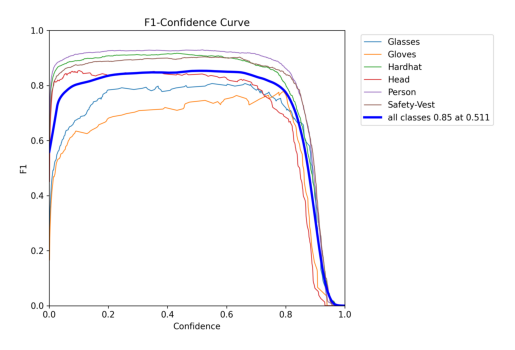



./runs/detect/model_03_06_yolov8m_5500_epochs/PR_curve.png
Terminado


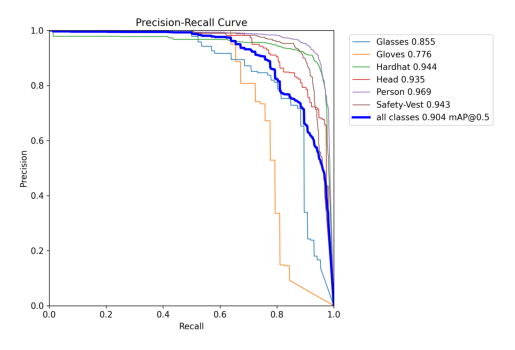



./runs/detect/model_03_06_yolov8m_5500_epochs/P_curve.png
Terminado


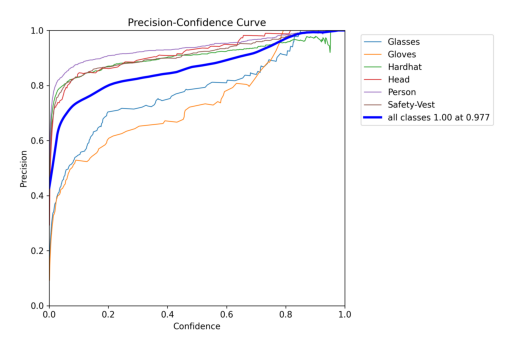



./runs/detect/model_03_06_yolov8m_5500_epochs/R_curve.png
Terminado


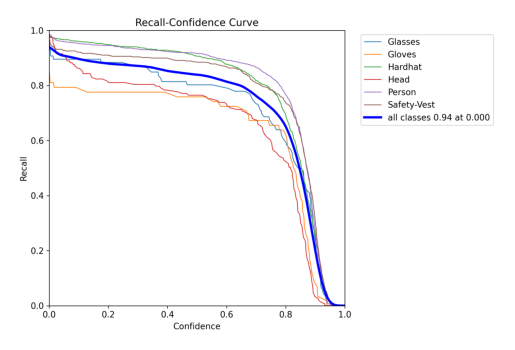



./runs/detect/model_03_06_yolov8m_5500_epochs/confusion_matrix.png
Terminado


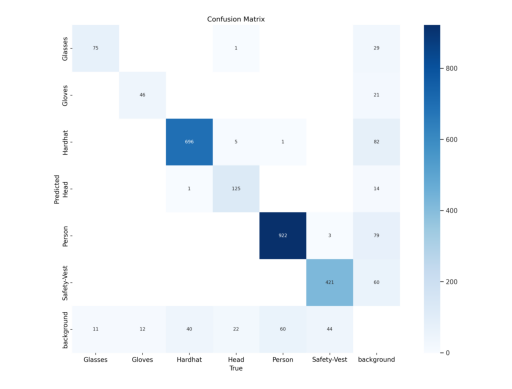



./runs/detect/model_03_06_yolov8m_5500_epochs/confusion_matrix_normalized.png
Terminado


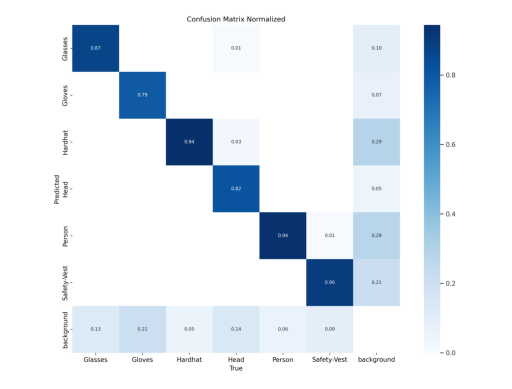



./runs/detect/model_03_06_yolov8m_5500_epochs/labels.jpg
Terminado


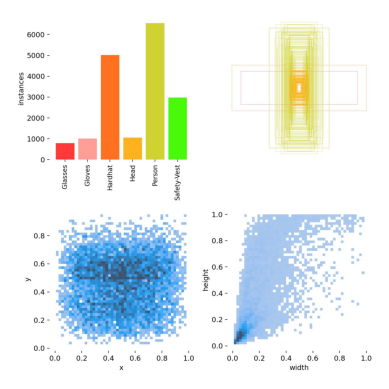



./runs/detect/model_03_06_yolov8m_5500_epochs/labels_correlogram.jpg
Terminado


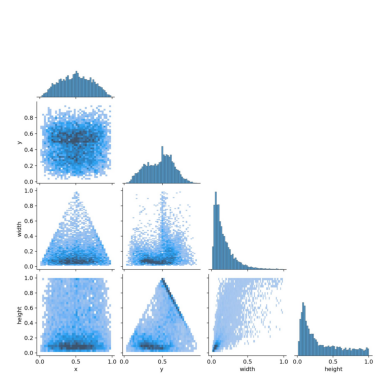



./runs/detect/model_03_06_yolov8m_5500_epochs/results.png
Terminado


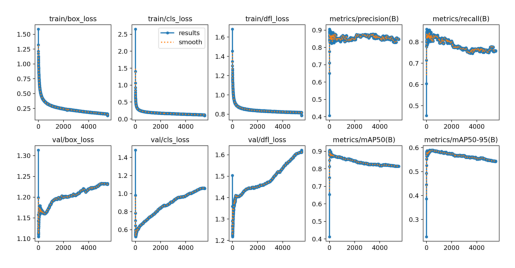

In [14]:
results_paths = [
    i for i in
    glob.glob(f'{CFG_WITH_TAG.OUTPUT_DIR}runs/detect/{CFG_WITH_TAG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG_WITH_TAG.OUTPUT_DIR}runs/detect/{CFG_WITH_TAG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

print(results_paths)

for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

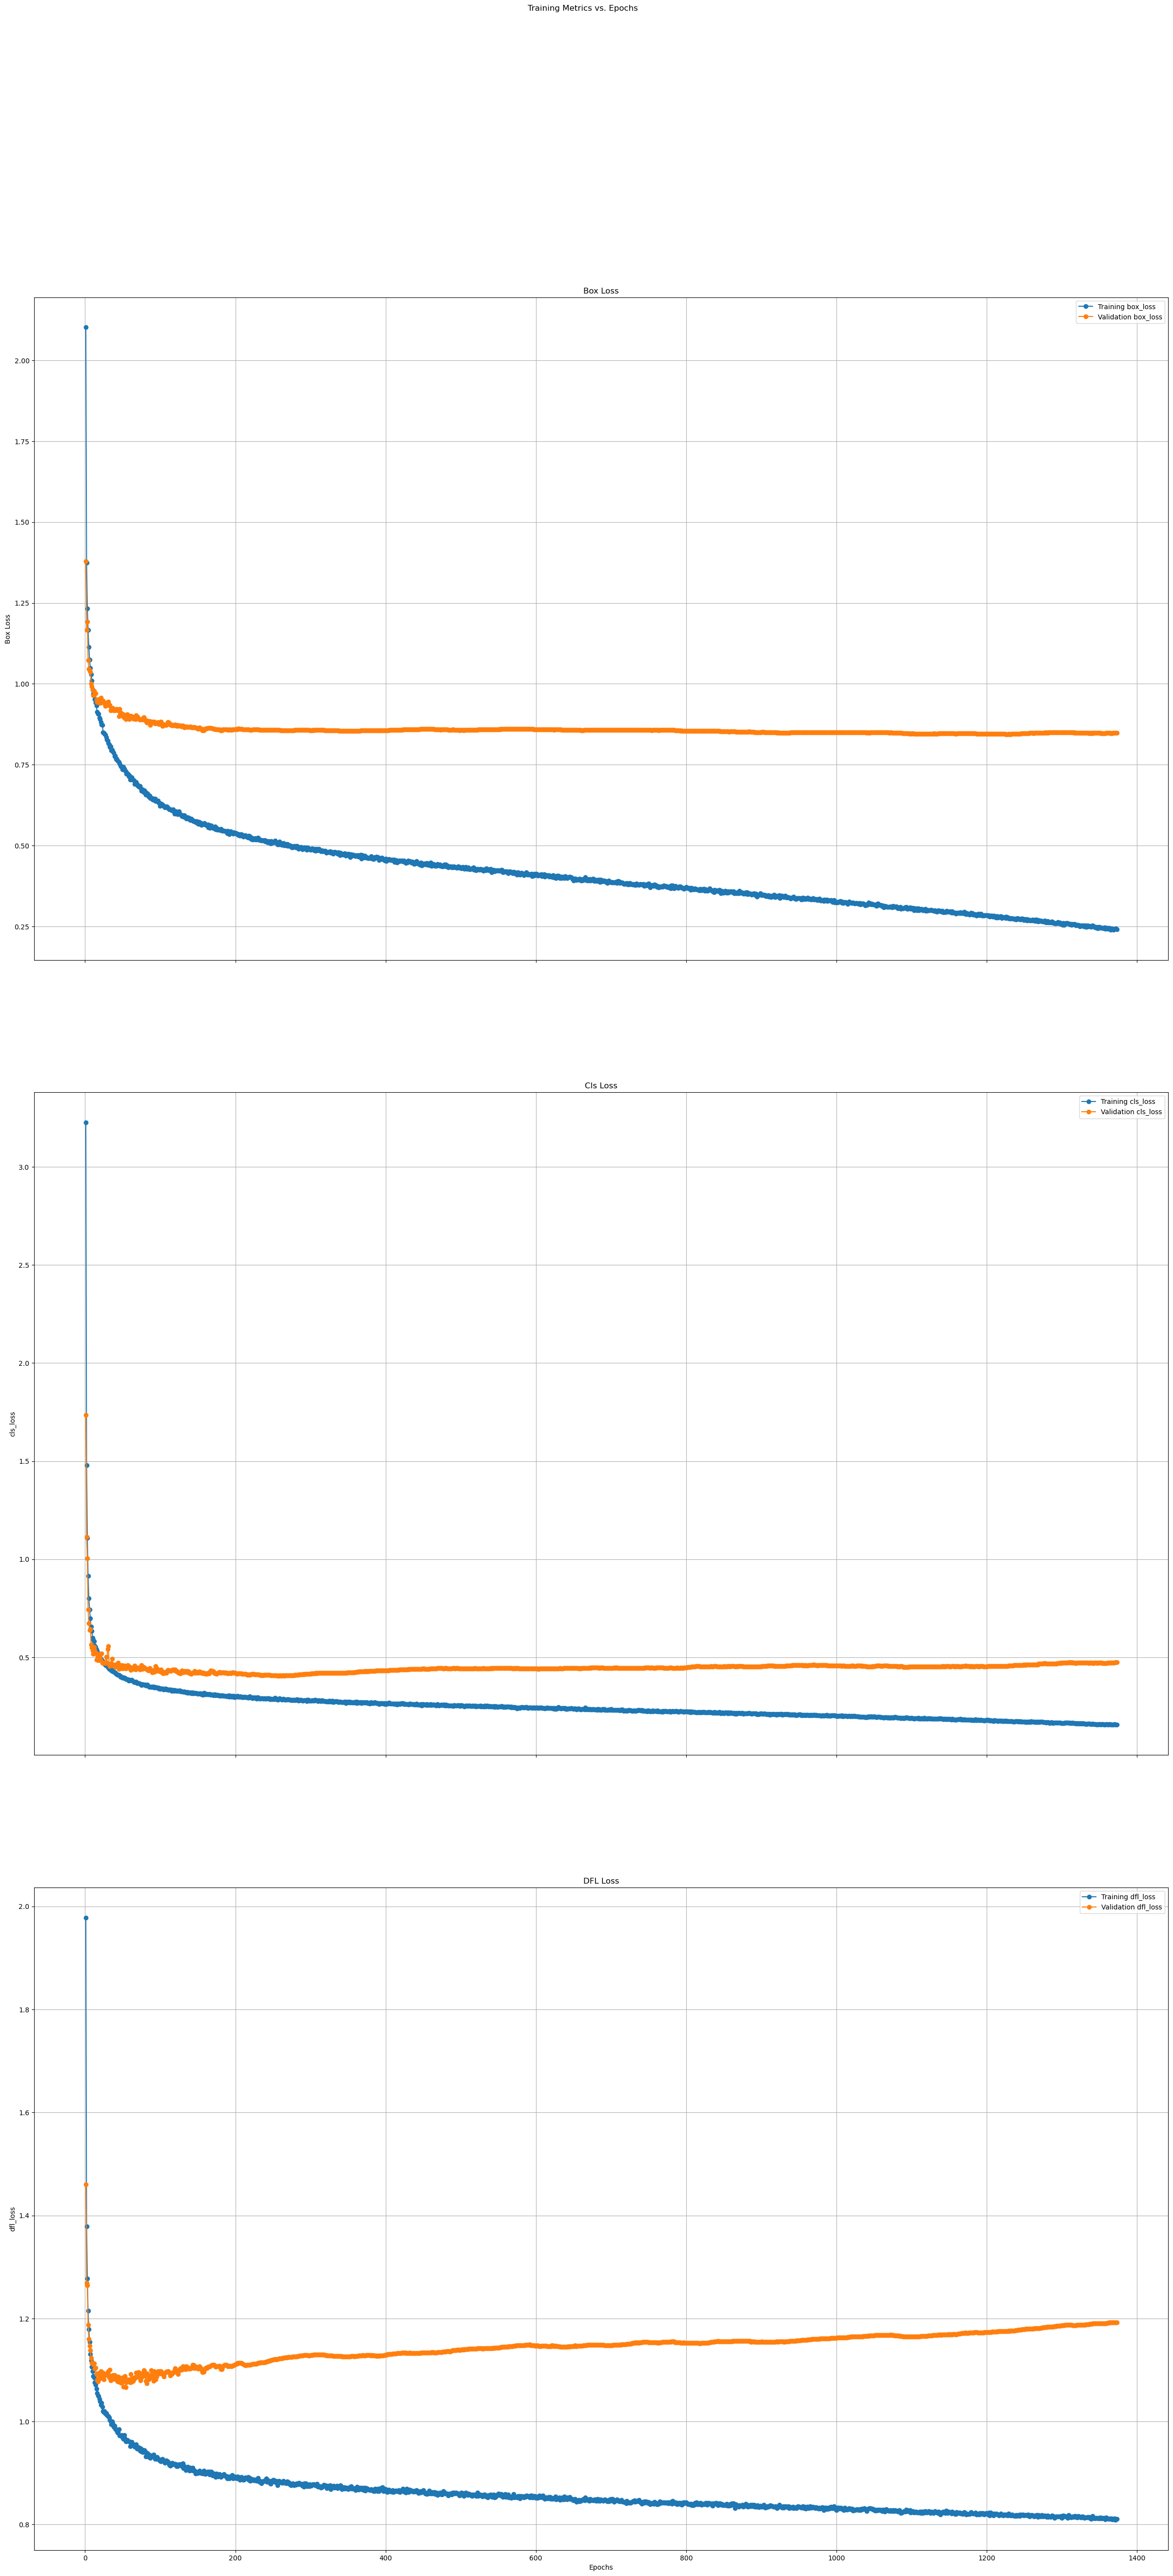

In [10]:
df = pd.read_csv(f'{CFG_WITH_TAG.OUTPUT_DIR}runs/detect/{CFG_WITH_TAG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG_WITH_TAG.OUTPUT_DIR}runs/detect/training_log_df.csv', index=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 60), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [28]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wjTRWk7oTFOQTs3Dk7gi")
project = rf.workspace("davidworkspace-3foib").project("epi_with_tag-2")
version = project.version(1)
dataset = version.download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.45, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to EPI_WITH_TAG-2-1 in yolov8:: 100%|██████████| 22336/22336 [00:00<00:00, 27354.53it/s]


In [10]:
import urllib.request
url = "https://www.youtube.com/watch?v=ngOxdhcx93I"
name = "EPI_VIDEO"
name=name+".mp4"
try:
    print("Downloading starts...\n")
    urllib.request.urlretrieve(url, name)
    print("Download completed..!!")
except Exception as e:
    print(e)


Download completed..!!


In [10]:
model = YOLO("/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/best.pt")
model.predict(
    source = "/home/jovyan/work/Safework/PPE_DETECTION_VIDEO_02.mp4",

    conf = 0.25,
    device = [1], # inference with dual GPU, cambiar a [1] cuando haya GPU

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/267) /home/jovyan/work/Safework/PPE_DETECTION_VIDEO_02.mp4: 384x640 2 Persons, 54.9ms
video 1/1 (frame 2/267) /home/jovyan/work/Safework/PPE_DETECTION_VIDEO_02.mp4: 384x640 1 Person, 4.5ms
video 1/1 (frame 3/267) /home/jovyan/work/Safework/PPE_DETECTION_VIDEO_02.mp4: 384x640 1 Person, 4.5ms
video 1/1 (frame 4/267) /home/jovyan/work/Safework/PPE_DETECTION_VIDEO_02.mp4: 384x640 1 Person, 4.5ms
video 1/1 (frame 5/267) /home/jovyan/work/

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Glasses', 1: 'Gloves', 2: 'Hardhat', 3: 'Head', 4: 'Person', 5: 'Safety-Vest'}
 obb: None
 orig_img: array([[[ 12,  12,  10],
         [ 12,  12,  10],
         [ 12,  12,  10],
         ...,
         [ 12,  15,   5],
         [ 12,  15,   5],
         [ 12,  15,   5]],
 
        [[ 11,  11,   9],
         [ 11,  11,   9],
         [ 11,  11,   9],
         ...,
         [ 12,  15,   5],
         [ 12,  15,   5],
         [ 12,  15,   5]],
 
        [[  8,   8,   6],
         [  8,   8,   6],
         [  8,   8,   6],
         ...,
         [ 12,  15,   5],
         [ 12,  15,   5],
         [ 12,  15,   5]],
 
        ...,
 
        [[ 43,  61,  63],
         [ 62,  80,  82],
         [ 71,  94, 100],
         ...,
         [137, 143, 147],
         [137, 143, 147],
         [137, 143, 147]],
 
        [[ 54,  76,  78],
         [ 67,

In [11]:
from pytube import YouTube 

# where to save 
SAVE_PATH = "/home/jovyan/work/Safework/"
# link of the video to be downloaded 
link = "https://www.youtube.com/watch?v=ngOxdhcx93I"

try: 
    # object creation using YouTube 
    yt = YouTube(link) 
except: 
    #to handle exception 
    print("Connection Error") 

# Get all streams and filter for mp4 files
mp4_streams = yt.streams.filter(file_extension='mp4').all()

# get the video with the highest resolution
d_video = mp4_streams[-1]

try: 
    # downloading the video 
    d_video.download(output_path=SAVE_PATH)
    print('Video downloaded successfully!')
except: 
    print("Some Error!")



/tmp/ipykernel_218/1666202006.py:16: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  mp4_streams = yt.streams.filter(file_extension='mp4').all()


Video downloaded successfully!


In [ ]:

from IPython.display import Video

Video("/home/jovyan/work/Safework/ERP de construcción con gestión de EPIs.mp4")

In [7]:
model = YOLO("/home/jovyan/work/Safework/runs/detect/model_03_06_yolov8m_5500_epochs/weights/best.pt")


In [10]:
metrics = model.val()

print(metrics.box.map) 
print(metrics.box.maps) 

Ultralytics 8.3.21 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 22706MiB)


val: Scanning /home/jovyan/work/Safework/EPI_WITH_TAG-1/valid/labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  8.96it/s]


                   all        374       2485      0.871      0.839      0.903      0.585
               Glasses         63         86       0.79      0.802      0.859      0.511
                Gloves         34         58      0.729      0.759      0.776      0.458
               Hardhat        291        737      0.913      0.906      0.943      0.609
                  Head         52        153      0.934      0.765      0.933      0.533
                Person        340        983      0.939      0.916      0.968      0.712
           Safety-Vest        192        468      0.922      0.885      0.941      0.687
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val7
0.5850243887929867
[    0.51115     0.45774     0.60909     0.53331     0.71234     0.68651]


In [ ]:
model.save('ppe_yolov8.pt')